In [4]:
import os

# Activate environment manually
# conda activate blueleaflabs

# Local project root
PROJECT_DIR = os.path.expanduser("~/heatshield")
os.makedirs(os.path.join(PROJECT_DIR, "results", "manual"), exist_ok=True)
os.chdir(PROJECT_DIR)


In [5]:
import os, json, math, io, zipfile, time, re, shutil, glob, pathlib
from datetime import datetime as dt, timedelta, timezone, date
from dateutil import parser as dateparser
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import requests
from urllib.parse import urljoin, quote
from bs4 import BeautifulSoup
from tqdm import tqdm
import pytz

import xarray as xr
import rasterio
from rasterio.mask import mask
import shapely
from shapely import ops 
from shapely.geometry import Point, Polygon, box, mapping
from shapely.ops import unary_union, transform as shp_transform
from pyproj import Transformer
import geopandas as gpd

import matplotlib.pyplot as plt
import folium
import ee  # Earth Engine

import warnings
warnings.filterwarnings("ignore")

print("Environment ready in VS Code.")

Environment ready in VS Code.


In [6]:
# --- Configurations for local VS Code setup (California full extent) ---

PURPLEAIR_SENSOR_INDEX = ''  # optional manual override
CDS_UID = ''
CDS_API_KEY = ''

CONFIG = {
    # Project identity
    "parent": "blueleaflabs",
    "project": "heatshield",

    # California bounding box (approximate)
    "bbox": {
        "nwlat": 42.0095,
        "nwlng": -124.4820,
        "selat": 32.5343,
        "selng": -114.1315
    },

    # Time window (UTC)
    "start_date": "2024-06-01",
    "end_date": "2024-10-31",

    # API tokens
    "CDO_TOKEN": "BrboArtFBPlkPVXhDLlmrUZiTLVwThSr",
    "AIRNOW_API_KEY": "BDF7B01F-7934-45E9-ABF7-5DC35F4E716C",
    "PURPLEAIR_API_KEY": "A2F84F7C-B439-11F0-BDE5-4201AC1DC121", #changed because the prior one ran out!
    "ACS_KEY": "b7e5e9c956393182b93ae8c0786895acdbbbf8e9",

    # Base URLs
    "USCRN_BASE_HOURLY": "https://www.ncei.noaa.gov/pub/data/uscrn/products/hourly02/",
    "HRRR_BASE_GENERIC": "https://nomads.ncep.noaa.gov/cgi-bin/filter_hrrr_2d.pl",
    "HRRR_BASE_SMOKE":   "https://nomads.ncep.noaa.gov/cgi-bin/filter_hrrr_smoke_2d.pl",
    "HMS_BASE_SMOKE": "https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Smoke_Polygons/Shapefile",
    "HMS_BASE_FIRE":  "https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Fire_Points/Shapefile",
    "ACS_BASE_ACS5": "https://api.census.gov/data/2023/acs/acs5",
    "ACS_BASE_SUBJECT": "https://api.census.gov/data/2023/acs/acs5/subject",
    "WHP_ZIP": "https://www.fs.usda.gov/rds/archive/products/RDS-2015-0047-4/RDS-2015-0047-4_Data.zip",
    "WHP_TIF_NAME": "Data/whp2023_GeoTIF/whp2023_cnt_conus.tif",

    # Headers
    "USER_AGENT_HEADERS": {"User-Agent": "HeatShield/1.0"},
    "NOMADS_HEADERS": {"User-Agent": "HeatShield/1.0", "Referer": "https://nomads.ncep.noaa.gov/"},

    # HRRR
    "HRRR_CYCLES": ["00"],
    "HRRR_FCST_HOURS": [0],

    # Output paths (will be absolutized below)
    "out_dir": "results",
    "NLCD_MANUAL_ZIP": "results/manual/Annual_NLCD_LndCov_2024_CU_C1V1.zip",

    # Spatial config
    "grid_resolution_m": 3000, # grid cell size in meters; 500 was too small for all of CA!
    "crs_epsg": 4326,

    # USCRN configuration for California
    "USCRN_STATION_NAME": [
        "CA Bodega 6 WSW",
        "CA Fallbrook 5 NE",
        "CA Merced 23 WSW",
        "CA Redding 12 WNW",
        "CA Santa Barbara 11 W",
        "CA Stovepipe Wells 1 SW",
        "CA Yosemite Village 12 W"
    ],
    "USCRN_YEARS": list(range(2024, 2025)),

    # AQS parameters
    "AQS_STATE_CODE": "06",  # California
    "AQS_EMAIL": "rohan3142@gmail.com",
    "AQS_KEY": "berrymouse51"
}

# --- Local file structure ---
PROJECT_DIR = "/Users/Shared/blueleaflabs/heatshield"
os.makedirs(os.path.join(PROJECT_DIR, "results", "manual"), exist_ok=True)

# Absolutize output paths
CONFIG["out_dir"] = os.path.join(PROJECT_DIR, "results")
CONFIG["NLCD_MANUAL_ZIP"] = os.path.join(CONFIG["out_dir"], "manual", "Annual_NLCD_LndCov_2024_CU_C1V1.zip")

# Set working directory
os.chdir(PROJECT_DIR)

print("Config loaded and local directories ready.")

Config loaded and local directories ready.


In [ ]:
# --- Ensure California boundary and build 3 km grid clipped to land ---

import os, io, zipfile, requests, numpy as np, pandas as pd, geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer
from shapely import ops

# Config
WGS84_EPSG = 4326
CA_ALBERS_EPSG = 3310
res_m = int(CONFIG.get("grid_resolution_m", 3000))
out_epsg = int(CONFIG.get("crs_epsg", 4326))
out_dir = CONFIG["out_dir"]; os.makedirs(out_dir, exist_ok=True)
inset_buffer_m = int(CONFIG.get("coast_inset_m", 0))  # e.g. 5000
boundary_path = CONFIG.get("ca_boundary_path", None)

# 1) Ensure boundary: download Census cartographic boundary if missing
if not boundary_path or not os.path.exists(boundary_path):
    states_zip = os.path.join(out_dir, "cb_2023_us_state_20m.zip")
    if not os.path.exists(states_zip):
        url = "https://www2.census.gov/geo/tiger/GENZ2023/shp/cb_2023_us_state_20m.zip"
        r = requests.get(url, timeout=120); r.raise_for_status()
        with open(states_zip, "wb") as f: f.write(r.content)
    # Read from zip directly and select California
    states = gpd.read_file(f"zip://{states_zip}")
    if states.empty:
        raise ValueError("Census states file loaded empty.")
    ca = states[states["STATEFP"].astype(str).str.zfill(2).eq("06")][["geometry"]]
    if ca.empty:
        raise ValueError("California polygon not found in Census states file.")
    boundary_path = os.path.join(out_dir, "california_boundary.gpkg")
    ca.to_file(boundary_path, driver="GPKG")
    CONFIG["ca_boundary_path"] = boundary_path  # persist for later cells

# 2) Load boundary, dissolve, project, optional inward buffer
b = gpd.read_file(boundary_path)
if b.crs is None: raise ValueError("Boundary file has no CRS.")
b = b[["geometry"]].copy()
b = b.to_crs(CA_ALBERS_EPSG)
b = gpd.GeoDataFrame(geometry=[b.unary_union], crs=f"EPSG:{CA_ALBERS_EPSG}")
if inset_buffer_m > 0:
    b.geometry = b.buffer(-inset_buffer_m)
    b = gpd.GeoDataFrame(geometry=[b.unary_union], crs=f"EPSG:{CA_ALBERS_EPSG}")

# 3) Build snapped rectilinear grid over boundary bounds in EPSG:3310
minx, miny, maxx, maxy = b.total_bounds
snap_down = lambda v, s: np.floor(v/s)*s
snap_up   = lambda v, s: np.ceil(v/s)*s
minx, miny = snap_down(minx, res_m), snap_down(miny, res_m)
maxx, maxy = snap_up(maxx, res_m), snap_up(maxy, res_m)

xs = np.arange(minx, maxx, res_m)
ys = np.arange(miny, maxy, res_m)
n_rect = len(xs)*len(ys)
if n_rect > 3_500_000:
    raise MemoryError(f"Grid too large ({n_rect:,}). Increase res_m or tile the state.")

cells, col_i, row_j = [], [], []
for j, y in enumerate(ys):
    for i, x in enumerate(xs):
        cells.append(box(x, y, x+res_m, y+res_m)); col_i.append(i); row_j.append(j)

gdf_proj = gpd.GeoDataFrame({"col_i": np.int32(col_i), "row_j": np.int32(row_j)},
                            geometry=cells, crs=f"EPSG:{CA_ALBERS_EPSG}")
gdf_proj["cell_area_m2"] = float(res_m)*float(res_m)
gdf_proj["grid_id"] = f"CA3310_{res_m}_" + gdf_proj["col_i"].astype(str) + "_" + gdf_proj["row_j"].astype(str)

# 4) Strict land clip and land fraction
gdf_proj = gpd.sjoin(gdf_proj, b, how="inner", predicate="intersects").drop(columns=["index_right"])
inter = gpd.overlay(gdf_proj[["grid_id","geometry"]], b, how="intersection", keep_geom_type=True)
inter["land_area_m2"] = inter.geometry.area
land = inter[["grid_id","land_area_m2"]].groupby("grid_id", as_index=False).sum()
gdf_proj = gdf_proj.merge(land, on="grid_id", how="left")
gdf_proj["land_area_m2"] = gdf_proj["land_area_m2"].fillna(0.0)
gdf_proj["land_frac"] = (gdf_proj["land_area_m2"] / gdf_proj["cell_area_m2"]).clip(0,1)
gdf_proj = gdf_proj[gdf_proj["land_frac"] > 0].reset_index(drop=True)

# 5) Reproject to requested output CRS and save
grid_gdf = gdf_proj.to_crs(out_epsg)

parquet_path = os.path.join(out_dir, f"grid_{res_m}m_CA.parquet")
grid_gdf.to_parquet(parquet_path, index=False)

geojson_path = os.path.join(out_dir, f"grid_{res_m}m_CA_head10.geojson")
grid_gdf.head(10).to_file(geojson_path, driver="GeoJSON")

# Diagnostics
cell_area_km2 = (res_m/1000.0)**2
eff_land_km2 = float((grid_gdf.get("land_frac",1.0) * cell_area_km2).sum())
print(f"Saved: {parquet_path}")
print(f"Cells: {len(grid_gdf):,}")
print(f"Effective land area ≈ {round(eff_land_km2):,} km²")
print(f"Implied cell size ≈ {round((eff_land_km2/len(grid_gdf))**0.5,2)} km")

grid_gdf.head()

In [ ]:
# --- Persist config + save grid (3310 ops copy, 4326 preview) + write metadata ---

# Inputs assumed from prior cell:
# - grid_gdf            : current grid GeoDataFrame (any CRS)
# - CONFIG              : dict with out_dir, grid_resolution_m, crs_epsg, ca_boundary_path
# - CA_ALBERS_EPSG=3310 : defined earlier

out_dir = CONFIG["out_dir"]; os.makedirs(out_dir, exist_ok=True)
res_m = int(CONFIG.get("grid_resolution_m", 3000))
out_epsg = int(CONFIG.get("crs_epsg", 4326))
boundary_path = CONFIG.get("ca_boundary_path")

# 1) Persist boundary path back to CONFIG 
if not boundary_path or not os.path.exists(boundary_path):
    raise FileNotFoundError("CONFIG['ca_boundary_path'] missing or invalid. Rebuild boundary.")
CONFIG["ca_boundary_path"] = boundary_path

config_runtime_path = os.path.join(out_dir, "config_runtime.json")
with open(config_runtime_path, "w") as f:
    json.dump(CONFIG, f, indent=2)
print("Saved:", config_runtime_path)

# 2) Ensure we have an EPSG:3310 version for spatial ops
if grid_gdf.crs is None:
    raise ValueError("grid_gdf has no CRS. Rebuild grid.")
grid_3310 = grid_gdf.to_crs(3310) if grid_gdf.crs.to_epsg() != 3310 else grid_gdf

# 3) Save operational GeoParquet in 3310 + lightweight WGS84 preview
parquet_3310 = os.path.join(out_dir, f"grid_{res_m}m_CA_epsg3310.parquet")
grid_3310.to_parquet(parquet_3310, index=False)
print("Saved:", parquet_3310, "| cells:", len(grid_3310))

# Optional small preview in 4326 for quick map checks
preview_4326 = grid_3310.to_crs(4326).head(500)  # cap to avoid huge files
geojson_preview = os.path.join(out_dir, f"grid_{res_m}m_CA_head500_epsg4326.geojson")
preview_4326.to_file(geojson_preview, driver="GeoJSON")
print("Saved:", geojson_preview)

# 4) Compute and save metadata
cell_area_km2 = (res_m/1000.0)**2
effective_land_km2 = float((grid_3310.get("land_frac", 1.0) * cell_area_km2).sum())
implied_cell_km = float((effective_land_km2 / len(grid_3310))**0.5)
minx, miny, maxx, maxy = grid_3310.total_bounds
bbox_km = ((maxx-minx)/1000.0, (maxy-miny)/1000.0)

meta = {
    "timestamp_utc": datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "grid_resolution_m": res_m,
    "crs_ops_epsg": 3310,
    "crs_export_default_epsg": out_epsg,
    "cells": int(len(grid_3310)),
    "effective_land_area_km2": round(effective_land_km2, 2),
    "implied_cell_km": round(implied_cell_km, 4),
    "bbox_km_width_height": [round(bbox_km[0], 2), round(bbox_km[1], 2)],
    "has_land_frac": bool("land_frac" in grid_3310.columns),
    "boundary_path": boundary_path,
    "parquet_3310_path": parquet_3310,
    "geojson_preview_4326_path": geojson_preview,
}

meta_path = os.path.join(out_dir, f"grid_{res_m}m_CA_meta.json")
with open(meta_path, "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:", meta_path)
meta

In [ ]:
# CDO data fetch and processing functions
# repeat some variables for clarity
OUT_DIR = CONFIG["out_dir"]
RAW_DIR = os.path.join(OUT_DIR, "cdo_raw_monthly")
CLEAN_DIR = os.path.join(OUT_DIR, "cdo_clean")
os.makedirs(RAW_DIR, exist_ok=True); os.makedirs(CLEAN_DIR, exist_ok=True)

def month_windows(start_date, end_date):
    s = dt.fromisoformat(start_date).date().replace(day=1)
    e = dt.fromisoformat(end_date).date()
    cur = s
    while cur <= e:
        nxt = (cur + relativedelta(months=1)) - relativedelta(days=1)
        yield cur.isoformat(), min(nxt, e).isoformat()
        cur = (cur + relativedelta(months=1)).replace(day=1)

def parse_attributes(attr):
    parts = (attr or "").split(","); parts += [""] * (4 - len(parts))
    mflag, qflag, sflag, obs_hhmm = parts[:4]
    return mflag or None, qflag or None, sflag or None, obs_hhmm or None

def fetch_cdo_page(session, url, headers, params, max_retries=6, base_delay=0.8):
    for attempt in range(max_retries):
        try:
            r = session.get(url, headers=headers, params=params, timeout=180)
            if r.status_code in (429, 500, 502, 503, 504):
                raise requests.HTTPError(f"{r.status_code} Retryable", response=r)
            r.raise_for_status()
            return r.json()
        except requests.HTTPError as e:
            if attempt == max_retries - 1:
                raise
            # exponential backoff with jitter
            delay = base_delay * (2 ** attempt) * (1 + 0.25 * (2 * (time.time() % 1) - 1))
            time.sleep(delay)

def cdo_stream_monthly(datasetid, locationid, startdate, enddate, datatypes, token,
                       units="standard", page_limit=1000, force=False):
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": token}
    session = requests.Session()
    written = []

    for dtid in datatypes:
        for ms, me in month_windows(startdate, enddate):
            out_csv = os.path.join(RAW_DIR, f"ghcnd_{dtid}_{ms[:7]}.csv")
            if os.path.exists(out_csv) and not force:
                # resume: skip existing month-datatype file
                written.append(out_csv); continue

            frames = []
            offset = 1
            while True:
                params = {
                    "datasetid": datasetid, "locationid": locationid,
                    "startdate": ms, "enddate": me,
                    "datatypeid": dtid, "units": units,
                    "limit": page_limit, "offset": offset
                }
                js = fetch_cdo_page(session, url, headers, params)
                rows = js.get("results", [])
                if not rows:
                    break
                frames.append(pd.json_normalize(rows))
                if len(rows) < page_limit:
                    break
                offset += page_limit
                time.sleep(0.15)  # gentle pacing

            if frames:
                df = pd.concat(frames, ignore_index=True)
                # normalize
                df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.date
                parsed = df["attributes"].apply(parse_attributes)
                df[["mflag","qflag","sflag","obs_hhmm"]] = pd.DataFrame(parsed.tolist(), index=df.index)
                # scale tenths
                scale = {"PRCP": 0.1, "TMAX": 0.1, "TMIN": 0.1}
                df["datatype"] = df["datatype"].astype(str)
                df["value"] = pd.to_numeric(df["value"], errors="coerce")
                df["value_scaled"] = df.apply(lambda r: r["value"] * scale.get(r["datatype"], 1.0), axis=1)
                # write monthly raw
                df[["date","datatype","station","attributes","mflag","qflag","sflag","obs_hhmm","value","value_scaled"]].to_csv(out_csv, index=False)
                written.append(out_csv)
            else:
                # create an empty file with header to mark completion
                with open(out_csv, "w", newline="") as f:
                    w = csv.writer(f); w.writerow(["date","datatype","station","attributes","mflag","qflag","sflag","obs_hhmm","value","value_scaled"])
                written.append(out_csv)
    return written

def build_clean_wide():
    # read all monthly raw files and assemble cleaned wide once
    files = sorted([os.path.join(RAW_DIR, f) for f in os.listdir(RAW_DIR) if f.endswith(".csv")])
    if not files:
        return None
    df = pd.concat((pd.read_csv(f, dtype={"datatype":str,"station":str}) for f in files), ignore_index=True)
    # convert types back
    df["date"] = pd.to_datetime(df["date"]).dt.date
    # keep good qflag
    df = df[(df["qflag"].isna()) | (df["qflag"]=="")]
    wide = (
        df.pivot_table(index=["station","date"], columns="datatype", values="value_scaled", aggfunc="mean")
          .reset_index()
          .rename(columns={"date":"obs_date","PRCP":"precipitation_mm","TMAX":"temperature_max_c","TMIN":"temperature_min_c"})
          .sort_values(["obs_date","station"])
    )
    # attach obs time from PRCP
    prcp_times = df[df["datatype"]=="PRCP"][["station","date","obs_hhmm"]].drop_duplicates().rename(columns={"date":"obs_date"})
    wide = wide.merge(prcp_times, on=["station","obs_date"], how="left")
    raw_all = os.path.join(OUT_DIR, "ghcnd_daily_raw_all.csv")
    wide_all = os.path.join(OUT_DIR, "ghcnd_daily_wide.csv")
    df.to_csv(raw_all, index=False)
    wide.to_csv(wide_all, index=False)
    return raw_all, wide_all, len(df), len(wide), wide["station"].nunique(), wide["obs_date"].nunique()

# ---- Run statewide with resume capability ----
if CONFIG["CDO_TOKEN"] and CONFIG["CDO_TOKEN"] != "YOUR_NCEI_CDO_TOKEN":
    written = cdo_stream_monthly(
        datasetid="GHCND",
        locationid="FIPS:06",                      # California statewide
        startdate=CONFIG["start_date"],
        enddate=CONFIG["end_date"],
        datatypes=["TMAX","TMIN","PRCP"],
        token=CONFIG["CDO_TOKEN"],
        units="standard",
        page_limit=1000,
        force=False                                 # set True to re-download
    )
    print(f"Monthly files written: {len(written)} → {RAW_DIR}")

    res = build_clean_wide()
    if res:
        raw_all, wide_all, n_raw, n_wide, n_stn, n_dates = res
        print(f"Saved raw:  {raw_all}")
        print(f"Saved wide: {wide_all}")
        print(f"Counts → raw: {n_raw} | wide: {n_wide} | stations: {n_stn} | dates: {n_dates}")
else:
    print("Skipping CDO (missing CDO token).")

In [ ]:
# AirNow PM2.5 hourly
# repeat some variables for clarity

OUT_DIR = CONFIG["out_dir"]
RAW_DIR = os.path.join(OUT_DIR, "airnow_raw_daily")
CLEAN_DIR = os.path.join(OUT_DIR, "airnow_clean")
os.makedirs(RAW_DIR, exist_ok=True); os.makedirs(CLEAN_DIR, exist_ok=True)

def day_windows(start_iso, end_iso):
    s = dt.fromisoformat(start_iso).date()
    e = dt.fromisoformat(end_iso).date()
    d = s
    while d <= e:
        yield d.isoformat()
        d += timedelta(days=1)

def fetch_airnow_day(api_key, bbox, day_iso, max_retries=6, base_delay=0.8):
    base = "https://www.airnowapi.org/aq/data/"
    params = {
        "startDate": f"{day_iso}T00",
        "endDate":   f"{day_iso}T23",
        "parameters": "PM25",
        "BBOX": f"{bbox['nwlng']},{bbox['selat']},{bbox['selng']},{bbox['nwlat']}",
        "dataType": "A",
        "format": "text/csv",
        "API_KEY": api_key
    }
    for attempt in range(max_retries):
        r = requests.get(base, params=params, timeout=180)
        # Retry on 429 and 5xx
        if r.status_code in (429, 500, 502, 503, 504):
            if attempt == max_retries - 1:
                r.raise_for_status()
            delay = base_delay * (2 ** attempt)
            time.sleep(delay)
            continue
        r.raise_for_status()
        return r.text
    return ""  # unreachable if raise above

def schema_coerce(df):
    # Expect 6 cols: lat, lon, datetime_utc, parameter, value, valid_flag
    if df.shape[1] != 6:
        # fall back: try reading with header and pick needed cols later
        return None
    df = df.rename(columns={0:"latitude",1:"longitude",2:"datetime_utc",3:"parameter",4:"value_ugm3",5:"valid"})
    # types
    df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
    df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
    # allow both “YYYY-MM-DDTHH:MM” and “YYYY-MM-DD HH:MM:SS”
    df["datetime_utc"] = pd.to_datetime(df["datetime_utc"], errors="coerce", utc=True)
    df["value_ugm3"] = pd.to_numeric(df["value_ugm3"], errors="coerce")
    df["valid"] = pd.to_numeric(df["valid"], errors="coerce")
    # normalize parameter label
    df["parameter"] = df["parameter"].astype(str).str.upper().str.replace(" ", "")
    return df

def in_bbox(df, b):
    return df[
        (df["longitude"] >= b["nwlng"]) & (df["longitude"] <= b["selng"]) &
        (df["latitude"]  >= b["selat"]) & (df["latitude"]  <= b["nwlat"])
    ]

def clean_airnow(df, bbox):
    df = df.dropna(subset=["datetime_utc","latitude","longitude","value_ugm3"])
    df = in_bbox(df, bbox)
    df = df[df["parameter"].isin(["PM2.5","PM25"])]
    # validity flag: keep valid==1 if present, else keep all
    if "valid" in df.columns:
        df = df[(df["valid"].isna()) | (df["valid"] == 1)]
    # value filters
    df = df[(df["value_ugm3"] >= 0) & (df["value_ugm3"] <= 1000)]
    # hour rounding and date field
    df["datetime_utc"] = df["datetime_utc"].dt.floor("H")
    df["date_utc"] = df["datetime_utc"].dt.date
    # de-dup
    df = df.drop_duplicates(subset=["latitude","longitude","datetime_utc","parameter"])
    return df

def airnow_stream(CONFIG, force=False):
    if not CONFIG.get("AIRNOW_API_KEY"):
        print("Skipping AirNow (missing API key).")
        return None

    bbox = CONFIG["bbox"]
    api_key = CONFIG["AIRNOW_API_KEY"]
    written = []

    for day in day_windows(CONFIG["start_date"], CONFIG["end_date"]):
        out_csv = os.path.join(RAW_DIR, f"airnow_PM25_{day}.csv")
        if os.path.exists(out_csv) and not force:
            written.append(out_csv)
            continue
        try:
            csv_txt = fetch_airnow_day(api_key, bbox, day)
        except requests.HTTPError as e:
            print(f"HTTP error {e.response.status_code} on {day}. Skipping after retries.")
            continue

        if csv_txt.strip():
            # Save raw daily file immediately
            with open(out_csv, "w", encoding="utf-8") as f:
                f.write(csv_txt)
            written.append(out_csv)
            time.sleep(0.15)  # gentle pacing
        else:
            # create empty file to mark completion
            with open(out_csv, "w", encoding="utf-8") as f:
                f.write("")
            written.append(out_csv)

    # Build consolidated raw and cleaned
    parts = []
    for fn in sorted(os.listdir(RAW_DIR)):
        if not fn.endswith(".csv"): 
            continue
        p = os.path.join(RAW_DIR, fn)
        if os.path.getsize(p) == 0:
            continue
        # AirNow daily CSV has no header; read as no-header
        df = pd.read_csv(p, header=None)
        df = schema_coerce(df)
        if df is None:
            continue
        parts.append(df)

    if not parts:
        print("No AirNow data assembled.")
        return None

    raw_all = pd.concat(parts, ignore_index=True)
    # Filter to project window again and clean
    sd = pd.to_datetime(CONFIG["start_date"]).date()
    ed = pd.to_datetime(CONFIG["end_date"]).date()
    raw_all = raw_all[(raw_all["datetime_utc"].dt.date >= sd) & (raw_all["datetime_utc"].dt.date <= ed)]

    raw_all_path = os.path.join(OUT_DIR, "airnow_pm25_raw.parquet")
    raw_all.to_parquet(raw_all_path, index=False)

    clean = clean_airnow(raw_all.copy(), bbox)

    # Aggregate to station-like IDs by lat/lon to dovetail with other sources
    # Define a stable sensor_id as rounded lat/lon
    clean["sensor_id"] = clean["latitude"].round(5).astype(str) + "," + clean["longitude"].round(5).astype(str)

    clean_path = os.path.join(OUT_DIR, "airnow_pm25_clean.parquet")
    clean.to_parquet(clean_path, index=False)

    # Daily wide aggregation if needed:
    daily = (clean
             .groupby(["sensor_id", "date_utc"], as_index=False)["value_ugm3"]
             .mean()
             .rename(columns={"date_utc":"obs_date","value_ugm3":"pm25_ugm3"}))
    daily_path = os.path.join(OUT_DIR, "airnow_pm25_daily.parquet")
    daily.to_parquet(daily_path, index=False)

    print(f"Written raw:   {raw_all_path}")
    print(f"Written clean: {clean_path}")
    print(f"Written daily: {daily_path}")
    print("Rows raw:", len(raw_all), "Rows clean:", len(clean), "Sensors:", clean["sensor_id"].nunique())

# Run with resume behavior
airnow_stream(CONFIG, force=False)

In [ ]:
# PurpleAir PM2.5 snapshot (CA bbox) with max_age and resume
# - fields minimized
# - max_age=1440 minutes (24h) to target ~1,100 pages at 1,000 rows/page
# - per-page parquet checkpoints for resume
# - retries with backoff; graceful 402 stop
# - cleaned + calibrated outputs aligned with other datasets

# USELESS for the moment -- this is only current data
# History requires PurpleAir Premium subscription and different API calls
# Keep for reference/future use


OUT_DIR = CONFIG["out_dir"]
RAW_DIR = os.path.join(OUT_DIR, "purpleair_raw_pages")
os.makedirs(RAW_DIR, exist_ok=True)

PA_BASE   = "https://api.purpleair.com/v1/sensors"
PA_FIELDS = "sensor_index,pm2.5_atm,humidity,temperature,latitude,longitude,last_seen"
PA_LIMIT  = 1000
PA_LOC    = 0          # 0 = outdoor
MAX_AGE_M = 1440       # last 24 hours
MAX_PAGES = 1100       # target cap
BACKOFF_BASE = 0.8

def fetch_page(session, api_key, bbox, page, max_retries=6, timeout=180):
    headers = {"X-API-Key": api_key}
    params = {
        "fields": PA_FIELDS,
        "location_type": PA_LOC,
        "nwlng": bbox["nwlng"], "nwlat": bbox["nwlat"],
        "selng": bbox["selng"], "selat": bbox["selat"],
        "limit": PA_LIMIT, "page": page,
        "max_age": MAX_AGE_M
    }
    for attempt in range(max_retries):
        r = session.get(PA_BASE, headers=headers, params=params, timeout=timeout)
        if r.status_code == 402:
            # Payment required; keep what we have and stop paging
            return "PAYWALL", None
        if r.status_code in (429, 500, 502, 503, 504):
            # retry with exponential backoff
            if attempt == max_retries - 1:
                r.raise_for_status()
            time.sleep(BACKOFF_BASE * (2 ** attempt))
            continue
        r.raise_for_status()
        js = r.json()
        return "OK", js
    return "ERROR", None

def coerce_schema(df):
    for c in ["latitude","longitude","pm2.5_atm","humidity","temperature"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if "sensor_index" in df.columns:
        df["sensor_index"] = pd.to_numeric(df["sensor_index"], errors="coerce").astype("Int64")
    if "last_seen" in df.columns:
        df["last_seen_utc"] = pd.to_datetime(df["last_seen"], unit="s", utc=True, errors="coerce")
        df["hour_utc"] = df["last_seen_utc"].dt.floor("H")
        df["date_utc"] = df["last_seen_utc"].dt.date
    return df

def in_bbox(df, b):
    return df[
        (df["longitude"] >= b["nwlng"]) & (df["longitude"] <= b["selng"]) &
        (df["latitude"]  >= b["selat"]) & (df["latitude"]  <= b["nwlat"])
    ]

def clean_calibrate(df, bbox, start_iso=None, end_iso=None):
    df = df.dropna(subset=["latitude","longitude","pm2.5_atm","last_seen_utc"])
    df = in_bbox(df, bbox)
    if start_iso and end_iso:
        sd = pd.to_datetime(start_iso).date()
        ed = pd.to_datetime(end_iso).date()
        df = df[(df["date_utc"] >= sd) & (df["date_utc"] <= ed)]
    # sanity filters
    df = df[(df["pm2.5_atm"].between(0, 1000))]
    if "humidity" in df:
        df = df[(df["humidity"].between(0, 100)) | df["humidity"].isna()]
    if "temperature" in df:
        df = df[(df["temperature"].between(-40, 60)) | df["temperature"].isna()]
    # calibration
    rh = df["humidity"].fillna(0) if "humidity" in df else 0
    df["pm25_corrected_ugm3"] = (0.52*df["pm2.5_atm"] - 0.086*rh + 5.75).clip(lower=0)
    # stable id
    df["sensor_id"] = df["sensor_index"].astype(str) if "sensor_index" in df else df["latitude"].round(5).astype(str)+","+df["longitude"].round(5).astype(str)
    # dedup per sensor-hour
    if "hour_utc" in df:
        df = df.sort_values(["sensor_id","hour_utc"]).drop_duplicates(["sensor_id","hour_utc"], keep="last")
    return df

def purpleair_run(CONFIG, force=False):
    if not CONFIG.get("PURPLEAIR_API_KEY"):
        print("Skipping PurpleAir (missing API key).")
        return

    bbox = CONFIG["bbox"]
    api_key = CONFIG["PURPLEAIR_API_KEY"]
    session = requests.Session()

    # page loop with resume
    page = 1
    page_files = []
    while page <= MAX_PAGES:
        page_path = os.path.join(RAW_DIR, f"purpleair_page_{page:04d}.parquet")
        if os.path.exists(page_path) and not force:
            page_files.append(page_path)
            page += 1
            continue

        status, js = fetch_page(session, api_key, bbox, page)
        if status == "PAYWALL":
            print(f"Stopped at paywall on page {page}. Check MAX_AGE or plan.")
            break
        if status != "OK" or js is None:
            print(f"Stopped on error at page {page}.")
            break

        rows = js.get("data", [])
        if not rows:
            break

        cols = js.get("fields", PA_FIELDS.split(","))
        df = pd.DataFrame(rows, columns=cols)
        df = coerce_schema(df)

        # write page checkpoint
        df.to_parquet(page_path, index=False)
        page_files.append(page_path)

        if len(rows) < PA_LIMIT:
            break
        page += 1
        time.sleep(0.15)

    if not page_files:
        print("No PurpleAir pages written.")
        return

    # consolidate
    parts = [pd.read_parquet(p) for p in page_files if os.path.getsize(p) > 0]
    if not parts:
        print("No PurpleAir data assembled.")
        return
    raw_all = pd.concat(parts, ignore_index=True)
    raw_all = coerce_schema(raw_all)

    raw_path = os.path.join(OUT_DIR, "purpleair_raw.parquet")
    raw_all.to_parquet(raw_path, index=False)

    # clean + calibrate
    clean = clean_calibrate(raw_all.copy(), bbox, CONFIG["start_date"], CONFIG["end_date"])
    clean_path = os.path.join(OUT_DIR, "purpleair_clean.parquet")
    clean.to_parquet(clean_path, index=False)

    # hourly aggregate
    hourly = (clean.groupby(["sensor_id","hour_utc"], as_index=False)
              .agg(latitude=("latitude","mean"),
                   longitude=("longitude","mean"),
                   pm25_atm_ugm3=("pm2.5_atm","mean"),
                   pm25_corrected_ugm3=("pm25_corrected_ugm3","mean")))
    hourly_path = os.path.join(OUT_DIR, "purpleair_hourly.parquet")
    hourly.to_parquet(hourly_path, index=False)

    print(f"Pages saved: {len(page_files)} (target cap {MAX_PAGES})")
    print(f"Saved raw:   {raw_path} rows={len(raw_all)}")
    print(f"Saved clean: {clean_path} rows={len(clean)} sensors={clean['sensor_id'].nunique()}")
    print(f"Saved hourly:{hourly_path} rows={len(hourly)}")

purpleair_run(CONFIG, force=False)

In [ ]:
# AQS PM2.5 (88101) hourly for CA, daily slicing with resume
# - requires AQS_EMAIL and AQS_KEY in CONFIG
# variables repeated for clarity

OUT_DIR   = CONFIG["out_dir"]
AQS_EMAIL = CONFIG.get("AQS_EMAIL", "")
AQS_KEY   = CONFIG.get("AQS_KEY", "")
BBOX      = CONFIG["bbox"]
START_ISO = CONFIG["start_date"]
END_ISO   = CONFIG["end_date"]

if not AQS_EMAIL or not AQS_KEY:
    print("Skipping AQS (missing AQS_EMAIL/AQS_KEY in CONFIG).")
else:
    RAW_DIR = os.path.join(OUT_DIR, "aqs_raw_daily")
    os.makedirs(RAW_DIR, exist_ok=True)

    BASE = "https://aqs.epa.gov/data/api/sampleData/byBox"
    PARAM = "88101"
    PT = pytz.timezone("America/Los_Angeles")
    UTC = pytz.UTC
    MAX_RETRIES = 6
    BACKOFF_BASE = 0.8
    TIMEOUT = 120  # tighter per-day timeout

    def day_slices(start_iso, end_iso):
        s = dt.fromisoformat(start_iso).date()
        e = dt.fromisoformat(end_iso).date()
        d = s
        while d <= e:
            ds = d.isoformat()
            yield ds, ds
            d += timedelta(days=1)

    def fetch_day(bdate, edate):
        params = dict(
            email=AQS_EMAIL, key=AQS_KEY, param=PARAM,
            bdate=bdate.replace("-", ""), edate=edate.replace("-", ""),
            minlat=BBOX["selat"], maxlat=BBOX["nwlat"],
            minlon=BBOX["nwlng"], maxlon=BBOX["selng"],
        )
        headers = {"Accept":"application/json"}
        for a in range(MAX_RETRIES):
            try:
                r = requests.get(BASE, params=params, headers=headers, timeout=TIMEOUT)
                if r.status_code in (429,500,502,503,504):
                    if a == MAX_RETRIES-1: r.raise_for_status()
                    time.sleep(BACKOFF_BASE*(2**a)); continue
                if r.status_code == 400:
                    try:
                        print("AQS 400:", r.json().get("Header"))
                    except Exception:
                        print("AQS 400 raw:", r.text[:400])
                r.raise_for_status()
                js = r.json()
                return js.get("Data", []) or js.get("data", [])
            except requests.exceptions.ReadTimeout:
                if a == MAX_RETRIES-1: raise
                time.sleep(BACKOFF_BASE*(2**a))
        return []

    def parse_times(df):
        if {"date_gmt","time_gmt"}.issubset(df.columns):
            dt_gmt = pd.to_datetime(df["date_gmt"].astype(str)+" "+df["time_gmt"].astype(str),
                                    errors="coerce", utc=True)
            df["datetime_utc"] = dt_gmt
        else:
            dt_loc = pd.to_datetime(df["date_local"].astype(str)+" "+df["time_local"].astype(str),
                                    errors="coerce")
            dt_loc = dt_loc.apply(lambda x: PT.localize(x) if pd.notna(x) else x)
            df["datetime_utc"] = pd.to_datetime(dt_loc).dt.tz_convert(UTC)
        df["datetime_pt"] = df["datetime_utc"].dt.tz_convert(PT)
        df["hour_utc"] = df["datetime_utc"].dt.floor("H")
        return df

    def clean_aqs(df):
        if df.empty: return df
        val_col = "sample_measurement" if "sample_measurement" in df.columns else ("value" if "value" in df.columns else None)
        lat_col = "latitude" if "latitude" in df.columns else ("site_latitude" if "site_latitude" in df.columns else None)
        lon_col = "longitude" if "longitude" in df.columns else ("site_longitude" if "site_longitude" in df.columns else None)

        for c in [val_col, lat_col, lon_col]:
            if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

        # bbox and ranges
        if lat_col and lon_col:
            df = df[(df[lon_col].between(BBOX["nwlng"], BBOX["selng"])) &
                    (df[lat_col].between(BBOX["selat"], BBOX["nwlat"]))]
        df = df[(df[val_col].between(0, 1000))]

        df = parse_times(df)

        # station id
        if {"state_code","county_code","site_number","poc"}.issubset(df.columns):
            df["station_id"] = (df["state_code"].astype(str)+"-"+df["county_code"].astype(str)+"-"+
                                df["site_number"].astype(str)+"-"+df["poc"].astype(str))
        elif "aqs_site_id" in df.columns:
            df["station_id"] = df["aqs_site_id"].astype(str)
        else:
            df["station_id"] = (df.get(lat_col, pd.Series(dtype=float)).round(5).astype(str)+","+
                                df.get(lon_col, pd.Series(dtype=float)).round(5).astype(str))

        df = df.rename(columns={val_col:"pm25_ugm3", lat_col:"latitude", lon_col:"longitude"})
        df = df.sort_values(["station_id","hour_utc"]).drop_duplicates(["station_id","hour_utc"], keep="last")

        keep = ["station_id","latitude","longitude","datetime_utc","datetime_pt","hour_utc","pm25_ugm3"]
        meta = [c for c in ["method","method_code","units","units_of_measure","sample_duration","qc_status"] if c in df.columns]
        return df[keep+meta].reset_index(drop=True)

    # ---- Run: daily resume ----
    daily_files = []
    for b, e in day_slices(START_ISO, END_ISO):
        raw_csv = os.path.join(RAW_DIR, f"aqs_88101_{b}.csv")
        if not os.path.exists(raw_csv):
            data = fetch_day(b, e)
            if data:
                pd.json_normalize(data).to_csv(raw_csv, index=False)
            else:
                open(raw_csv, "w").close()
            time.sleep(0.1)
        daily_files.append(raw_csv)
    print(f"Days fetched or skipped: {len(daily_files)} → {RAW_DIR}")

    # consolidate
    parts = [pd.read_csv(p, low_memory=False) for p in daily_files if os.path.getsize(p) > 0]
    if not parts:
        print("No AQS data to assemble."); raise SystemExit
    raw_all = pd.concat(parts, ignore_index=True)

    # clean
    clean = clean_aqs(raw_all.copy())

    # enforce project window in UTC
    sd = pd.to_datetime(START_ISO).tz_localize("UTC")
    ed = pd.to_datetime(END_ISO).tz_localize("UTC") + pd.Timedelta(hours=23, minutes=59)
    clean = clean[(clean["datetime_utc"] >= sd) & (clean["datetime_utc"] <= ed)]

    # save outputs
    raw_path   = os.path.join(OUT_DIR, "aqs_pm25_raw.parquet")
    clean_path = os.path.join(OUT_DIR, "aqs_pm25_clean.parquet")
    daily_path = os.path.join(OUT_DIR, "aqs_pm25_daily.parquet")

    raw_all.to_parquet(raw_path, index=False)
    clean.to_parquet(clean_path, index=False)
    daily = (clean.assign(obs_date=clean["datetime_pt"].dt.date)
                   .groupby(["station_id","obs_date"], as_index=False)["pm25_ugm3"].mean())
    daily.to_parquet(daily_path, index=False)

    print(f"Saved raw:   {raw_path}  rows={len(raw_all)}")
    print(f"Saved clean: {clean_path} rows={len(clean)} stations={clean['station_id'].nunique()}")
    print(f"Saved daily: {daily_path} rows={len(daily)}")

In [ ]:
# USCRN 2024 hourly → raw + clean with resume, bbox/time filters, and QA
# we'll move the imports back up later 

import os, re, time
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from datetime import datetime as dt, timezone
import pytz

BASE_HOURLY = CONFIG["USCRN_BASE_HOURLY"]
OUT_DIR     = CONFIG["out_dir"]
UA          = CONFIG["USER_AGENT_HEADERS"]
BBOX        = CONFIG["bbox"]
PT          = pytz.timezone("America/Los_Angeles")

RAW_DIR   = os.path.join(OUT_DIR, "uscrn_raw")
CLEAN_DIR = os.path.join(OUT_DIR, "uscrn_clean")
os.makedirs(RAW_DIR, exist_ok=True); os.makedirs(CLEAN_DIR, exist_ok=True)

# enforce 2024 only
# better to do this purely from config but we're locking it here for now
years = [y for y in CONFIG.get("USCRN_YEARS", []) if y == 2024] or [2024]
if years != [2024]:
    print("USCRN_YEARS adjusted to [2024] for this run.")
stations_cfg = CONFIG["USCRN_STATION_NAME"]
if not isinstance(stations_cfg, list):
    stations_cfg = [stations_cfg]
stations_cfg = [s for s in stations_cfg if s and str(s).strip()]

def list_links(url):
    r = requests.get(url, headers=UA, timeout=120)
    r.raise_for_status()
    soup = BeautifulSoup(r.text, "lxml")
    return [a["href"] for a in soup.find_all("a", href=True)]

def normalize(s):
    return re.sub(r"[^a-z0-9]", "", str(s).lower())

def within_bbox(lat, lon, b=BBOX):
    return (b["selat"] <= lat <= b["nwlat"]) and (b["nwlng"] <= lon <= b["selng"])

def download_uscrn_files(force=False):
    downloaded = 0
    for station_raw in stations_cfg:
        # match variants for filenames
        variants_norm = {
            normalize(station_raw),
            normalize(station_raw.replace(" ", "_")),
            normalize(station_raw.replace(" ", "-")),
            normalize(station_raw.replace(" ", "")),
        }
        for y in years:
            year_url = urljoin(BASE_HOURLY, f"{y}/")
            try:
                hrefs = list_links(year_url)
            except Exception as e:
                print(f"{y}: index error → {e}")
                continue
            txts = [h for h in hrefs if h.lower().endswith(".txt") and not re.search(r"readme|header", h, re.I)]
            if not txts:
                print(f"{y}: no .txt files")
                continue
            matched = [h for h in txts if any(v in normalize(h) for v in variants_norm)]
            if not matched:
                print(f"{y}: no files matched {station_raw}")
                continue
            for h in matched:
                url = urljoin(year_url, h)
                out = os.path.join(RAW_DIR, os.path.basename(url))
                if os.path.exists(out) and not force:
                    # resume: keep existing
                    continue
                try:
                    with requests.get(url, headers=UA, stream=True, timeout=300) as r:
                        r.raise_for_status()
                        with open(out, "wb") as f:
                            for chunk in r.iter_content(1<<16):
                                if chunk: f.write(chunk)
                    downloaded += 1
                except Exception as e:
                    print(f"skip {url} → {e}")
                    continue
    print(f"Raw USCRN files ready. New downloads: {downloaded}")

def parse_uscrn_hourly_file(filepath):
    # CRNH02 hourly v2.5 columns (subset + flags). Many files are whitespace-delimited.
    cols = ["WBANNO","UTC_DATE","UTC_TIME","LST_DATE","LST_TIME","CRX_VN","LONGITUDE","LATITUDE",
            "T_CALC","T_HR_AVG","T_MAX","T_MIN","P_CALC",
            "SOLARAD","SOLARAD_FLAG","SOLARAD_MAX","SOLARAD_MAX_FLAG","SOLARAD_MIN","SOLARAD_MIN_FLAG",
            "SUR_TEMP_TYPE","SUR_TEMP","SUR_TEMP_FLAG","SUR_TEMP_MAX","SUR_TEMP_MAX_FLAG","SUR_TEMP_MIN","SUR_TEMP_MIN_FLAG",
            "RH_HR_AVG","RH_HR_AVG_FLAG",
            "SOIL_MOISTURE_5","SOIL_MOISTURE_10","SOIL_MOISTURE_20","SOIL_MOISTURE_50","SOIL_MOISTURE_100",
            "SOIL_TEMP_5","SOIL_TEMP_10","SOIL_TEMP_20","SOIL_TEMP_50","SOIL_TEMP_100"]
    recs = []
    with open(filepath, "r") as f:
        for line in f:
            s = line.strip()
            if not s or s.startswith("#"):  # skip blanks and comments
                continue
            parts = s.split()
            if len(parts) < 28:  # minimal length guard
                continue
            parts = parts[:len(cols)] + [""]*(len(cols)-len(parts)) if len(parts) < len(cols) else parts[:len(cols)]
            recs.append(parts)
    if not recs:
        return pd.DataFrame(columns=cols)
    df = pd.DataFrame(recs, columns=cols)

    # numeric coercion; USCRN sentinel often -9999 or -99
    num_cols = ["LONGITUDE","LATITUDE","T_CALC","T_HR_AVG","T_MAX","T_MIN","P_CALC",
                "SOLARAD","SOLARAD_MAX","SOLARAD_MIN","SUR_TEMP","SUR_TEMP_MAX","SUR_TEMP_MIN",
                "RH_HR_AVG","SOIL_MOISTURE_5","SOIL_MOISTURE_10","SOIL_MOISTURE_20","SOIL_MOISTURE_50","SOIL_MOISTURE_100",
                "SOIL_TEMP_5","SOIL_TEMP_10","SOIL_TEMP_20","SOIL_TEMP_50","SOIL_TEMP_100"]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # time parsing
    df["UTC_DATETIME"] = pd.to_datetime(df["UTC_DATE"].astype(str) + df["UTC_TIME"].astype(str), format="%Y%m%d%H%M", errors="coerce").dt.tz_localize("UTC")
    # LST (file’s local standard time) is not TZ-aware; for CA we convert UTC → PT explicitly for alignment
    df["LST_DATETIME_PT"] = df["UTC_DATETIME"].dt.tz_convert(PT)

    # filter obvious missings (USCRN uses -9999 etc.)
    for c in ["T_HR_AVG","T_MAX","T_MIN","P_CALC","SOLARAD","SUR_TEMP","RH_HR_AVG"]:
        if c in df.columns:
            df.loc[df[c] <= -999, c] = np.nan

    # range sanity checks (kept conservative)
    rng = {
        "T_HR_AVG": (-60, 60), "T_MAX": (-60, 60), "T_MIN": (-80, 60),
        "P_CALC": (0, 500),    # mm/h
        "RH_HR_AVG": (0, 100),
        "SOLARAD": (0, 1400),  # W/m^2
    }
    for c,(lo,hi) in rng.items():
        if c in df.columns:
            df.loc[~df[c].between(lo, hi), c] = np.nan

    # keep only rows with coordinates in CA bbox
    df = df.dropna(subset=["LATITUDE","LONGITUDE"])
    df = df[df.apply(lambda r: within_bbox(r["LATITUDE"], r["LONGITUDE"]), axis=1)]

    return df

def build_clean_for_window():
    # read all downloaded files
    files = [os.path.join(RAW_DIR, f) for f in os.listdir(RAW_DIR) if f.endswith(".txt")]
    if not files:
        print("No USCRN raw .txt files found.")
        return None

    parts = []
    for fp in files:
        try:
            df = parse_uscrn_hourly_file(fp)
            if not df.empty:
                parts.append(df)
        except Exception as e:
            print(f"parse error {os.path.basename(fp)} → {e}")

    if not parts:
        print("No parsable USCRN data.")
        return None

    df = pd.concat(parts, ignore_index=True)

    # enforce project window in UTC
    sd = pd.to_datetime(CONFIG["start_date"]).tz_localize("UTC")
    ed = pd.to_datetime(CONFIG["end_date"]).tz_localize("UTC") + pd.Timedelta(hours=23, minutes=59)
    df = df[(df["UTC_DATETIME"] >= sd) & (df["UTC_DATETIME"] <= ed)]

    # rename to standard columns
    df = df.rename(columns={
        "WBANNO":"station_id",
        "LONGITUDE":"longitude",
        "LATITUDE":"latitude",
        "T_CALC":"temperature_calculated_c",
        "T_HR_AVG":"air_temperature_hourly_avg_c",
        "T_MAX":"air_temperature_hourly_max_c",
        "T_MIN":"air_temperature_hourly_min_c",
        "P_CALC":"precipitation_mm_hourly",
        "SOLARAD":"solar_radiation_wm2",
        "SUR_TEMP":"surface_temperature_c",
        "RH_HR_AVG":"relative_humidity_percent",
        "UTC_DATETIME":"datetime_utc",
        "LST_DATETIME_PT":"datetime_pt",
    })

    # station_id stable type
    df["station_id"] = df["station_id"].astype(str)

    # de-dup per station-hour (keep last)
    df["hour_utc"] = df["datetime_utc"].dt.floor("H")
    df = df.sort_values(["station_id","hour_utc"]).drop_duplicates(subset=["station_id","hour_utc"], keep="last")

    # save
    raw_out   = os.path.join(CLEAN_DIR, "uscrn_2024_hourly_raw.parquet")
    clean_out = os.path.join(OUT_DIR, "uscrn_2024_hourly_clean.parquet")
    df.to_parquet(raw_out, index=False)
    # select clean analysis columns
    keep = ["station_id","latitude","longitude","datetime_utc","datetime_pt",
            "air_temperature_hourly_avg_c","air_temperature_hourly_max_c","air_temperature_hourly_min_c",
            "precipitation_mm_hourly","relative_humidity_percent","solar_radiation_wm2","surface_temperature_c"]
    df[keep].to_parquet(clean_out, index=False)

    # summary
    print(f"Saved raw:   {raw_out}")
    print(f"Saved clean: {clean_out}")
    print("Rows:", len(df), "Stations:", df["station_id"].nunique(),
          "Dates:", df["datetime_utc"].dt.date.nunique())

# ---- Run: resume-friendly ----
download_uscrn_files(force=False)
build_clean_for_window()

In [ ]:
# HRRR → CA subset via wgrib2 (robust) → NetCDF; delete original GRIB
# IGNORE THIS FOR NOW
# Keeping it here for reference/future use


import os, shutil, subprocess, shlex, requests, time
from datetime import datetime as dt, timedelta

OUT_DIR   = CONFIG["out_dir"]
RAW_DIR   = os.path.join(OUT_DIR, "hrrr_raw");  os.makedirs(RAW_DIR, exist_ok=True)
CLEAN_DIR = os.path.join(OUT_DIR, "hrrr_ca");   os.makedirs(CLEAN_DIR, exist_ok=True)

# California bbox
LON_LEFT, LON_RIGHT = CONFIG["bbox"]["nwlng"], CONFIG["bbox"]["selng"]
LAT_TOP, LAT_BOTTOM = CONFIG["bbox"]["nwlat"], CONFIG["bbox"]["selat"]

START = dt.fromisoformat(CONFIG["start_date"])
END   = dt.fromisoformat(CONFIG["end_date"])

AWS_TPL = "https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.{ymd}/conus/hrrr.t{hh}z.wrfsfcf00.grib2"

# Resolve wgrib2 path (set env var WGRIB2 to override)
WGRIB2 = os.environ.get("WGRIB2") or shutil.which("wgrib2")
if not WGRIB2:
    raise SystemExit("wgrib2 not found. Install (conda-forge) or set env var WGRIB2 to its full path.")

def download(url, dst, timeout=900):
    with requests.get(url, stream=True, timeout=timeout) as r:
        r.raise_for_status()
        with open(dst, "wb") as f:
            for chunk in r.iter_content(1<<20):
                if chunk: f.write(chunk)

def run_cmd(cmd_list):
    """Run and raise with readable stderr on failure."""
    p = subprocess.run(cmd_list, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if p.returncode != 0:
        raise RuntimeError(f"CMD failed:\n{' '.join(cmd_list)}\n--- STDERR ---\n{p.stderr[:2000]}")
    return p.stdout

def subset_to_nc(src_grib, dst_nc):
    import os, subprocess

    def run(cmd):
        p = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        if p.returncode != 0:
            raise RuntimeError(f"CMD failed:\n{' '.join(cmd)}\n--- STDERR ---\n{p.stderr[:2000]}")
        return p.stdout

    tmp_tmp  = src_grib + ".TMP.ca.grib2"
    tmp_dpt  = src_grib + ".DPT.ca.grib2"
    both_grb = src_grib + ".CA.grib2"
    for fp in (tmp_tmp, tmp_dpt, both_grb):
        if os.path.exists(fp):
            try: os.remove(fp)
            except: pass

    # TMP 2 m → tmp_tmp
    run([
        WGRIB2, src_grib,
        "-match", ":TMP:2 m above ground:",
        "-small_grib", f"{LON_LEFT}:{LON_RIGHT}", f"{LAT_BOTTOM}:{LAT_TOP}",
        tmp_tmp
    ])

    # DPT 2 m → tmp_dpt (may not exist every hour)
    have_dpt = True
    try:
        run([
            WGRIB2, src_grib,
            "-match", ":DPT:2 m above ground:",
            "-small_grib", f"{LON_LEFT}:{LON_RIGHT}", f"{LAT_BOTTOM}:{LAT_TOP}",
            tmp_dpt
        ])
    except Exception:
        have_dpt = False

    # CONCAT as raw bytes (avoids wgrib2 -cat)
    with open(both_grb, "wb") as out_f:
        with open(tmp_tmp, "rb") as a: out_f.write(a.read())
        if have_dpt and os.path.exists(tmp_dpt):
            with open(tmp_dpt, "rb") as b: out_f.write(b.read())

    # GRIB -> NetCDF
    run([WGRIB2, both_grb, "-netcdf", dst_nc])

    # cleanup
    for fp in (tmp_tmp, tmp_dpt, both_grb):
        if os.path.exists(fp):
            try: os.remove(fp)
            except: pass


def run():
    cur = START
    while cur <= END:
        for hh in range(24):
            url = AWS_TPL.format(ymd=cur.strftime("%Y%m%d"), hh=f"{hh:02d}")
            raw_name = f"hrrr_{cur:%Y%m%d}_{hh:02d}z_f00.grib2"
            raw_path = os.path.join(RAW_DIR, raw_name)
            out_name = f"hrrr_ca_{cur:%Y%m%d}_{hh:02d}z.nc"
            out_path = os.path.join(CLEAN_DIR, out_name)

            if os.path.exists(out_path):
                continue

            try:
                print("→", url)
                download(url, raw_path)
                subset_to_nc(raw_path, out_path)
            except Exception as e:
                print(f"Skip {url}: {e}")
            finally:
                if os.path.exists(raw_path):
                    try: os.remove(raw_path)
                    except: pass
            time.sleep(0.05)
        cur += timedelta(days=1)
    print(f"Done. NetCDF files in {CLEAN_DIR}")

run()

In [ ]:
# HMS Smoke Polygons + Fire Points (CA) → daily Parquet + consolidated Parquet
# Uses CONFIG for bbox, dates, base URLs, headers. Local paths only.
# repeating configs for clarity

OUT_DIR = CONFIG["out_dir"]; os.makedirs(OUT_DIR, exist_ok=True)
BBOX = CONFIG["bbox"]
BBOX_POLY = box(BBOX["nwlng"], BBOX["selat"], BBOX["selng"], BBOX["nwlat"])

BASE_SMOKE = CONFIG["HMS_BASE_SMOKE"]
BASE_FIRE  = CONFIG["HMS_BASE_FIRE"]
HDRS = CONFIG["USER_AGENT_HEADERS"]

START_ISO = CONFIG["start_date"]  # "2024-06-01"
END_ISO   = CONFIG["end_date"]    # "2024-10-31"

RAW_DIR   = os.path.join(OUT_DIR, "hms_raw")
CLEAN_DIR = os.path.join(OUT_DIR, "hms_clean")
os.makedirs(RAW_DIR, exist_ok=True)
os.makedirs(CLEAN_DIR, exist_ok=True)

def ensure_wgs84(gdf):
    if gdf.crs is None: return gdf.set_crs(4326)
    return gdf.to_crs(4326) if gdf.crs.to_epsg() != 4326 else gdf

def parse_dt_series(gdf, col):
    if not col or col not in gdf.columns: return pd.Series([pd.NaT]*len(gdf))
    try:
        return pd.to_datetime(gdf[col], utc=True, errors="coerce", format="mixed")
    except TypeError:
        return pd.to_datetime(gdf[col], utc=True, errors="coerce")

def read_first_shp(extracted_dir):
    for fn in os.listdir(extracted_dir):
        if fn.lower().endswith(".shp"):
            return os.path.join(extracted_dir, fn)
    return None

def download_zip(url, out_zip):
    try:
        r = requests.get(url, headers=HDRS, timeout=120, allow_redirects=True)
        if r.status_code != 200:
            return False, f"HTTP {r.status_code}"
        os.makedirs(os.path.dirname(out_zip), exist_ok=True)
        with open(out_zip, "wb") as f: f.write(r.content)
        return True, "OK"
    except Exception as e:
        return False, str(e)

def clean_smoke(gdf):
    gdf = ensure_wgs84(gdf)
    cols = {c.lower(): c for c in gdf.columns}
    start_col = cols.get("start") or cols.get("starttime") or cols.get("start_time")
    end_col   = cols.get("end")   or cols.get("endtime")   or cols.get("end_time")
    dens_col  = cols.get("density") or cols.get("smoke") or cols.get("category")

    start_utc = parse_dt_series(gdf, start_col)
    end_utc   = parse_dt_series(gdf, end_col)
    density   = gdf[dens_col].astype(str).str.title() if dens_col else pd.Series(["Unknown"]*len(gdf))

    # compute area + centroid in Albers (CONUS)
    gdf_aea   = gdf.to_crs(5070)
    area_km2  = (gdf_aea.area / 1e6).round(3)
    cent_ll   = gpd.GeoSeries(gdf_aea.centroid, crs=5070).to_crs(4326)

    # keep rows intersecting CA bbox
    mask = gdf.intersects(BBOX_POLY)
    gdf = gdf.loc[mask]
    area_km2 = area_km2.loc[mask]
    cent_ll  = cent_ll.loc[mask]
    start_utc = start_utc.loc[mask]
    end_utc   = end_utc.loc[mask]
    density   = density.loc[mask]

    df = pd.DataFrame({
        "start_utc": start_utc,
        "end_utc": end_utc,
        "density": density,
        "area_km2": area_km2.values,
        "centroid_lat": cent_ll.y.round(5).values,
        "centroid_lon": cent_ll.x.round(5).values,
    })
    # carry a few metadata columns if present
    for k in ["source","satellite","sensor","analysis_time","id","polygon_id","poly_id"]:
        if k in cols: df[k] = gdf[cols[k]].astype(str).values
    return df

def clean_fire(gdf):
    gdf = ensure_wgs84(gdf)
    gdf = gdf[gdf.geometry.notnull()].copy()
    # explode MultiPoint if any
    if "Multi" in ",".join(gdf.geometry.geom_type.unique()):
        gdf = gdf.explode(index_parts=False, ignore_index=True)

    cols = {c.lower(): c for c in gdf.columns}
    start_col = cols.get("start") or cols.get("starttime") or cols.get("start_time")
    end_col   = cols.get("end")   or cols.get("endtime")   or cols.get("end_time")
    frp_col   = cols.get("frp") or cols.get("fire_radiative_power")
    type_col  = cols.get("type") or cols.get("source")

    # CA bbox filter first
    gdf = gdf[gdf.intersects(BBOX_POLY)]
    if gdf.empty:
        return pd.DataFrame(columns=["start_utc","end_utc","lat","lon","frp","type"])

    start_utc = parse_dt_series(gdf, start_col)
    end_utc   = parse_dt_series(gdf, end_col)
    lat = gdf.geometry.y.round(5); lon = gdf.geometry.x.round(5)
    frp = pd.to_numeric(gdf[frp_col], errors="coerce") if frp_col in gdf.columns else pd.Series([pd.NA]*len(gdf))
    typ = gdf[type_col].astype(str) if type_col in gdf.columns else pd.Series(["Unknown"]*len(gdf))

    df = pd.DataFrame({
        "start_utc": start_utc,
        "end_utc": end_utc,
        "lat": lat.values,
        "lon": lon.values,
        "frp": frp.values,
        "type": typ.values,
    })
    for k in ["id","point_id","poly_id","event_id"]:
        if k in cols: df[k] = gdf[cols[k]].astype(str).values
    return df

def daily_url(kind, d):
    y, m, ymd = d.strftime("%Y"), d.strftime("%m"), d.strftime("%Y%m%d")
    base = BASE_SMOKE if kind=="smoke" else BASE_FIRE
    zip_name = f"hms_{kind}{ymd}.zip"
    url = f"{base}/{y}/{m}/{zip_name}"
    return url, zip_name, y, m, ymd

def process_hms_range(kind):
    all_parts = []
    for d in pd.date_range(START_ISO, END_ISO, freq="D"):
        url, zip_name, y, m, ymd = daily_url(kind, d)
        raw_dir_d = os.path.join(RAW_DIR, kind, y, m); os.makedirs(raw_dir_d, exist_ok=True)
        clean_dir_d = os.path.join(CLEAN_DIR, kind, y, m); os.makedirs(clean_dir_d, exist_ok=True)

        out_zip = os.path.join(raw_dir_d, zip_name)
        out_parq = os.path.join(clean_dir_d, f"hms_{kind}_{ymd}.parquet")

        if os.path.exists(out_parq):
            # already processed
            continue

        ok, msg = download_zip(url, out_zip)
        if not ok:
            # 404 or other issue; skip day quietly
            # print(f"[{kind}] {ymd} skip: {msg}")
            continue

        # extract to temp, read .shp, clean, save parquet, cleanup
        tmp_dir = f"/tmp/hms_{kind}_{ymd}"; os.makedirs(tmp_dir, exist_ok=True)
        try:
            with zipfile.ZipFile(out_zip, "r") as zf: zf.extractall(tmp_dir)
            shp_path = read_first_shp(tmp_dir)
            if not shp_path:
                # print(f"[{kind}] {ymd} has no shp")
                shutil.rmtree(tmp_dir, ignore_errors=True)
                continue

            gdf = gpd.read_file(shp_path)
            clean = clean_smoke(gdf) if kind=="smoke" else clean_fire(gdf)

            if not clean.empty:
                clean["obs_date"] = d.date()
                clean.to_parquet(out_parq, index=False)
                all_parts.append(clean)
        except zipfile.BadZipFile:
            pass
        except Exception as e:
            # print(f"[{kind}] {ymd} clean error: {e}")
            pass
        finally:
            shutil.rmtree(tmp_dir, ignore_errors=True)

    # consolidate to window-level parquet
    if all_parts:
        big = pd.concat(all_parts, ignore_index=True)
        big_path = os.path.join(OUT_DIR, f"hms_{kind}_{START_ISO}_to_{END_ISO}.parquet")
        big.to_parquet(big_path, index=False)
        print(f"[{kind}] Consolidated -> {big_path} rows={len(big)}")
    else:
        print(f"[{kind}] No data in {START_ISO}..{END_ISO} for CA bbox.")

# Run both
process_hms_range("smoke")
process_hms_range("fire")

In [ ]:
# WHP 2023 → download → extract → CA clip → sample to grid → Parquet lookups
# move the imports back up later

import os, zipfile, glob, requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

# Paths
OUT_DIR = CONFIG["out_dir"]; os.makedirs(OUT_DIR, exist_ok=True)
MANUAL_DIR = os.path.join(OUT_DIR, "manual"); os.makedirs(MANUAL_DIR, exist_ok=True)
LOOKUPS_DIR = os.path.join(OUT_DIR, "lookups"); os.makedirs(LOOKUPS_DIR, exist_ok=True)

# Inputs from CONFIG
WHP_ZIP_URL   = CONFIG["WHP_ZIP"]        # e.g., FS archive zip URL
WHP_TIF_NAME  = CONFIG["WHP_TIF_NAME"]   # e.g., Data/whp2023_GeoTIF/whp2023_cnt_conus.tif
BBOX = CONFIG["bbox"]
bbox_wgs84 = box(BBOX["nwlng"], BBOX["selat"], BBOX["selng"], BBOX["nwlat"])

# Local filenames
zip_local = os.path.join(MANUAL_DIR, os.path.basename(WHP_ZIP_URL))
raw_tif   = os.path.join(MANUAL_DIR, os.path.basename(WHP_TIF_NAME))
clip_tif  = os.path.join(OUT_DIR, "whp_ca_clip.tif")
lookup_parq = os.path.join(LOOKUPS_DIR, "whp_grid.parquet")

# 1) Download zip if missing
if not os.path.exists(zip_local):
    print("Downloading WHP zip →", zip_local)
    with requests.get(WHP_ZIP_URL, stream=True, timeout=600) as r:
        r.raise_for_status()
        with open(zip_local, "wb") as f:
            for chunk in r.iter_content(1<<20):
                if chunk: f.write(chunk)
else:
    print("Using existing zip:", zip_local)

# 2) Extract target GeoTIFF if missing
if not os.path.exists(raw_tif):
    with zipfile.ZipFile(zip_local, "r") as zf:
        if WHP_TIF_NAME not in zf.namelist():
            raise FileNotFoundError(f"{WHP_TIF_NAME} not found inside {zip_local}")
        with zf.open(WHP_TIF_NAME) as zsrc, open(raw_tif, "wb") as dst:
            dst.write(zsrc.read())
    print("Extracted:", raw_tif)
else:
    print("Using existing GeoTIFF:", raw_tif)

# 3) Clip to CA bbox
if not os.path.exists(clip_tif):
    with rasterio.open(raw_tif) as src:
        if src.crs is None:
            raise ValueError("WHP raster has no CRS.")
        if src.crs.to_epsg() != 4326:
            to_src = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
            geom = [mapping(shp_transform(to_src, bbox_wgs84))]
        else:
            geom = [mapping(bbox_wgs84)]
        out, transform = mask(src, geom, crop=True)
        meta = src.meta.copy()
        meta.update({"height": out.shape[1], "width": out.shape[2], "transform": transform, "compress": "LZW"})
        with rasterio.open(clip_tif, "w", **meta) as dst:
            dst.write(out)
    print("Clipped WHP saved →", clip_tif)
else:
    print("Using existing clip:", clip_tif)

# 4) Sample WHP to grid centroids → Parquet lookup
# Pick latest grid_*m.parquet
grid_candidates = sorted(glob.glob(os.path.join(OUT_DIR, "grid_*m.parquet")))
if not grid_candidates:
    print("No grid_*.parquet found; skipping grid sampling.")
else:
    grid_path = grid_candidates[-1]
    grid = gpd.read_parquet(grid_path)
    if grid.crs is None:
        grid = grid.set_crs(f"EPSG:{CONFIG['crs_epsg']}")
    if grid.crs.to_epsg() != 4326:
        grid = grid.to_crs(4326)

    cent = grid.geometry.centroid
    pts = gpd.GeoDataFrame(grid[["geounit_id"]].copy(), geometry=cent, crs=grid.crs)

    with rasterio.open(clip_tif) as src:
        # reproject points if needed
        pts_src = pts.to_crs(src.crs) if src.crs.to_epsg() != 4326 else pts
        coords = [(geom.x, geom.y) for geom in pts_src.geometry]
        vals = list(src.sample(coords))
        whp = np.array([v[0] if (v is not None) else np.nan for v in vals])

    out_df = pd.DataFrame({"geounit_id": pts["geounit_id"], "whp_score": whp})
    out_df.to_parquet(lookup_parq, index=False)
    print("Saved WHP→grid lookup →", lookup_parq)

print("WHP done. (Static 2023 layer; time-invariant across your 2024 window.)")

In [ ]:
# CDC SVI 2022 → California subset → tidy → Parquet lookups (county + tract)
# move te he imports back up later

import os, glob
import pandas as pd

OUT_DIR = CONFIG["out_dir"]
MANUAL = os.path.join(OUT_DIR, "manual")
LOOKUPS = os.path.join(OUT_DIR, "lookups"); os.makedirs(LOOKUPS, exist_ok=True)

# Place these files (national coverage) in results/manual/:
#   SVI_2022_US_COUNTY.csv   and/or   SVI_2022_US_TRACT.csv
county_csv = None
tract_csv  = None
for fn in os.listdir(MANUAL):
    f = fn.lower()
    if f.endswith(".csv") and "svi_2022" in f and "county" in f: county_csv = os.path.join(MANUAL, fn)
    if f.endswith(".csv") and "svi_2022" in f and "tract"  in f: tract_csv  = os.path.join(MANUAL, fn)

def _normal_cols(df):
    u = {c.upper(): c for c in df.columns}
    # robust column detection
    col = lambda *opts: next((u[o] for o in opts if o in u), None)
    return {
        "st_abbr": col("STATE","ST","ST_ABBR"),
        "state_fips": col("STATEFIPS","STATE_FIPS","FIPS_STATE","STCNTY","STFIPS"),
        "county": col("COUNTY","COUNTY_NAME"),
        "county_fips": col("FIPS","GEOID","COUNTYFIPS","COUNTY_FIPS"),
        "geoid": col("GEOID","FIPS","TRACT","TRACTFIPS","TRACTFIPSID"),
        # SVI key fields (names are standard in CDC SVI 2022)
        "rpl_theme1": col("RPL_THEME1"),
        "rpl_theme2": col("RPL_THEME2"),
        "rpl_theme3": col("RPL_THEME3"),
        "rpl_theme4": col("RPL_THEME4","RPL_THE4"),  # some earlier docs show THE4
        "rpl_themes": col("RPL_THEMES"),
        "e_totpop": col("E_TOTPOP"),
        "ep_pov": col("EP_POV"),
        "ep_unemp": col("EP_UNEMP"),
        "ep_age65": col("EP_AGE65"),
        "ep_age17": col("EP_AGE17"),
        "ep_disabl": col("EP_DISABL"),
        "ep_sngpnt": col("EP_SNGPNT"),
    }

def _subset_ca(df, cols, level):
    # Determine CA via state code or abbrev
    if cols["st_abbr"] and df[cols["st_abbr"]].astype(str).str.upper().isin(["CA","CALIFORNIA"]).any():
        m = df[cols["st_abbr"]].astype(str).str.upper().isin(["CA","CALIFORNIA"])
        ca = df.loc[m].copy()
    elif cols["state_fips"]:
        ca = df.loc[df[cols["state_fips"]].astype(str).str.zfill(2).eq("06")].copy()
    else:
        raise RuntimeError(f"Cannot detect state column for {level}.")
    return ca

def _keep_fields(df, cols, level):
    wanted = []
    id_cols = []
    if level == "county":
        # prefer 5-digit county FIPS (state+county); CDC often provides FIPS directly
        if cols["county_fips"]:
            df["county_geoid"] = df[cols["county_fips"]].astype(str).str.zfill(5)
            id_cols += ["county_geoid"]
        if cols["county"]: id_cols += [cols["county"]]
    else:  # tract
        if cols["geoid"]:
            df["tract_geoid"] = df[cols["geoid"]].astype(str).str.zfill(11)
            id_cols += ["tract_geoid"]

    value_cols = [c for k,c in cols.items() if k.startswith("rpl_") and c] + \
                 [c for k,c in cols.items() if k in ("e_totpop","ep_pov","ep_unemp","ep_age65","ep_age17","ep_disabl","ep_sngpnt") and c]

    wanted = list(dict.fromkeys(id_cols + value_cols))  # dedupe preserve order
    return df[wanted].copy()

def process_one(path, level):
    print(f"Processing SVI {level}: {path}")
    df = pd.read_csv(path, dtype=str, low_memory=False)
    cols = _normal_cols(df)
    ca = _subset_ca(df, cols, level)
    tidy = _keep_fields(ca, cols, level)

    # cast numeric where applicable
    num_cols = [c for c in tidy.columns if c.startswith("RPL_") or c.startswith("EP_") or c.startswith("E_")]
    for c in num_cols:
        if c in tidy.columns:
            tidy[c] = pd.to_numeric(tidy[c], errors="coerce")

    out_parq = os.path.join(LOOKUPS, f"svi_2022_ca_{level}.parquet")
    tidy.to_parquet(out_parq, index=False)
    print("Saved →", out_parq, f"rows={len(tidy)}")
    return tidy

# Run whichever files you provided
out = {}
if county_csv:
    out["county"] = process_one(county_csv, "county")
else:
    print("County CSV not found in results/manual/. Skipping county.")

if tract_csv:
    out["tract"] = process_one(tract_csv, "tract")
else:
    print("Tract CSV not found in results/manual/. Skipping tract.")

In [ ]:
# --- ACS 2023: California tracts (all counties) ---
# move the imports back up later

import os, requests, pandas as pd

BASE_OUT = CONFIG["out_dir"]
KEY = CONFIG["ACS_KEY"]  # from CONFIG
ACS5 = CONFIG["ACS_BASE_ACS5"]
SUBJ = CONFIG["ACS_BASE_SUBJECT"]

# Define statewide geography
GEO = {"for": "tract:*", "in": "state:06 county:*"}

# --- 1) Detailed tables ---
vars_acs5 = "NAME,B01001_001E,B19013_001E"  # total pop, median income
p_acs5 = {"get": vars_acs5, **GEO, "key": KEY}
r1 = requests.get(ACS5, params=p_acs5, timeout=120)
r1.raise_for_status()
cols1, rows1 = r1.json()[0], r1.json()[1:]
df1 = pd.DataFrame(rows1, columns=cols1)

# --- 2) Subject tables ---
vars_subj = "S0101_C02_001E,S1701_C03_001E"  # % age 65+, % below poverty
p_subj = {"get": vars_subj, **GEO, "key": KEY}
r2 = requests.get(SUBJ, params=p_subj, timeout=120)
r2.raise_for_status()
cols2, rows2 = r2.json()[0], r2.json()[1:]
df2 = pd.DataFrame(rows2, columns=cols2)

# --- 3) Merge + rename ---
key_cols = ["state", "county", "tract"]
acs = (
    df1.merge(df2, on=key_cols, how="inner")
       .rename(columns={
           "B01001_001E": "total_pop",
           "B19013_001E": "median_income",
           "S0101_C02_001E": "pct_age65plus",
           "S1701_C03_001E": "pct_poverty"
       })
)

# Convert numeric columns
for c in ["total_pop", "median_income", "pct_age65plus", "pct_poverty"]:
    acs[c] = pd.to_numeric(acs[c], errors="coerce")

# --- 4) Save ---
out_csv = os.path.join(BASE_OUT, "acs_2023_california_tracts.csv")
acs.to_csv(out_csv, index=False)
print(f"Saved statewide ACS data → {out_csv} (rows={len(acs)})")

In [ ]:
# NLCD 2024 (CONUS) → CA clip → statewide summary CSV → grid lookup Parquet
# move the imports back up later


import os, zipfile, glob, shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
from shapely.ops import transform as shp_transform
from pyproj import Transformer

OUT_DIR = CONFIG["out_dir"]; os.makedirs(OUT_DIR, exist_ok=True)
MANUAL_ZIP = CONFIG["NLCD_MANUAL_ZIP"]  # e.g., results/manual/Annual_NLCD_LndCov_2024_CU_C1V1.zip
TEMP_DIR = os.path.join(OUT_DIR, "nlcd_tmp"); os.makedirs(TEMP_DIR, exist_ok=True)
LOOKUPS_DIR = os.path.join(OUT_DIR, "lookups"); os.makedirs(LOOKUPS_DIR, exist_ok=True)

CSV_SUMMARY = os.path.join(OUT_DIR, "nlcd_2024_ca_summary.csv")
CLIP_PATH   = os.path.join(OUT_DIR, "nlcd_2024_ca_clip.tif")
NLCD_CLASSES = {
    11:"Open Water",12:"Perennial Ice/Snow",21:"Developed, Open Space",22:"Developed, Low Intensity",
    23:"Developed, Medium Intensity",24:"Developed, High Intensity",31:"Barren Land",41:"Deciduous Forest",
    42:"Evergreen Forest",43:"Mixed Forest",52:"Shrub/Scrub",71:"Grassland/Herbaceous",81:"Pasture/Hay",
    82:"Cultivated Crops",90:"Woody Wetlands",95:"Emergent Herbaceous Wetlands",250:"NoData"
}

# 1) Extract target raster from manual ZIP (GeoTIFF or IMG)
assert os.path.exists(MANUAL_ZIP), f"Missing manual zip: {MANUAL_ZIP}"
with zipfile.ZipFile(MANUAL_ZIP) as zf:
    members = zf.namelist()
    candidates = [m for m in members if m.lower().endswith((".tif",".img"))]
    if not candidates:
        raise RuntimeError("No GeoTIFF/IMG found inside NLCD zip.")
    target = candidates[0]
    zf.extract(target, TEMP_DIR)
    RASTER_PATH = os.path.join(TEMP_DIR, os.path.basename(target))
print("Extracted:", RASTER_PATH)

# 2) Clip to CA bbox
BBOX = CONFIG["bbox"]
bbox_wgs84 = box(BBOX["nwlng"], BBOX["selat"], BBOX["selng"], BBOX["nwlat"])
with rasterio.open(RASTER_PATH) as src:
    if src.crs is None:
        raise ValueError("NLCD raster has no CRS.")
    if src.crs.to_epsg() != 4326:
        to_src = Transformer.from_crs("EPSG:4326", src.crs, always_xy=True).transform
        geom = [mapping(shp_transform(to_src, bbox_wgs84))]
    else:
        geom = [mapping(bbox_wgs84)]
    out, transform = mask(src, geom, crop=True)
    meta = src.meta.copy()
    meta.update({"height": out.shape[1], "width": out.shape[2], "transform": transform, "compress":"LZW"})
    with rasterio.open(CLIP_PATH, "w", **meta) as dst:
        dst.write(out)
print("Clipped NLCD →", CLIP_PATH)

# 3) Statewide histogram summary
with rasterio.open(CLIP_PATH) as src:
    arr = src.read(1)
    res_x, res_y = src.res
    pix_area = abs(res_x * res_y)
    nodata_vals = set(v for v in (src.nodata, 250) if v is not None)
    mask_valid = np.ones(arr.shape, bool)
    for nd in nodata_vals: mask_valid &= (arr != nd)
    vals, counts = np.unique(arr[mask_valid], return_counts=True)

rows = []
total = int(counts.sum()) if len(counts) else 0
for v, c in zip(vals, counts):
    rows.append({
        "class_value": int(v),
        "class_name": NLCD_CLASSES.get(int(v), "Unknown"),
        "pixel_count": int(c),
        "area_m2": float(c * pix_area),
        "area_km2": float(c * pix_area / 1e6),
        "percent": float((c / total) * 100 if total else 0)
    })
pd.DataFrame(rows).sort_values("class_value").to_csv(CSV_SUMMARY, index=False)
print("Saved NLCD summary CSV:", CSV_SUMMARY)

# 4) Sample NLCD class to grid centroids → lookup Parquet
grid_candidates = sorted(glob.glob(os.path.join(OUT_DIR, "grid_*m.parquet")))
if grid_candidates:
    grid_path = grid_candidates[-1]
    grid = gpd.read_parquet(grid_path)
    if grid.crs is None:
        grid = grid.set_crs(f"EPSG:{CONFIG['crs_epsg']}")
    if grid.crs.to_epsg() != 4326:
        grid = grid.to_crs(4326)
    cent = grid.geometry.centroid
    pts = gpd.GeoDataFrame(grid[["geounit_id"]].copy(), geometry=cent, crs=grid.crs)

    with rasterio.open(CLIP_PATH) as src:
        pts_src = pts.to_crs(src.crs) if src.crs.to_epsg() != 4326 else pts
        coords = [(g.x, g.y) for g in pts_src.geometry]
        vals = list(src.sample(coords))
        lc = np.array([int(v[0]) if (v is not None and not np.isnan(v[0])) else 250 for v in vals], dtype=int)

    out_df = pd.DataFrame({
        "geounit_id": pts["geounit_id"].values,
        "nlcd_class": lc,
        "nlcd_class_name": [NLCD_CLASSES.get(int(x), "Unknown") for x in lc]
    })
    out_df.to_parquet(os.path.join(LOOKUPS_DIR, "nlcd_grid.parquet"), index=False)
    print("Saved grid lookup →", os.path.join(LOOKUPS_DIR, "nlcd_grid.parquet"))
else:
    print("No grid_*.parquet found; skipping grid sampling.")

# 5) Clean temp files
shutil.rmtree(TEMP_DIR, ignore_errors=True)
print("Temp cleaned. NLCD is static for 2024 analysis.")

In [ ]:
# Sentinel-2 NDVI (median, 2024-06-01..2024-10-31) → 2×2 tiled GeoTIFFs saved locally
# move the imports back up later

import os, math, time, requests
import ee

OUT_DIR = CONFIG["out_dir"]  # e.g., /Users/Shared/blueleaflabs/heatshield/results
os.makedirs(OUT_DIR, exist_ok=True)

# Initialize Earth Engine (assumes you've run: earthengine authenticate)
ee.Initialize(project='blueleaflabs')

# ---- Inputs: statewide CA bbox + dates from CONFIG ----
bbox = CONFIG["bbox"]
REGION = ee.Geometry.Rectangle([bbox["nwlng"], bbox["selat"], bbox["selng"], bbox["nwlat"]], geodesic=False)
START = ee.Date(CONFIG["start_date"])  # "2024-06-01"
END   = ee.Date(CONFIG["end_date"])    # "2024-10-31"

# ---- Build Sentinel-2 L2A collection with cloud mask ----
def mask_s2_sr(img):
    qa = img.select("QA60")
    cloud = qa.bitwiseAnd(1<<10).neq(0).Or(qa.bitwiseAnd(1<<11).neq(0))
    return img.updateMask(cloud.Not())

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(REGION)
      .filterDate(START, END)
      .map(mask_s2_sr))

ndvi = s2.median().normalizedDifference(["B8","B4"]).rename("NDVI")

# ---- Tile CA bbox into 2×2 to keep file sizes reasonable at 100 m ----
# --- replace the split_rect + tiles lines with this ---

def split_rect_client(rect, nx=2, ny=2):
    # Pull coords to client
    coords = rect.coordinates().getInfo()[0]  # [[xmin,ymin],[xmin,ymax],[xmax,ymax],[xmax,ymin],...]
    xmin, ymin = coords[0]
    xmax, ymax = coords[2]
    dx = (xmax - xmin) / nx
    dy = (ymax - ymin) / ny
    tiles = []
    for i in range(nx):
        for j in range(ny):
            x0 = xmin + dx*i
            x1 = xmin + dx*(i+1)
            y0 = ymin + dy*j
            y1 = ymin + dy*(j+1)
            tiles.append(ee.Geometry.Rectangle([x0, y0, x1, y1], geodesic=False))
    return tiles

tiles = split_rect_client(REGION, nx=4, ny=4)

# ---- Download helper using signed URLs (synchronous) ----
def download_tile(image, geom, out_path, scale=250, crs="EPSG:4326",
                  max_attempts=4, scale_fallbacks=(250, 300, 500)):
    region_geojson = json.dumps(geom.getInfo())  # client-side region
    for attempt in range(1, max_attempts+1):
        try:
            # try primary scale first, then fallbacks
            for sc in ([scale] + [s for s in scale_fallbacks if s != scale]):
                params = {
                    "scale": sc,
                    "crs": crs,
                    "region": region_geojson,
                    "filePerBand": False,
                    "format": "GEO_TIFF",
                }
                # regenerate signed URL EACH attempt
                url = image.getDownloadURL(params)
                try:
                    with requests.get(url, stream=True, timeout=600) as r:
                        r.raise_for_status()
                        with open(out_path, "wb") as f:
                            for chunk in r.iter_content(1<<20):
                                if chunk: f.write(chunk)
                    return True  # success
                except requests.HTTPError as http_err:
                    # try next scale in fallbacks
                    last_err = http_err
                    continue
            # if all scales failed this attempt, back off and retry
            time.sleep(2 * attempt)
        except EEException as ee_err:
            last_err = ee_err
            time.sleep(2 * attempt)
    print(f"  ✖ Failed {out_path}: {last_err}")
    return False

# ---- Export each tile locally ----
date_tag = f'{START.format("YYYYMM").getInfo()}_{END.format("YYYYMM").getInfo()}'
saved = 0
for idx, geom in enumerate(tiles, start=1):
    out_tif = os.path.join(OUT_DIR, f"ndvi_ca_{date_tag}_tile{idx}.tif")
    if os.path.exists(out_tif):
        continue
    print(f"→ downloading tile {idx} to {out_tif}")
    ok = download_tile(ndvi.clip(geom), geom, out_tif, scale=250)
    if ok: saved += 1

print(f"Done. Saved {saved} NDVI tiles in {OUT_DIR}.")

In [ ]:
# === GHCND DAILY: raw (long) -> cleaned (wide with lat/lon in bbox) ===
# Input  (from your earlier step):  results/ghcnd_daily_raw_all.csv  (long form)
# Output (used by superset):        results/ghcnd_daily_cleaned.parquet  (wide per station-day with lat/lon)

# Need to do this because we aren't getting proper "joins" in our superset setup.

import os, io, re, requests
import pandas as pd
import numpy as np

BASE = CONFIG["out_dir"]
RAW  = os.path.join(BASE, "ghcnd_daily_raw_all.csv")
OUT_PARQ = os.path.join(BASE, "ghcnd_daily_cleaned.parquet")
OUT_CSV  = os.path.join(BASE, "ghcnd_daily_cleaned.csv")

assert os.path.exists(RAW), f"Missing raw GHCND file: {RAW}"

# 1) Ensure we have a station catalog with lat/lon
#    Prefer a local copy if you already saved one; otherwise download NOAA's reference once.
CAT_DIR = os.path.join(BASE, "manual"); os.makedirs(CAT_DIR, exist_ok=True)
CAT_TXT = os.path.join(CAT_DIR, "ghcnd-stations.txt")

if not os.path.exists(CAT_TXT):
    url = "https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt"
    r = requests.get(url, timeout=120); r.raise_for_status()
    with open(CAT_TXT, "wb") as f: f.write(r.content)

# Parse ghcnd-stations.txt (fixed-width)
# Columns per docs: ID(1-11), LAT(13-20), LON(22-30), ELEV(32-37), STATE(39-40), NAME(42-71) ...
def parse_stations(path):
    recs = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if len(line) < 40: 
                continue
            sid = line[0:11].strip()
            try:
                lat = float(line[12:20].strip())
                lon = float(line[21:30].strip())
            except ValueError:
                continue
            state = line[38:40].strip()
            name  = line[41:71].strip()
            recs.append((sid, lat, lon, state, name))
    return pd.DataFrame(recs, columns=["station_core","lat","lon","state","name"])

stations = parse_stations(CAT_TXT)

# 2) Load your raw long-form CDO file
# Expected columns seen in your sample:
# ['attributes','datatype','date','mflag','obs_hhmm','qflag','sflag','station','value','value_scaled']
raw = pd.read_csv(RAW, low_memory=False)

# Normalize station key: raw uses "GHCND:USW00023232" → core "USW00023232"
raw["station_core"] = raw["station"].astype(str).str.replace("^GHCND:", "", regex=True)

# Pick a numeric value column: prefer value_scaled if present; else scale GHCND native units.
# GHCND native: PRCP = tenths of mm, TMAX/TMIN = tenths of °C.
have_scaled = "value_scaled" in raw.columns
def scaled_val(row):
    if have_scaled and pd.notna(row["value_scaled"]):
        return float(row["value_scaled"])
    v = pd.to_numeric(row["value"], errors="coerce")
    if pd.isna(v): 
        return np.nan
    if row["datatype"] == "PRCP":
        return v * 0.1             # → mm
    if row["datatype"] in ("TMAX","TMIN"):
        return v * 0.1             # → °C
    return v

raw["val_clean"] = raw.apply(scaled_val, axis=1)

# Filter to the analysis window if your raw contains more than needed
if "start_date" in CONFIG and "end_date" in CONFIG:
    sd = pd.to_datetime(CONFIG["start_date"], utc=True, errors="coerce")
    ed = pd.to_datetime(CONFIG["end_date"],   utc=True, errors="coerce")
    raw["date"] = pd.to_datetime(raw["date"], utc=True, errors="coerce")
    raw = raw[(raw["date"]>=sd) & (raw["date"]<=ed)]
else:
    raw["date"] = pd.to_datetime(raw["date"], utc=True, errors="coerce")

# 3) Keep only the datatypes we need and one value per (station,date,datatype)
keep_types = {"PRCP":"precipitation_mm", "TMAX":"temperature_max_c", "TMIN":"temperature_min_c"}
raw = raw[raw["datatype"].isin(keep_types.keys())].copy()

# If multiple rows per (station,date,datatype), average them
agg = (raw.groupby(["station_core","date","datatype"], as_index=False)["val_clean"]
          .mean())

# 4) Pivot to wide columns
wide = (agg.pivot(index=["station_core","date"], columns="datatype", values="val_clean")
           .reset_index())
# Rename columns to our canonical names
wide = wide.rename(columns={k:v for k,v in keep_types.items() if k in wide.columns})

# 5) Attach lat/lon from station catalog and clip to CA bbox
wide = wide.merge(stations[["station_core","lat","lon"]], on="station_core", how="left")

# Clip to CONFIG["bbox"] (California in your setup)
bbox = CONFIG["bbox"]
minx, miny, maxx, maxy = bbox["nwlng"], bbox["selat"], bbox["selng"], bbox["nwlat"]
in_box = (wide["lon"].between(minx, maxx)) & (wide["lat"].between(miny, maxy))
wide = wide[in_box].copy()

# 6) Final tidy columns + sorts
cols_order = ["station_core","date","lat","lon",
              "precipitation_mm","temperature_max_c","temperature_min_c"]
for c in cols_order:
    if c not in wide.columns: wide[c] = np.nan
wide = wide[cols_order].sort_values(["station_core","date"])

# 7) Save for the superset
wide.to_parquet(OUT_PARQ, index=False)
wide.to_csv(OUT_CSV, index=False)
print(f"Saved cleaned CDO daily → {OUT_PARQ} (rows={len(wide)}, stations={wide['station_core'].nunique()})")

In [ ]:
# === DEBUG: diagnose join gaps by GEO vs TIME ===
import os, glob, numpy as np, pandas as pd, geopandas as gpd
from datetime import datetime as dt, timezone
import warnings; warnings.filterwarnings("ignore", category=UserWarning)

BASE = CONFIG["out_dir"]
START = pd.Timestamp(CONFIG["start_date"], tz="UTC")
END   = pd.Timestamp(CONFIG["end_date"], tz="UTC")

def say(*a): print(*a)

# ---- load grid (centroids) ----
grid_path = sorted(glob.glob(os.path.join(BASE, "grid_*m.parquet")))[-1]
grid = gpd.read_parquet(grid_path)
if grid.crs is None or (grid.crs.to_epsg() or 4326) != 4326:
    grid = grid.set_crs(f"EPSG:{CONFIG.get('crs_epsg',4326)}").to_crs(4326)
grid["centroid"] = grid.geometry.centroid
cent = gpd.GeoDataFrame(grid[["geounit_id"]].copy(), geometry=grid["centroid"], crs=4326)

def sjoin_diag(gdf_pts, max_km):
    # do a "loose" join first (200 km) to see potential matches, then check how many exceed limit
    joined200 = gpd.sjoin_nearest(gdf_pts, cent, how="left", distance_col="dist_m")
    joined200["dist_km"] = joined200["dist_m"].astype(float) / 1000.0
    # what would pass our operational threshold?
    keep = joined200["dist_km"] <= max_km
    diag = {
        "total_points": len(joined200),
        "matched_any": int(joined200["geounit_id"].notna().sum()),
        "within_threshold": int(keep.sum()),
        "over_threshold": int((~keep & joined200["geounit_id"].notna()).sum()),
        "no_nearest_found": int(joined200["geounit_id"].isna().sum()),
        "dist_km_quantiles": joined200["dist_km"].quantile([0.5, 0.75, 0.9, 0.95, 0.99], interpolation="nearest").round(2).to_dict() if len(joined200) else {}
    }
    # sample a few that FAILED on distance
    bad = joined200.loc[~keep & joined200["geounit_id"].notna(), ["dist_km"]].copy()
    examples = joined200.loc[~keep & joined200["geounit_id"].notna()].head(5)
    return diag, joined200, examples

def time_diag(dts, freq="D"):
    dts = pd.to_datetime(dts, utc=True, errors="coerce").dropna()
    in_win = (dts >= START) & (dts <= END)
    return {
        "total_datetimes": int(len(dts)),
        "within_window": int(in_win.sum()),
        "outside_window": int((~in_win).sum()),
        "min_datetime": str(dts.min()) if len(dts) else None,
        "max_datetime": str(dts.max()) if len(dts) else None,
        "unique_dates_in_window": int(pd.DatetimeIndex(dts[in_win]).normalize().nunique()) if len(dts) else 0
    }

# ---- load sources (use whatever exists) ----
paths = {
    "USCRN_hourly": sorted(glob.glob(os.path.join(BASE, "uscrn*_hourly*clean*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "uscrn*_hourly*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "uscrn*_hourly*clean*.csv"))) \
                 or sorted(glob.glob(os.path.join(BASE, "uscrn*_hourly*.csv"))),
    "CDO_daily":    sorted(glob.glob(os.path.join(BASE, "ghcnd*_daily*clean*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "ghcnd*_daily*.parquet"))) \
                 or [os.path.join(BASE, "ghcnd_daily_cleaned.csv")] if os.path.exists(os.path.join(BASE, "ghcnd_daily_cleaned.csv")) else [],
    "AirNow_hourly":sorted(glob.glob(os.path.join(BASE, "airnow*_pm25*clean*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "airnow*_pm25*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "airnow*_pm25*clean*.csv"))) \
                 or sorted(glob.glob(os.path.join(BASE, "airnow*_pm25*.csv"))),
    "AQS_daily":    sorted(glob.glob(os.path.join(BASE, "aqs_pm25_*_CA.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "aqs_pm25*daily*.parquet"))) \
                 or sorted(glob.glob(os.path.join(BASE, "aqs_pm25*clean*.parquet"))),
    "HMS_smoke":    sorted(glob.glob(os.path.join(BASE, "hms_clean","smoke","*","*","*.parquet"))),
    "HMS_fire":     sorted(glob.glob(os.path.join(BASE, "hms_clean","fire","*","*","*.parquet"))),
}

say("\n=== DEBUG SUMMARY ===")

# 1) USCRN (hourly temps) — GEO & TIME
if paths["USCRN_hourly"]:
    df = pd.concat([(pd.read_parquet(p) if p.endswith(".parquet") else pd.read_csv(p)) for p in paths["USCRN_hourly"]], ignore_index=True)
    say(f"\nUSCRN rows: {len(df)} | cols: {list(df.columns)[:10]}...")
    dtcol = next((c for c in ["datetime_utc","UTC_DATETIME"] if c in df.columns), None)
    latcol = next((c for c in ["LATITUDE","latitude"] if c in df.columns), None)
    loncol = next((c for c in ["LONGITUDE","longitude"] if c in df.columns), None)
    if dtcol and latcol and loncol:
        time_info = time_diag(df[dtcol])
        say("USCRN TIME:", time_info)
        pts = gpd.GeoDataFrame(df[[latcol, loncol]].dropna(), geometry=gpd.points_from_xy(df[loncol], df[latcol]), crs=4326)
        geo_info, joined200, examples = sjoin_diag(pts, max_km=5)
        say("USCRN GEO:", geo_info)
        if len(examples):
            say("USCRN sample over-threshold (dist_km):")
            print(examples[["dist_km"]].to_string(index=False))
    else:
        say("USCRN: missing required columns for diag.")

# 2) CDO (daily TMAX/TMIN/PRCP) — GEO & TIME
if paths["CDO_daily"]:
    df = pd.concat([(pd.read_parquet(p) if p.endswith(".parquet") else pd.read_csv(p)) for p in paths["CDO_daily"]], ignore_index=True)
    say(f"\nCDO rows: {len(df)} | cols: {list(df.columns)[:10]}...")
    datecol = next((c for c in ["date","DATE","Date"] if c in df.columns), None)
    latcol  = next((c for c in ["lat","latitude","LAT","Latitude"] if c in df.columns), None)
    loncol  = next((c for c in ["lon","longitude","LON","Longitude"] if c in df.columns), None)
    if datecol and latcol and loncol:
        time_info = time_diag(df[datecol])
        say("CDO TIME:", time_info)
        pts = gpd.GeoDataFrame(df[[latcol, loncol]].dropna(), geometry=gpd.points_from_xy(df[loncol], df[latcol]), crs=4326)
        geo_info, joined200, examples = sjoin_diag(pts, max_km=5)
        say("CDO GEO:", geo_info)
        if len(examples):
            say("CDO sample over-threshold (dist_km):")
            print(examples[["dist_km"]].to_string(index=False))
    else:
        say("CDO: missing required columns for diag.")

# 3) AirNow vs AQS (pick whichever you use)
if paths["AirNow_hourly"]:
    df = pd.concat([(pd.read_parquet(p) if p.endswith(".parquet") else pd.read_csv(p)) for p in paths["AirNow_hourly"]], ignore_index=True)
    say(f"\nAirNow rows: {len(df)} | cols: {list(df.columns)[:10]}...")
    dtcol = next((c for c in ["datetime_utc","DateTime","date_time_utc","timestamp_utc"] if c in df.columns), None)
    latcol = next((c for c in ["latitude","Latitude","lat"] if c in df.columns), None)
    loncol = next((c for c in ["longitude","Longitude","lon"] if c in df.columns), None)
    if dtcol and latcol and loncol:
        time_info = time_diag(df[dtcol])
        say("AirNow TIME:", time_info)
        pts = gpd.GeoDataFrame(df[[latcol, loncol]].dropna(), geometry=gpd.points_from_xy(df[loncol], df[latcol]), crs=4326)
        geo_info, joined200, examples = sjoin_diag(pts, max_km=10)
        say("AirNow GEO:", geo_info)
        if len(examples):
            say("AirNow sample over-threshold (dist_km):")
            print(examples[["dist_km"]].to_string(index=False))
else:
    if paths["AQS_daily"]:
        df = pd.concat([pd.read_parquet(p) for p in paths["AQS_daily"]], ignore_index=True)
        say(f"\nAQS rows: {len(df)} | cols: {list(df.columns)[:10]}...")
        datecol = next((c for c in ["date","DateLocal"] if c in df.columns), None)
        latcol  = next((c for c in ["latitude","Latitude","lat"] if c in df.columns), None)
        loncol  = next((c for c in ["longitude","Longitude","lon"] if c in df.columns), None)
        if datecol and latcol and loncol:
            time_info = time_diag(df[datecol])
            say("AQS TIME:", time_info)
            pts = gpd.GeoDataFrame(df[[latcol, loncol]].dropna(), geometry=gpd.points_from_xy(df[loncol], df[latcol]), crs=4326)
            geo_info, joined200, examples = sjoin_diag(pts, max_km=10)
            say("AQS GEO:", geo_info)
            if len(examples):
                say("AQS sample over-threshold (dist_km):")
                print(examples[["dist_km"]].to_string(index=False))

# 4) HMS smoke (daily polygons reduced to centroids)
if paths["HMS_smoke"]:
    smk = pd.concat([pd.read_parquet(p) for p in paths["HMS_smoke"]], ignore_index=True)
    say(f"\nHMS smoke rows: {len(smk)} | cols: {list(smk.columns)[:10]}...")
    datecol = "obs_date" if "obs_date" in smk.columns else ("start_utc" if "start_utc" in smk.columns else None)
    if datecol:
        time_info = time_diag(smk[datecol])
        say("HMS smoke TIME:", time_info)
    if {"centroid_lon","centroid_lat"}.issubset(smk.columns):
        pts = gpd.GeoDataFrame(smk[["centroid_lon","centroid_lat"]].dropna(),
                               geometry=gpd.points_from_xy(smk["centroid_lon"], smk["centroid_lat"]), crs=4326)
        geo_info, joined200, examples = sjoin_diag(pts, max_km=25)
        say("HMS smoke GEO:", geo_info)
        if len(examples):
            say("HMS smoke sample over-threshold (dist_km):")
            print(examples[["dist_km"]].to_string(index=False))

# 5) HMS fire (daily points)
if paths["HMS_fire"]:
    fir = pd.concat([pd.read_parquet(p) for p in paths["HMS_fire"]], ignore_index=True)
    say(f"\nHMS fire rows: {len(fir)} | cols: {list(fir.columns)[:10]}...")
    datecol = "obs_date" if "obs_date" in fir.columns else ("start_utc" if "start_utc" in fir.columns else None)
    if datecol:
        time_info = time_diag(fir[datecol])
        say("HMS fire TIME:", time_info)
    if {"lon","lat"}.issubset(fir.columns):
        pts = gpd.GeoDataFrame(fir[["lon","lat"]].dropna(), geometry=gpd.points_from_xy(fir["lon"], fir["lat"]), crs=4326)
        geo_info, joined200, examples = sjoin_diag(pts, max_km=10)
        say("HMS fire GEO:", geo_info)
        if len(examples):
            say("HMS fire sample over-threshold (dist_km):")
            print(examples[["dist_km"]].to_string(index=False))

say("\nDone.")

In [ ]:
# === HeatShield | Final daily dataset builder (grid × day) ===
# Exact schemas per your confirmations. HMS Smoke polygons rebuilt from centroid + area_km2.

import os, warnings, math
import numpy as np, pandas as pd, geopandas as gpd
from pathlib import Path
from datetime import datetime, timezone
from shapely.geometry import Point
from sklearn.neighbors import BallTree

# ──────────────────────────────────────────────────────────────────────────────
# Paths (your filenames)
RES_DIR   = "results"
GRID_PATH = os.path.join(RES_DIR, "grid_3000m_CA_epsg3310.parquet")

AIRNOW_PATH = os.path.join(RES_DIR, "airnow_pm25_clean.parquet")           # latitude, longitude, datetime_utc, parameter, value_ugm3, sensor_id (PM2.5 only)
AQS_PATH    = os.path.join(RES_DIR, "aqs_pm25_clean.parquet")               # station_id, latitude, longitude, datetime_utc, pm25_ugm3
GHCND_PATH  = os.path.join(RES_DIR, "ghcnd_daily_cleaned.parquet")          # station_core, date (local), lat, lon, precipitation_mm, temperature_max_c, temperature_min_c
USCRN_PATH  = os.path.join(RES_DIR, "uscrn_2024_hourly_clean.parquet")      # datetime_utc, latitude, longitude, air_temperature_hourly_*_c, precipitation_mm_hourly, ...
FIRE_PATH   = os.path.join(RES_DIR, "hms_fire_2024-06-01_to_2024-10-31.parquet")   # lat, Lon, obs_date (WGS84)
SMOKE_PATH  = os.path.join(RES_DIR, "hms_smoke_2024-06-01_to_2024-10-31.parquet")  # NOT GeoParquet; has centroid_lat/lon, area_km2, density, obs_date

DATE_FROM = "2024-06-01"
DATE_TO   = "2024-10-31"

OUT_DIR = CONFIG["out_dir"]; os.makedirs(OUT_DIR, exist_ok=True)
FINAL_PARQUET = os.path.join(OUT_DIR, f"final_daily_grid_3000m_20240601_20241031.parquet")

# ──────────────────────────────────────────────────────────────────────────────
# Config for interpolation (EPSG:3310 meters)
OPS_EPSG = 3310
RES_M = 3000
URBAN_CELL_AREA_KM2 = 5.0  # heuristic
CFG = {
    "PM25": {"k_urban": 3, "k_nonurban": 5,
             "tiers_km_urban": [15, 25, 40], "tiers_km_nonurb": [30, 50, 80],
             "hard_cap_km": 80, "integrity_cap_km": 50},
    "TEMP": {"k_urban": 4, "k_nonurban": 6,
             "tiers_km_urban": [20, 40, 70], "tiers_km_nonurb": [30, 60, 100],
             "hard_cap_km": 100, "integrity_cap_km": 70},
    "PRCP": {"k_urban": 4, "k_nonurban": 6,
             "tiers_km_urban": [15, 30, 50], "tiers_km_nonurb": [25, 50, 80],
             "hard_cap_km": 80, "integrity_cap_km": 50},
}

# ──────────────────────────────────────────────────────────────────────────────
# Utilities

def _drop_idcols(df):
    return df.drop(columns=[c for c in ("grid_id","date") if c in df.columns], errors="ignore")

def _std_met_cols(df):
    # rename *_n_used → *_n to match diagnostics
    ren = {c: c.replace("_n_used", "_n") for c in df.columns if c.endswith("_n_used")}
    return df.rename(columns=ren)

def _read_parquet_df(path, kind):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{kind} file not found: {path}")
    return pd.read_parquet(path)

def _ensure_points_3310_from_latlon(df, lat_col, lon_col, kind):
    d = df.dropna(subset=[lat_col, lon_col]).copy()
    g = gpd.GeoDataFrame(d, geometry=gpd.points_from_xy(d[lon_col], d[lat_col]), crs=4326)
    return g.to_crs(OPS_EPSG)

def _balltree_xy(gpoints):
    xy = np.column_stack([gpoints.x.values, gpoints.y.values])
    return BallTree(xy, leaf_size=40, metric="euclidean"), xy

def _idw(values, dists_m, power=1.5):
    d_km = np.maximum(dists_m/1000.0, 0.5)  # floor avoids singularity
    w = 1.0 / (d_km ** power)
    return np.sum(w * values) / np.sum(w)

def _urban_mask(grid):
    area_km2 = (RES_M/1000.0) ** 2
    return np.full(len(grid), area_km2 < URBAN_CELL_AREA_KM2, dtype=bool)

def _choose_tiers(var_key, urban):
    cfg = CFG[var_key]
    return (cfg["tiers_km_urban"] if urban else cfg["tiers_km_nonurb"],
            cfg["k_urban"] if urban else cfg["k_nonurban"],
            cfg["hard_cap_km"], cfg["integrity_cap_km"])

def _interp_points_one_var_day(grid_centroids, stations_gdf_day, values_col, var_key, source_col=None, aqs_bonus=1.0):
    n_cells = len(grid_centroids)
    if stations_gdf_day is None or len(stations_gdf_day) == 0:
        return pd.DataFrame({
            "value": [np.nan]*n_cells, "n_used": 0, "maxdist_km": np.nan,
            "method": None, "radius_tier": None, "integrity_warn": 0
        })
    tree, _ = _balltree_xy(stations_gdf_day.geometry)
    vals = stations_gdf_day[values_col].to_numpy()
    src = stations_gdf_day[source_col].astype(str).to_numpy() if source_col and source_col in stations_gdf_day.columns else None
    qxy = np.column_stack([grid_centroids.x.values, grid_centroids.y.values])
    urban_mask = _urban_mask(grid_centroids.to_frame(name="geometry"))

    val_out = np.full(n_cells, np.nan, dtype=float)
    n_out = np.zeros(n_cells, dtype=np.int16)
    maxd_out = np.full(n_cells, np.nan, dtype=float)
    meth_out = np.full(n_cells, None, dtype=object)
    tier_out = np.full(n_cells, None, dtype=object)
    warn_out = np.zeros(n_cells, dtype=np.int8)

    for idx in range(n_cells):
        tiers_km, k, hard_cap, integ_cap = _choose_tiers(var_key, urban_mask[idx])
        found = False
        for t_i, r_km in enumerate(tiers_km, start=1):
            ind = tree.query_radius(qxy[idx:idx+1, :], r=r_km*1000.0, return_distance=True)
            ids = ind[0][0]; dists = ind[1][0]
            if ids.size == 0:
                continue
            order = np.argsort(dists)[:k]
            ids, d = ids[order], dists[order]
            v = vals[ids]

            if var_key == "PM25" and src is not None:
                sub_src = src[ids]
                if t_i == 1 and np.any(sub_src == "AQS"):
                    keep = (sub_src == "AQS")
                    v = v[keep]; d = d[keep]
                else:
                    w = 1.0 / np.maximum(d/1000.0, 0.5) ** 1.5
                    w[sub_src == "AQS"] *= aqs_bonus
                    val_out[idx] = float(np.sum(w * v) / np.sum(w))
                    n_out[idx] = int(len(v))
                    maxd_out[idx] = float(d.max()/1000.0)
                    meth_out[idx] = "IDW"; tier_out[idx] = t_i
                    warn_out[idx] = int((d.max()/1000.0) > integ_cap)
                    found = True
                    break

            if len(v) == 1:
                val_out[idx] = float(v[0]); n_out[idx] = 1
                maxd_out[idx] = float(d[0]/1000.0); meth_out[idx] = "NN"; tier_out[idx] = t_i
                warn_out[idx] = int((d[0]/1000.0) > integ_cap)
            else:
                val_out[idx] = float(_idw(v, d, power=1.5)); n_out[idx] = int(len(v))
                maxd_out[idx] = float(d.max()/1000.0); meth_out[idx] = "IDW"; tier_out[idx] = t_i
                warn_out[idx] = int((d.max()/1000.0) > integ_cap)
            found = True
            break

        if not found:
            pass

    return pd.DataFrame({
        "value": val_out, "n_used": n_out, "maxdist_km": maxd_out,
        "method": meth_out, "radius_tier": tier_out, "integrity_warn": warn_out
    })

# ──────────────────────────────────────────────────────────────────────────────
# Load grid
grid_3310 = gpd.read_parquet(GRID_PATH)
if grid_3310.crs is None or grid_3310.crs.to_epsg() != 3310:
    raise ValueError("Grid must be EPSG:3310 with a 'geometry' column.")
grid_centroids = grid_3310.geometry.centroid  # planar centroids in 3310

# ──────────────────────────────────────────────────────────────────────────────
# Load & normalize sources

# AirNow PM2.5 daily
_airnow = _read_parquet_df(AIRNOW_PATH, "AirNow")
_airnow = _airnow.rename(columns={"latitude":"lat", "longitude":"lon", "value_ugm3":"value"})
_airnow["date"] = pd.to_datetime(_airnow["datetime_utc"], utc=True, errors="coerce").dt.date.astype(str)
_airnow["pollutant"] = "PM25"; _airnow["source"] = "AirNow"
g_airnow = _ensure_points_3310_from_latlon(_airnow, "lat", "lon", "AirNow")

# AQS PM2.5 daily
_aqs = _read_parquet_df(AQS_PATH, "AQS")
_aqs = _aqs.rename(columns={"latitude":"lat", "longitude":"lon", "pm25_ugm3":"value"})
_aqs["date"] = pd.to_datetime(_aqs["datetime_utc"], utc=True, errors="coerce").dt.date.astype(str)
_aqs["pollutant"] = "PM25"; _aqs["source"] = "AQS"
g_aqs = _ensure_points_3310_from_latlon(_aqs, "lat", "lon", "AQS")

# GHCND daily (local date)
_gh = _read_parquet_df(GHCND_PATH, "GHCND").rename(columns={
    "precipitation_mm":"prcp_mm",
    "temperature_max_c":"tmax_c",
    "temperature_min_c":"tmin_c"
})
if "tavg_c" not in _gh.columns and {"tmax_c","tmin_c"}.issubset(_gh.columns):
    _gh["tavg_c"] = (_gh["tmax_c"] + _gh["tmin_c"]) / 2.0
_gh["date"] = pd.to_datetime(_gh["date"], errors="coerce").dt.date.astype(str)
g_gh = _ensure_points_3310_from_latlon(_gh, "lat", "lon", "GHCND")

# USCRN hourly → daily aggregation (UTC timestamps)
_us = _read_parquet_df(USCRN_PATH, "USCRN").rename(columns={"latitude":"lat", "longitude":"lon"})
_us["date"] = pd.to_datetime(_us["datetime_utc"], utc=True, errors="coerce").dt.date.astype(str)
grp_keys = ["lat","lon","date"]
agg_map = {}
if "air_temperature_hourly_avg_c" in _us.columns: agg_map["air_temperature_hourly_avg_c"] = "mean"
if "air_temperature_hourly_max_c" in _us.columns: agg_map["air_temperature_hourly_max_c"] = "max"
if "air_temperature_hourly_min_c" in _us.columns: agg_map["air_temperature_hourly_min_c"] = "min"
if "precipitation_mm_hourly" in _us.columns:      agg_map["precipitation_mm_hourly"]      = "sum"
_us_daily = _us.groupby(grp_keys, as_index=False).agg(agg_map).rename(columns={
    "air_temperature_hourly_avg_c":"tavg_c",
    "air_temperature_hourly_max_c":"tmax_c",
    "air_temperature_hourly_min_c":"tmin_c",
    "precipitation_mm_hourly":"prcp_mm"
})
g_us = _ensure_points_3310_from_latlon(_us_daily, "lat", "lon", "USCRN")

# HMS Fire points: lat, Lon → lon; obs_date
_fire = _read_parquet_df(FIRE_PATH, "HMS Fire")
lon_col = "Lon" if "Lon" in _fire.columns else ("lon" if "lon" in _fire.columns else None)
if lon_col is None: raise ValueError("HMS Fire: expected 'Lon' or 'lon' column.")
_fire = _fire.rename(columns={"lat":"lat", lon_col:"lon"})
_fire["date"] = pd.to_datetime(_fire["obs_date"], errors="coerce").dt.date.astype(str)
g_fire = _ensure_points_3310_from_latlon(_fire, "lat", "lon", "HMS Fire")

# HMS Smoke (NOT GeoParquet): centroid_lat/lon + area_km2 + density + obs_date
_smoke_df = _read_parquet_df(SMOKE_PATH, "HMS Smoke (attributes)")
# Clean/guard
need_cols = {"centroid_lat","centroid_lon","area_km2","density","obs_date"}
missing = [c for c in need_cols if c not in _smoke_df.columns]
if missing:
    raise ValueError(f"HMS Smoke parquet is missing required columns: {missing}")
_smoke_df = _smoke_df.dropna(subset=["centroid_lat","centroid_lon","area_km2"]).copy()
_smoke_df["date"] = pd.to_datetime(_smoke_df["obs_date"], errors="coerce").dt.date.astype(str)
# density → class
dens_map = {"Light":1, "Medium":2, "Heavy":3, "LIGHT":1, "MEDIUM":2, "HEAVY":3}
_smoke_df["smoke_class"] = _smoke_df["density"].astype(str).map(dens_map).fillna(0).astype(int)

# Limit all sources to requested window
def _clip_dates(df, col="date"):
    m = (df[col] >= DATE_FROM) & (df[col] <= DATE_TO)
    return df.loc[m].copy()

g_airnow = _clip_dates(g_airnow)
g_aqs    = _clip_dates(g_aqs)
g_gh     = _clip_dates(g_gh)
g_us     = _clip_dates(g_us)
g_fire   = _clip_dates(g_fire)
_smoke_df = _clip_dates(_smoke_df)

# ──────────────────────────────────────────────────────────────────────────────
# Per-day builders

def build_pm25_for_day(dstr):
    frames = []
    a = g_airnow[g_airnow["date"] == dstr][["value","geometry"]].copy()
    if len(a): a["source"]="AirNow"; frames.append(a)
    q = g_aqs[g_aqs["date"] == dstr][["value","geometry"]].copy()
    if len(q): q["source"]="AQS"; frames.append(q)
    if not frames:
        return None

    day = pd.concat(frames, ignore_index=True)
    out = {}

    if len(a):
        res_a = _interp_points_one_var_day(grid_centroids, a, "value", "PM25")
        out["airnow"] = res_a.rename(columns={
            "value":"pm25_airnow","n_used":"pm25_airnow_n","maxdist_km":"pm25_airnow_maxdist_km",
            "method":"pm25_airnow_method","radius_tier":"pm25_airnow_radius_tier","integrity_warn":"pm25_airnow_integrity_warn"
        })
    if len(q):
        res_q = _interp_points_one_var_day(grid_centroids, q, "value", "PM25")
        out["aqs"] = res_q.rename(columns={
            "value":"pm25_aqs","n_used":"pm25_aqs_n","maxdist_km":"pm25_aqs_maxdist_km",
            "method":"pm25_aqs_method","radius_tier":"pm25_aqs_radius_tier","integrity_warn":"pm25_aqs_integrity_warn"
        })
    res_b = _interp_points_one_var_day(grid_centroids, day, "value", "PM25", source_col="source", aqs_bonus=1.5)
    out["blend"] = res_b.rename(columns={
        "value":"pm25","n_used":"pm25_n","maxdist_km":"pm25_maxdist_km",
        "method":"pm25_method","radius_tier":"pm25_radius_tier","integrity_warn":"pm25_integrity_warn"
    })

    base = pd.DataFrame({"grid_id": grid_3310["grid_id"].values})
    for k in ["airnow","aqs","blend"]:
        if k in out:
            base = pd.concat([base, out[k].reset_index(drop=True)], axis=1)
        else:
            # fill if missing
            if k == "airnow":
                for c in ["pm25_airnow","pm25_airnow_n","pm25_airnow_maxdist_km","pm25_airnow_method","pm25_airnow_radius_tier","pm25_airnow_integrity_warn"]:
                    base[c] = np.nan if ("_n" not in c and "_warn" not in c) else 0
            if k == "aqs":
                for c in ["pm25_aqs","pm25_aqs_n","pm25_aqs_maxdist_km","pm25_aqs_method","pm25_aqs_radius_tier","pm25_aqs_integrity_warn"]:
                    base[c] = np.nan if ("_n" not in c and "_warn" not in c) else 0
    return base

def build_met_for_day(dstr):
    g = pd.concat([
        g_gh[g_gh["date"] == dstr][["tmax_c","tmin_c","tavg_c","prcp_mm","geometry"]],
        g_us[g_us["date"] == dstr][["tmax_c","tmin_c","tavg_c","prcp_mm","geometry"]]
    ], ignore_index=True)
    if len(g) == 0:
        # create a skeleton with expected columns
        base = pd.DataFrame(index=range(len(grid_3310)))
        for col in ["tmax_c","tmin_c","tavg_c"]:
            base[col+"_value"]=np.nan; base[col+"_n"]=0; base[col+"_maxdist_km"]=np.nan
            base[col+"_method"]=None;  base[col+"_radius_tier"]=None; base[col+"_integrity_warn"]=0
        base["prcp_mm"]=np.nan; base["prcp_n"]=0; base["prcp_maxdist_km"]=np.nan
        base["prcp_method"]=None; base["prcp_radius_tier"]=None; base["prcp_integrity_warn"]=0
        return base

    out = {}
    for col in ["tmax_c","tmin_c","tavg_c"]:
        sub = g[["geometry", col]].dropna(subset=[col]).copy()
        res = _interp_points_one_var_day(grid_centroids, sub.rename(columns={col:"value"}), "value", "TEMP")
        out[col] = res.add_prefix(col+"_")

    if g["prcp_mm"].notna().any():
        subp = g[["geometry","prcp_mm"]].dropna(subset=["prcp_mm"]).copy()
        subp["value"] = np.sqrt(np.maximum(subp["prcp_mm"].to_numpy(), 0.0))  # sqrt trick
        res = _interp_points_one_var_day(grid_centroids, subp, "value", "PRCP")
        res["value"] = np.square(res["value"])
        out["prcp"] = res.rename(columns={
            "value":"prcp_mm", "n_used":"prcp_n", "maxdist_km":"prcp_maxdist_km",
            "method":"prcp_method", "radius_tier":"prcp_radius_tier", "integrity_warn":"prcp_integrity_warn"
        })

    base = pd.DataFrame()
    for k,v in out.items():
        base = pd.concat([base, v.reset_index(drop=True)], axis=1) if len(base) else v.reset_index(drop=True)
    # Ensure missing branches exist
    for col in ["tmax_c","tmin_c","tavg_c"]:
        for suf in ["_value","_n","_maxdist_km","_method","_radius_tier","_integrity_warn"]:
            if (col+suf) not in base.columns:
                base[col+suf] = np.nan if suf in ["_value","_maxdist_km"] else (0 if suf in ["_n","_integrity_warn"] else None)
    if "prcp_mm" not in base.columns:
        base["prcp_mm"]=np.nan; base["prcp_n"]=0; base["prcp_maxdist_km"]=np.nan
        base["prcp_method"]=None; base["prcp_radius_tier"]=None; base["prcp_integrity_warn"]=0
    return base

def build_fire_for_day(dstr):
    day = g_fire[g_fire["date"]==dstr]
    if len(day)==0:
        return pd.DataFrame({"fire_count_in":0, "fire_buffer_count":0, "nearest_fire_km":np.nan}, index=range(len(grid_3310)))
    grid_only = gpd.GeoDataFrame(geometry=grid_3310.geometry, crs=OPS_EPSG)
    join_in = gpd.sjoin(grid_only, day[["geometry"]], how="left", predicate="contains")
    counts = join_in.groupby(join_in.index).size().reindex(range(len(grid_3310)), fill_value=0)
    grid_buf = gpd.GeoDataFrame(geometry=grid_3310.geometry.buffer(2000), crs=OPS_EPSG)
    join_buf = gpd.sjoin(grid_buf, day[["geometry"]], how="left", predicate="contains")
    counts_buf = join_buf.groupby(join_buf.index).size().reindex(range(len(grid_3310)), fill_value=0) - counts
    counts_buf = counts_buf.clip(lower=0)
    tree, _ = _balltree_xy(day.geometry)
    qxy = np.column_stack([grid_centroids.x.values, grid_centroids.y.values])
    d, _ = tree.query(qxy, k=1)
    d_km = (d[:,0]/1000.0); d_km[d_km>20] = np.nan
    return pd.DataFrame({
        "fire_count_in": counts.values.astype(np.int16),
        "fire_buffer_count": counts_buf.values.astype(np.int16),
        "nearest_fire_km": d_km.astype(float)
    })

def build_smoke_for_day(dstr):
    """
    Rebuild smoke polygons as circles from centroid + area.
    smoke_nearby = 1 if circle intersects a 5 km buffer of cell (even when direct overlap is 0).
    """
    s = _smoke_df[_smoke_df["date"] == dstr].copy()
    if len(s) == 0:
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby":0}, index=range(len(grid_3310)))

    # Build circles in 3310: radius_m = sqrt(area_km2 / pi) * 1000
    s["radius_m"] = np.sqrt(np.maximum(s["area_km2"].astype(float), 0.0) / math.pi) * 1000.0
    # Discard zero/NaN radius
    s = s.replace([np.inf, -np.inf], np.nan).dropna(subset=["centroid_lat","centroid_lon","radius_m"])
    if len(s) == 0:
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby":0}, index=range(len(grid_3310)))

    pts = gpd.GeoDataFrame(s, geometry=gpd.points_from_xy(s["centroid_lon"], s["centroid_lat"]), crs=4326).to_crs(OPS_EPSG)
    # Create circle polygons
    circles = pts.copy()
    circles["geometry"] = circles.geometry.buffer(circles["radius_m"])
    circles = circles[["smoke_class","geometry"]].copy()

    # Intersections with grid
    grid_gdf = gpd.GeoDataFrame({"grid_id": grid_3310["grid_id"].values}, geometry=grid_3310.geometry, crs=OPS_EPSG)
    inter = gpd.overlay(grid_gdf, circles, how="intersection")
    if len(inter) == 0:
        # no direct overlap → only nearby via 5km buffer
        near = gpd.sjoin(
            gpd.GeoDataFrame(geometry=grid_3310.geometry.buffer(5000), crs=OPS_EPSG),
            circles[["geometry"]], how="left", predicate="intersects"
        ).groupby(level=0).size().reindex(range(len(grid_3310)), fill_value=0).values
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby": (near>0).astype(int)})

    inter["a_int"] = inter.geometry.area
    cell_area = float(RES_M * RES_M)

    # Area-weighted class (per grid cell): mean(smoke_class * a_int) / mean(a_int)
    agg = inter.groupby("grid_id").apply(
        lambda df: pd.Series({
            "smoke_frac": float(df["a_int"].sum()/cell_area),
            "smoke_class_aw": float((df["smoke_class"]*df["a_int"]).sum() / df["a_int"].sum())
        })
    ).reset_index()
    agg["smoke_class"] = agg["smoke_class_aw"].round().clip(0,3).astype(int)

    # Nearby (5 km buffer intersects any circle)
    near = gpd.sjoin(
        gpd.GeoDataFrame(geometry=grid_3310.geometry.buffer(5000), crs=OPS_EPSG),
        circles[["geometry"]], how="left", predicate="intersects"
    ).groupby(level=0).size().reindex(range(len(grid_3310)), fill_value=0).values

    # Assemble output aligned to grid index
    idx_by_gridid = grid_3310.set_index("grid_id").index
    agg_idx = agg.set_index("grid_id").reindex(idx_by_gridid)
    out = pd.DataFrame({
        "smoke_class": agg_idx["smoke_class"].fillna(0).astype(int).to_numpy(),
        "smoke_frac":  agg_idx["smoke_frac"].fillna(0.0).astype(float).to_numpy(),
        "smoke_nearby": (near>0).astype(int)
    }, index=range(len(grid_3310)))

    # Clip smoke_frac to [0,1]
    out["smoke_frac"] = out["smoke_frac"].clip(0.0, 1.0)
    return out

# ──────────────────────────────────────────────────────────────────────────────
# Main loop across days
all_days = pd.date_range(DATE_FROM, DATE_TO, freq="D").date.astype(str).tolist()
pieces = []

for di, dstr in enumerate(all_days, 1):
    base = pd.DataFrame({"grid_id": grid_3310["grid_id"].values})

    pm = build_pm25_for_day(dstr)
    if pm is None:
        # ... (your existing NA fills)
        pass
    else:
        pm = _drop_idcols(pm)
        base = pd.concat([base, pm.reset_index(drop=True)], axis=1)

    met = build_met_for_day(dstr)
    met = _drop_idcols(met)
    met = _std_met_cols(met)
    base = pd.concat([base, met.reset_index(drop=True)], axis=1)

    fire = build_fire_for_day(dstr)
    fire = _drop_idcols(fire)
    base = pd.concat([base, fire.reset_index(drop=True)], axis=1)

    smoke = build_smoke_for_day(dstr)
    smoke = _drop_idcols(smoke)
    base = pd.concat([base, smoke.reset_index(drop=True)], axis=1)

    base.insert(1, "date", dstr)
    pieces.append(base)

    
    if di % 10 == 0:
        print(f"[{datetime.now(timezone.utc).isoformat()}] processed {di}/{len(all_days)} days…")

final_df = pd.concat(pieces, ignore_index=True)

# Save
final_df.to_parquet(FINAL_PARQUET, index=False)

# ──────────────────────────────────────────────────────────────────────────────
# Diagnostics
print("\n=== Final dataset saved ===")
print("Path:", FINAL_PARQUET)
print("Rows:", len(final_df), "| Days:", final_df['date'].nunique(), "| Cells:", grid_3310.shape[0])
for col in ["pm25","pm25_airnow","pm25_aqs","tavg_c_value","tmax_c_value","tmin_c_value","prcp_mm",
            "smoke_frac","smoke_class","fire_count_in","nearest_fire_km"]:
    if col in final_df.columns:
        nn = final_df[col].notna().sum()
        print(f"{col:>18}: non-null {nn}  ({nn/len(final_df):.1%})")

def _coverage(col):
    if col in final_df.columns and final_df[col].notna().any():
        bins = pd.cut(final_df[col], bins=[0,10,25,50,75,100,150], include_lowest=True)
        print(f"{col} bins:\n", bins.value_counts().sort_index())

_coverage("pm25_maxdist_km")
_coverage("tavg_c_maxdist_km")
_coverage("prcp_maxdist_km")

# Quick preview
final_df.head()

In [11]:
# === HeatShield | Preprocess CA tracts (TIGER 2024) + ACS CSV → 3310 polygons & centroids (safe) ===
# Inputs expected in "." or "./results/":
#   - tl_2024_06_tract.zip
#   - acs_2023_california_tracts.csv  (has: tract, county, pct_age65plus, pct_poverty, and possibly median_income)
# Outputs (GeoParquet, EPSG:3310):
#   - results/ca_tracts_2024_poly_3310.parquet
#   - results/ca_tracts_2024_centroids_3310.parquet
#   - results/acs_2023_ca_centroids_merged_3310.parquet

import os, re, zipfile, tempfile
import pandas as pd, geopandas as gpd

# ---------------- Paths ----------------
RES_DIR = "results"
os.makedirs(RES_DIR, exist_ok=True)

def _find(fn):
    for c in [fn, os.path.join(RES_DIR, fn)]:
        if os.path.exists(c):
            return c
    raise FileNotFoundError(f"File not found: {fn} (looked in '.' and 'results/')")

TRACTS_ZIP = _find("tl_2024_06_tract.zip")
ACS_CSV    = _find("acs_2023_california_tracts.csv")

OUT_POLY      = os.path.join(RES_DIR, "ca_tracts_2024_poly_3310.parquet")
OUT_CENTROIDS = os.path.join(RES_DIR, "ca_tracts_2024_centroids_3310.parquet")
OUT_ACS_CENTS = os.path.join(RES_DIR, "acs_2023_ca_centroids_merged_3310.parquet")

# ------------- County lookup (CA) -------------
CA_COUNTY_TO_FIPS = {
    "ALAMEDA":"001","ALPINE":"003","AMADOR":"005","BUTTE":"007","CALAVERAS":"009","COLUSA":"011",
    "CONTRA COSTA":"013","DEL NORTE":"015","EL DORADO":"017","FRESNO":"019","GLENN":"021","HUMBOLDT":"023",
    "IMPERIAL":"025","INYO":"027","KERN":"029","KINGS":"031","LAKE":"033","LASSEN":"035","LOS ANGELES":"037",
    "MADERA":"039","MARIN":"041","MARIPOSA":"043","MENDOCINO":"045","MERCED":"047","MODOC":"049",
    "MONO":"051","MONTEREY":"053","NAPA":"055","NEVADA":"057","ORANGE":"059","PLACER":"061","PLUMAS":"063",
    "RIVERSIDE":"065","SACRAMENTO":"067","SAN BENITO":"069","SAN BERNARDINO":"071","SAN DIEGO":"073",
    "SAN FRANCISCO":"075","SAN JOAQUIN":"077","SAN LUIS OBISPO":"079","SAN MATEO":"081","SANTA BARBARA":"083",
    "SANTA CLARA":"085","SANTA CRUZ":"087","SHASTA":"089","SIERRA":"091","SISKIYOU":"093","SOLANO":"095",
    "SONOMA":"097","STANISLAUS":"099","SUTTER":"101","TEHAMA":"103","TRINITY":"105","TULARE":"107",
    "TUOLUMNE":"109","VENTURA":"111","YOLO":"113","YUBA":"115"
}

# ------------- Helpers -------------
def _read_tracts(zip_path):
    """Read TIGER tracts from zip (directly if supported; else extract)."""
    try:
        return gpd.read_file(zip_path)
    except Exception:
        with tempfile.TemporaryDirectory() as td:
            with zipfile.ZipFile(zip_path, "r") as zf:
                zf.extractall(td)
            shp = None
            for root, _, files in os.walk(td):
                for f in files:
                    if f.lower().endswith(".shp"):
                        shp = os.path.join(root, f); break
                if shp: break
            if not shp:
                raise FileNotFoundError("No .shp found inside tl_2024_06_tract.zip")
            return gpd.read_file(shp)

def _clean_county_value(x):
    """
    Accepts county as numeric FIPS (e.g., 37 or '037') OR name (e.g., 'Los Angeles County').
    Returns 3-digit county FIPS string if possible; else None.
    """
    if pd.isna(x):
        return None
    s = str(x).strip()
    # numeric FIPS?
    if re.fullmatch(r"\d{1,3}", s):
        return s.zfill(3)
    # name path
    s = s.upper()
    s = re.sub(r"\s+COUNTY$", "", s)     # drop trailing ' COUNTY'
    s = re.sub(r"\s+", " ", s)           # normalize spaces
    return CA_COUNTY_TO_FIPS.get(s)

def _tract_to_6(x):
    """Coerce tract code like 4010.02 or 401002 or 401002000 → '401002' (last 6 digits)."""
    s = str(x).strip()
    s = re.sub(r"\D", "", s)             # keep digits only
    return s[-6:].zfill(6)

# ------------- 1) Read TIGER and normalize GEOID -------------
tracts_raw = _read_tracts(TRACTS_ZIP)
if tracts_raw.crs is None:
    tracts_raw.set_crs(4269, inplace=True)  # TIGER is typically NAD83

cols = {c.lower(): c for c in tracts_raw.columns}
geoid_col = next((cols[c] for c in ["geoid24","geoid","geoid20","geoid10"] if c in cols), None)

if geoid_col is None:
    statefp = cols.get("statefp") or cols.get("statefp24")
    countyfp = cols.get("countyfp") or cols.get("countyfp24")
    tractce  = cols.get("tractce")  or cols.get("tractce24")
    if not all([statefp, countyfp, tractce]):
        raise ValueError("TIGER tracts missing GEOID and STATEFP/COUNTYFP/TRACTCE.")
    tracts_raw["GEOID"] = (
        tracts_raw[statefp].astype(str).str.strip().str.zfill(2) +
        tracts_raw[countyfp].astype(str).str.strip().str.zfill(3) +
        tracts_raw[tractce].astype(str).str.strip().str.zfill(6)
    )
else:
    tracts_raw["GEOID"] = tracts_raw[geoid_col].astype(str).str.strip()

# keep essential fields that actually exist
keep_maybe = ["GEOID","NAME","NAMELSAD","ALAND","AWATER"]
keep_cols = [c for c in keep_maybe if c in tracts_raw.columns]
tracts = tracts_raw[keep_cols + ["geometry"]].copy()

# ------------- 2) Read ACS and build 11-digit GEOID -------------
acs = pd.read_csv(ACS_CSV, keep_default_na=False)

# Must have tract & county; normalize to standard socio names:
if "tract" not in acs.columns:
    raise ValueError("ACS CSV must contain a 'tract' column (e.g., 4010.02 or 401002).")
if "county" not in acs.columns:
    raise ValueError("ACS CSV must contain a 'county' column (county name OR county FIPS).")

# Map your provided columns → standard names
rename_map = {}
# income (if present)
for cand in ["median_income","med_income","income","household_income_median"]:
    if cand in acs.columns:
        rename_map[cand] = "median_income"; break
# elderly
if "pct_age65plus" in acs.columns:
    rename_map["pct_age65plus"] = "percent_elderly"
elif "pct_elderly" in acs.columns:
    rename_map["pct_elderly"] = "percent_elderly"
elif "percent_elderly" in acs.columns:
    pass  # already correct
# poverty
if "pct_poverty" in acs.columns:
    rename_map["pct_poverty"] = "percent_below_poverty"
elif "pct_below_poverty" in acs.columns:
    rename_map["pct_below_poverty"] = "percent_below_poverty"
elif "percent_below_poverty" in acs.columns:
    pass  # already correct

acs = acs.rename(columns=rename_map)

# county FIPS (3 digits) resolved from name or numeric
acs["_county_fips3"] = acs["county"].apply(_clean_county_value)
missing_cnty = acs[acs["_county_fips3"].isna()]
if not missing_cnty.empty:
    print("WARNING: Unrecognized county values (first 10):", missing_cnty["county"].head(10).tolist())

# 6-digit tract code
acs["_tract6"] = acs["tract"].apply(_tract_to_6)

# Full 11-digit GEOID
acs["GEOID"] = "06" + acs["_county_fips3"].fillna("000") + acs["_tract6"]

# ------------- 3) Merge ACS onto TIGER tracts -------------
tracts_merged = tracts.merge(acs, on="GEOID", how="left")
n_total      = len(tracts_merged)
n_unmatched  = tracts_merged["tract"].isna().sum()
print(f"Tracts total: {n_total} | with ACS match: {n_total - n_unmatched} | unmatched: {n_unmatched}")

if n_unmatched > 0:
    print("Example unmatched GEOIDs:", tracts_merged.loc[tracts_merged["tract"].isna(), "GEOID"].head(10).tolist())
    print("Example ACS GEOIDs:", acs["GEOID"].head(10).tolist())

# ------------- 4) Reproject to EPSG:3310 and compute centroids -------------
tracts_poly_3310 = tracts_merged.to_crs(3310)
centroids = tracts_poly_3310.copy()
centroids["geometry"] = centroids.geometry.centroid

# ------------- 5) Save outputs (avoid NAME collisions; only save columns that exist) -------------
# Ensure the two core fields exist if present in CSV; otherwise we still save what's available.
preferred_socio = ["median_income", "percent_elderly", "percent_below_poverty", "population"]
cent_cols_lower = {c.lower(): c for c in centroids.columns}
socio_keep_present = [cent_cols_lower[k] for k in preferred_socio if k in cent_cols_lower]

# Save polygons (full merged; CRS 3310)
tracts_poly_3310.to_parquet(OUT_POLY, index=False)

# Save centroids with safe subset (GEOID, geometry + selected socio cols)
centroids_out = centroids.loc[:, ["GEOID", "geometry"] + socio_keep_present].copy()
centroids_out.to_parquet(OUT_CENTROIDS, index=False)

# Alias file for downstream code that expects this name
centroids_out.to_parquet(OUT_ACS_CENTS, index=False)

print("Saved:")
print(" -", OUT_POLY)
print(" -", OUT_CENTROIDS)
print(" -", OUT_ACS_CENTS)
print("Centroid columns saved:", list(centroids_out.columns))

# ------------- 6) Tiny samples -------------
show_poly_cols = ["GEOID"] + [c for c in ["NAME","NAMELSAD"] if c in tracts_poly_3310.columns]
print("\nSample polygons:")
print(tracts_poly_3310[show_poly_cols].head(3))
print("\nSample centroids:")
print(centroids_out.head(3))

Tracts total: 9129 | with ACS match: 9129 | unmatched: 0
Saved:
 - results/ca_tracts_2024_poly_3310.parquet
 - results/ca_tracts_2024_centroids_3310.parquet
 - results/acs_2023_ca_centroids_merged_3310.parquet
Centroid columns saved: ['GEOID', 'geometry', 'median_income', 'percent_elderly', 'percent_below_poverty']

Sample polygons:
         GEOID              NAMELSAD
0  06001442700     Census Tract 4427
1  06001442800     Census Tract 4428
2  06037204920  Census Tract 2049.20

Sample centroids:
         GEOID                        geometry  median_income  \
0  06001442700   POINT (-177183.742 -51396.02)         199154   
1  06001442800  POINT (-175877.814 -52289.691)         180800   
2  06037204920  POINT (166476.868 -442643.191)          70500   

   percent_elderly  percent_below_poverty  
0       -888888888                    3.2  
1       -888888888                    2.3  
2       -888888888                   15.1  


Using final daily: /Users/Shared/blueleaflabs/heatshield/results/final_daily_grid_3000m_20240601_20241031.parquet

=== Joined grid metrics + equity ===
Rows: 46495 | Columns: 18
             grid_id   pm25  pm25_airnow  pm25_aqs  tavg_c_value  \
0  CA3310_3000_0_293  6.421          NaN     6.421      6.338649   
1  CA3310_3000_0_294  6.421          NaN     6.421      6.317355   
2  CA3310_3000_0_295  6.421          NaN     6.421      6.298962   

   tmax_c_value  tmin_c_value   prcp_mm  fire_count_in  fire_buffer_count  \
0      7.203615      5.473683  0.473867            153                  0   
1      7.182269      5.452441  0.470748            153                  0   
2      7.163830      5.434093  0.468261            153                  0   

   nearest_fire_km  smoke_frac  smoke_days  income  pct_elderly  pct_poverty  \
0         8.878865    0.150327          23     NaN          NaN          NaN   
1        14.905261    0.150327          23     NaN          NaN          NaN   


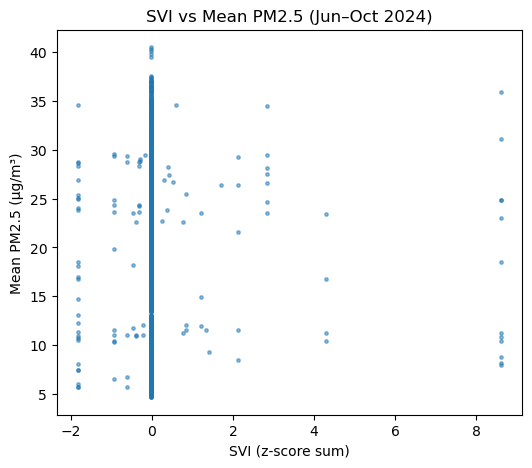

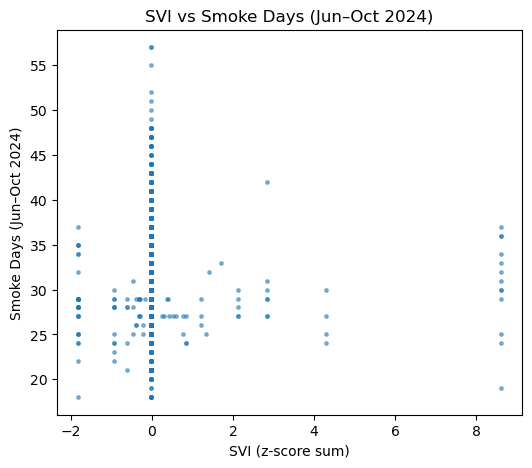


Saved: /Users/Shared/blueleaflabs/heatshield/results/final_grid_equity_2024Q3_CA.parquet


In [7]:
# === HeatShield | Join ACS equity (GeoParquet) to grid metrics with flexible column matching ===

import os, glob, numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# Paths
ACS_PATH   = "results/acs_2023_ca_centroids_merged_3310.parquet"  # from your preprocessing step
GRID_PATH  = "results/grid_3000m_CA_epsg3310.parquet"

def _find_final_parquet():
    cands = []
    if "out_dir" in globals().get("CONFIG", {}):
        cands += glob.glob(os.path.join(CONFIG["out_dir"], "final_daily_grid_3000m*.parquet"))
    cands += glob.glob("results/final_daily_grid_3000m*.parquet")
    cands = [p for p in cands if os.path.exists(p)]
    if not cands:
        raise FileNotFoundError("Could not locate final daily parquet (final_daily_grid_3000m*.parquet).")
    return max(cands, key=os.path.getmtime)

FINAL_DAILY_PATH = _find_final_parquet()
print("Using final daily:", FINAL_DAILY_PATH)

# ------------------------------------------------------------------
# 1) Load grid and ACS centroids
grid = gpd.read_parquet(GRID_PATH)
assert grid.crs and grid.crs.to_epsg() == 3310, "Grid must be EPSG:3310"
assert "grid_id" in grid.columns, "Grid must have 'grid_id'"

g_acs = gpd.read_parquet(ACS_PATH)
if g_acs.crs is None:
    # assume they are 3310 as saved; if not, set explicitly
    g_acs = g_acs.set_crs(3310)
elif g_acs.crs.to_epsg() != 3310:
    g_acs = g_acs.to_crs(3310)

# ---- Flexible column resolution
cols = list(g_acs.columns)
lower_map = {c.lower(): c for c in cols}

def _resolve(candidates):
    # find the first candidate present (case-insensitive)
    for cand in candidates:
        if cand in cols: return cand
        lc = cand.lower()
        if lc in lower_map: return lower_map[lc]
    return None

INCOME_COL  = _resolve(["median_income","income","med_income","household_income_median"])
ELDERLY_COL = _resolve(["percent_elderly","pct_elderly","elderly_percent","pct_65_plus","share_65plus","pct_over_65"])
POVERTY_COL = _resolve(["percent_below_poverty","pct_below_poverty","pct_poverty","poverty_percent","poverty_pct"])

if "GEOID" not in g_acs.columns:
    raise ValueError("ACS parquet must contain 'GEOID' (built in the preprocessing step).")

missing = []
if INCOME_COL is None:  missing.append("median_income (or income alias)")
if ELDERLY_COL is None: missing.append("percent_elderly (or alias)")
if POVERTY_COL is None: missing.append("percent_below_poverty (or alias)")
if missing:
    raise ValueError(f"ACS parquet is missing required socio columns or aliases: {missing}\n"
                     f"Available columns: {cols}")

# Normalize to standard names for downstream
g_acs = g_acs.rename(columns={
    INCOME_COL:  "median_income",
    ELDERLY_COL: "percent_elderly",
    POVERTY_COL: "percent_below_poverty",
})

# ------------------------------------------------------------------
# 2) Spatial join: assign ACS centroid to containing grid cell
joined = gpd.sjoin(
    gpd.GeoDataFrame(geometry=grid.geometry, data=grid[["grid_id"]], crs=3310),
    g_acs[["GEOID","median_income","percent_elderly","percent_below_poverty","geometry"]],
    how="right",
    predicate="contains"
)[["grid_id","GEOID","median_income","percent_elderly","percent_below_poverty"]]

# Average within cell (if multiple tracts fall inside)
tract_to_grid = (
    joined.groupby("grid_id", as_index=False)
          .agg({
              "median_income":"mean",
              "percent_elderly":"mean",
              "percent_below_poverty":"mean",
          })
          .rename(columns={
              "median_income":"income",
              "percent_elderly":"pct_elderly",
              "percent_below_poverty":"pct_poverty"
          })
)

# ------------------------------------------------------------------
# 3) Social Vulnerability Index (SVI)
def _z(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) else 1.0)

tract_to_grid["z_poverty"]  = _z(tract_to_grid["pct_poverty"])
tract_to_grid["z_elderly"]  = _z(tract_to_grid["pct_elderly"])
tract_to_grid["z_income_r"] = _z(-tract_to_grid["income"])  # lower income = higher vulnerability

tract_to_grid["SVI"] = tract_to_grid[["z_poverty","z_elderly","z_income_r"]].sum(axis=1)
tract_to_grid["SVI_pct"] = tract_to_grid["SVI"].rank(pct=True) * 100

# ------------------------------------------------------------------
# 4) Load final daily environmental dataset and summarize per grid
env = pd.read_parquet(FINAL_DAILY_PATH)
env["date"] = pd.to_datetime(env["date"], errors="coerce").dt.date.astype(str)
DATE_FROM, DATE_TO = "2024-06-01", "2024-10-31"
env = env[(env["date"] >= DATE_FROM) & (env["date"] <= DATE_TO)]

def has(c): return c in env.columns
agg_dict = {}

if has("pm25"): agg_dict["pm25"] = "mean"
if has("pm25_airnow"): agg_dict["pm25_airnow"] = "mean"
if has("pm25_aqs"): agg_dict["pm25_aqs"] = "mean"

for c in ["tavg_c_value","tmax_c_value","tmin_c_value"]:
    if has(c): agg_dict[c] = "mean"

if has("prcp_mm"): agg_dict["prcp_mm"] = "sum"
for c in ["fire_count_in","fire_buffer_count"]:
    if has(c): agg_dict[c] = "sum"
if has("nearest_fire_km"): agg_dict["nearest_fire_km"] = "mean"

if has("smoke_frac"):
    agg_dict["smoke_frac"] = "mean"
    env["_smoke_day"] = (env["smoke_frac"].fillna(0) > 0).astype(int)

per_grid = env.groupby("grid_id", as_index=False).agg(agg_dict)
if "_smoke_day" in env.columns:
    smoke_days = env.groupby("grid_id", as_index=False)["_smoke_day"].sum().rename(columns={"_smoke_day":"smoke_days"})
    per_grid = per_grid.merge(smoke_days, on="grid_id", how="left")

# ------------------------------------------------------------------
# 5) Join SVI → environmental summaries
final = per_grid.merge(
    tract_to_grid[["grid_id","income","pct_elderly","pct_poverty","SVI","SVI_pct"]],
    on="grid_id", how="left"
)

print("\n=== Joined grid metrics + equity ===")
print("Rows:", len(final), "| Columns:", len(final.columns))
print(final.head(3))

# ------------------------------------------------------------------
# 6) Correlations & comparisons
def _corrsafe(df, x, y):
    if x in df.columns and y in df.columns:
        return df[[x, y]].dropna().corr().iloc[0, 1]
    return np.nan

print("\nCorrelations with SVI (higher = more vulnerable):")
for k in ["pm25","pm25_airnow","pm25_aqs","tavg_c_value","tmax_c_value","smoke_frac","smoke_days"]:
    if k in final.columns:
        r = _corrsafe(final, "SVI", k)
        if not np.isnan(r):
            print(f"  SVI vs {k:>12}: {r:+.3f}")

q10, q90 = final["SVI"].quantile(0.10), final["SVI"].quantile(0.90)
low, high = final[final["SVI"] <= q10], final[final["SVI"] >= q90]

def _mean_cols(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].mean().round(3)

compare_cols = ["pm25","pm25_airnow","pm25_aqs","tavg_c_value","tmax_c_value",
                "smoke_frac","smoke_days","prcp_mm","fire_count_in"]

print("\nMean metrics (bottom 10% SVI):")
print(_mean_cols(low, compare_cols))
print("\nMean metrics (top 10% SVI):")
print(_mean_cols(high, compare_cols))

# ------------------------------------------------------------------
# 7) Quick scatterplots
plt.figure(figsize=(6,5))
if "pm25" in final.columns:
    plt.scatter(final["SVI"], final["pm25"], s=6, alpha=0.5)
    plt.xlabel("SVI (z-score sum)"); plt.ylabel("Mean PM2.5 (µg/m³)")
    plt.title("SVI vs Mean PM2.5 (Jun–Oct 2024)")
    plt.show()

plt.figure(figsize=(6,5))
if "smoke_days" in final.columns:
    plt.scatter(final["SVI"], final["smoke_days"], s=6, alpha=0.5)
    plt.xlabel("SVI (z-score sum)"); plt.ylabel("Smoke Days (Jun–Oct 2024)")
    plt.title("SVI vs Smoke Days (Jun–Oct 2024)")
    plt.show()

# ------------------------------------------------------------------
# 8) Save ready-to-map output
OUT_EQUITY = os.path.join(CONFIG.get("out_dir", "results"), "final_grid_equity_2024Q3_CA.parquet")
final.to_parquet(OUT_EQUITY, index=False)
print("\nSaved:", OUT_EQUITY)

Using equity file: results/final_grid_equity_2024Q3_CA.parquet

SVI–EEI correlation (statewide): r = +0.010

Share of grid cells by class (%):
burden_class
Neither                    73.5
High exposure only         24.6
High vulnerability only     1.5
Double burden               0.4


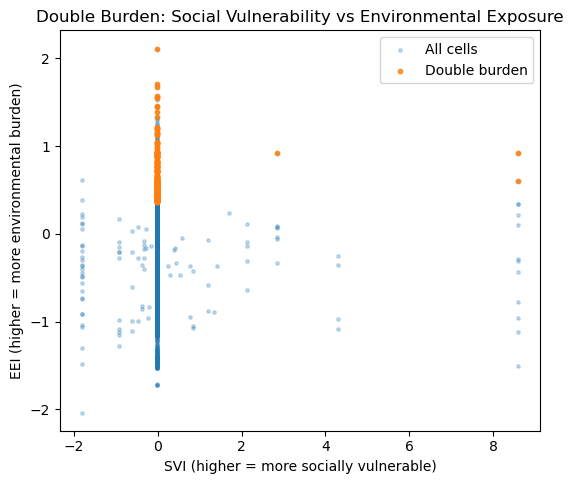

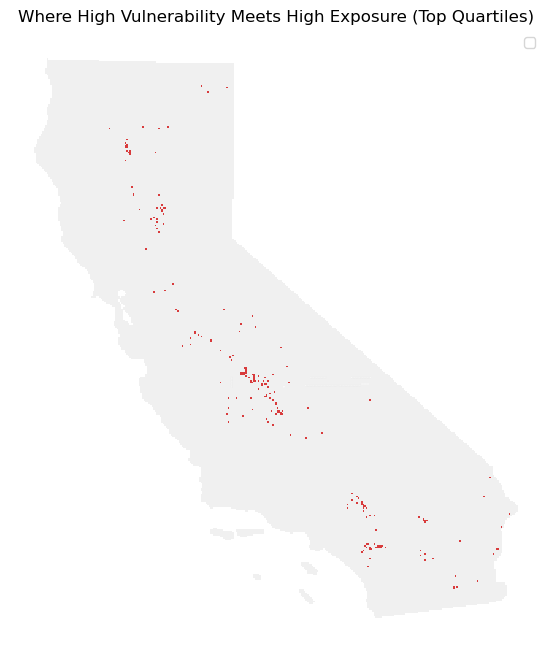


Saved: results/equity_double_burden_2024Q3_CA.parquet

Explainer:
We convert each environmental metric (PM2.5, max/avg temperature, and smoke burden) into a standard z-score so they’re on the same scale, then average those z-scores to get an Environmental Exposure Index (EEI) —
higher EEI means more environmental stress. We compare EEI to the Social Vulnerability Index (SVI), which rises with poverty and elderly share and falls with income. Cells in the top 25% for both SVI and EEI are labeled “double burden”: these are places where vulnerable communities are simultaneously facing higher environmental hazards. The scatter shows the overall relationship (r above), and the map highlights exactly where double-burden cells are located across California.



In [12]:
# === HeatShield | "Double Burden" WOW analysis: SVI × EEI (simple & explainable) ===
# Inputs:
#   - results/final_grid_equity_2024Q3_CA.parquet   (from previous join step; has SVI + env summaries)
#   - results/grid_3000m_CA_epsg3310.parquet        (grid geometry, EPSG:3310)
# Outputs:
#   - results/equity_double_burden_2024Q3_CA.parquet
#   - (plots) scatter & map shown inline

import os, glob, numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

# ---------------- Paths & helpers ----------------
RES_DIR = "results"
os.makedirs(RES_DIR, exist_ok=True)

def _find_equity():
    # prefer the canonical name we saved earlier
    cands = [
        os.path.join(RES_DIR, "final_grid_equity_2024Q3_CA.parquet"),
        *glob.glob(os.path.join(RES_DIR, "final_grid_equity_*.parquet")),
        *glob.glob(os.path.join(globals().get("CONFIG", {}).get("out_dir","results"), "final_grid_equity_*.parquet")),
    ]
    cands = [p for p in cands if os.path.exists(p)]
    if not cands: raise FileNotFoundError("Could not find final_grid_equity_* parquet.")
    return max(cands, key=os.path.getmtime)

EQUITY_PATH = _find_equity()
GRID_PATH   = os.path.join(RES_DIR, "grid_3000m_CA_epsg3310.parquet")
print("Using equity file:", EQUITY_PATH)

# ---------------- Load data ----------------
df = pd.read_parquet(EQUITY_PATH)
grid = gpd.read_parquet(GRID_PATH)
assert grid.crs and grid.crs.to_epsg()==3310, "Grid must be EPSG:3310"

# ---------------- Build EEI (Environmental Exposure Index) ----------------
# We keep this SIMPLE:
#  - PM2.5 (mean across the season)
#  - Temperature (use tmax if available, else tavg)
#  - Smoke burden (smoke_days if available, else mean smoke_frac)
# EEI = mean(z of available components). Higher EEI = worse exposure.

# Pick temperature column
temp_col = "tmax_c_value" if "tmax_c_value" in df.columns else ("tavg_c_value" if "tavg_c_value" in df.columns else None)
smoke_count_col = "smoke_days" if "smoke_days" in df.columns else None
smoke_frac_col  = "smoke_frac" if "smoke_frac" in df.columns else None

components = []
if "pm25" in df.columns: components.append(("pm25", +1))
if temp_col:             components.append((temp_col, +1))
if smoke_count_col:      components.append((smoke_count_col, +1))
elif smoke_frac_col:     components.append((smoke_frac_col, +1))

if not components:
    raise ValueError("No environmental columns found to compute EEI (need at least one of pm25, tmax/tavg, smoke_days/smoke_frac).")

def _z(s):
    s = pd.to_numeric(s, errors="coerce")
    std = s.std(ddof=0)
    return (s - s.mean()) / (std if std else 1.0)

for col, sign in components:
    df[f"z_{col}"] = _z(df[col]) * sign

zcols = [f"z_{c}" for c,_ in components]
df["EEI"] = df[zcols].mean(axis=1)

# ---------------- Sanity checks ----------------
need = ["grid_id", "EEI", "SVI"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Make sure your previous join created SVI and env summaries.")

# Correlation (headline number)
corr = df[["SVI","EEI"]].dropna().corr().iloc[0,1]
print(f"\nSVI–EEI correlation (statewide): r = {corr:+.3f}")

# ---------------- Classify “double burden” ----------------
# Define high = top quartile (75th percentile). Adjust to taste.
eei_thr = df["EEI"].quantile(0.75)
svi_thr = df["SVI"].quantile(0.75)

df["high_EEI"] = (df["EEI"] >= eei_thr).astype(int)
df["high_SVI"] = (df["SVI"] >= svi_thr).astype(int)

def _class_row(r):
    if r["high_EEI"]==1 and r["high_SVI"]==1: return "Double burden"
    if r["high_EEI"]==1 and r["high_SVI"]==0: return "High exposure only"
    if r["high_EEI"]==0 and r["high_SVI"]==1: return "High vulnerability only"
    return "Neither"

df["burden_class"] = df[["high_EEI","high_SVI"]].apply(_class_row, axis=1)

share = df["burden_class"].value_counts(normalize=True).mul(100).round(1)
print("\nShare of grid cells by class (%):")
print(share.to_string())

# ---------------- Scatter: SVI vs EEI (simple & explainable) ----------------
plt.figure(figsize=(6.2,5.2))
# light base
plt.scatter(df["SVI"], df["EEI"], s=6, alpha=0.25, label="All cells")
# highlight double burden
dbl = df[df["burden_class"]=="Double burden"]
if not dbl.empty:
    plt.scatter(dbl["SVI"], dbl["EEI"], s=10, alpha=0.8, label="Double burden")
plt.xlabel("SVI (higher = more socially vulnerable)")
plt.ylabel("EEI (higher = more environmental burden)")
plt.title("Double Burden: Social Vulnerability vs Environmental Exposure")
plt.legend()
plt.show()

# ---------------- Map: highlight double burden cells ----------------
g = grid[["grid_id","geometry"]].merge(df[["grid_id","burden_class"]], on="grid_id", how="left")
g = g.set_crs(3310)

fig, ax = plt.subplots(figsize=(7.5,8))
# base
g.plot(ax=ax, color="#eaeaea", linewidth=0, alpha=0.7)
# single-color overlay for clarity
g[g["burden_class"]=="Double burden"].plot(ax=ax, color="#d62728", linewidth=0, alpha=0.9, label="Double burden")
ax.set_axis_off()
ax.set_title("Where High Vulnerability Meets High Exposure (Top Quartiles)")
ax.legend()
plt.show()

# ---------------- Save ready-to-map output ----------------
OUT = os.path.join(RES_DIR, "equity_double_burden_2024Q3_CA.parquet")
keep_cols = ["grid_id","SVI","EEI","burden_class","high_SVI","high_EEI"] + [c for c,_ in components] + zcols
df[keep_cols].to_parquet(OUT, index=False)
print("\nSaved:", OUT)

# ---------------- Friendly one-paragraph explainer you can reuse ----------------
print("""
Explainer:
We convert each environmental metric (PM2.5, max/avg temperature, and smoke burden) into a standard z-score so they’re on the same scale, then average those z-scores to get an Environmental Exposure Index (EEI) —
higher EEI means more environmental stress. We compare EEI to the Social Vulnerability Index (SVI), which rises with poverty and elderly share and falls with income. Cells in the top 25% for both SVI and EEI are labeled “double burden”: these are places where vulnerable communities are simultaneously facing higher environmental hazards. The scatter shows the overall relationship (r above), and the map highlights exactly where double-burden cells are located across California.
""")

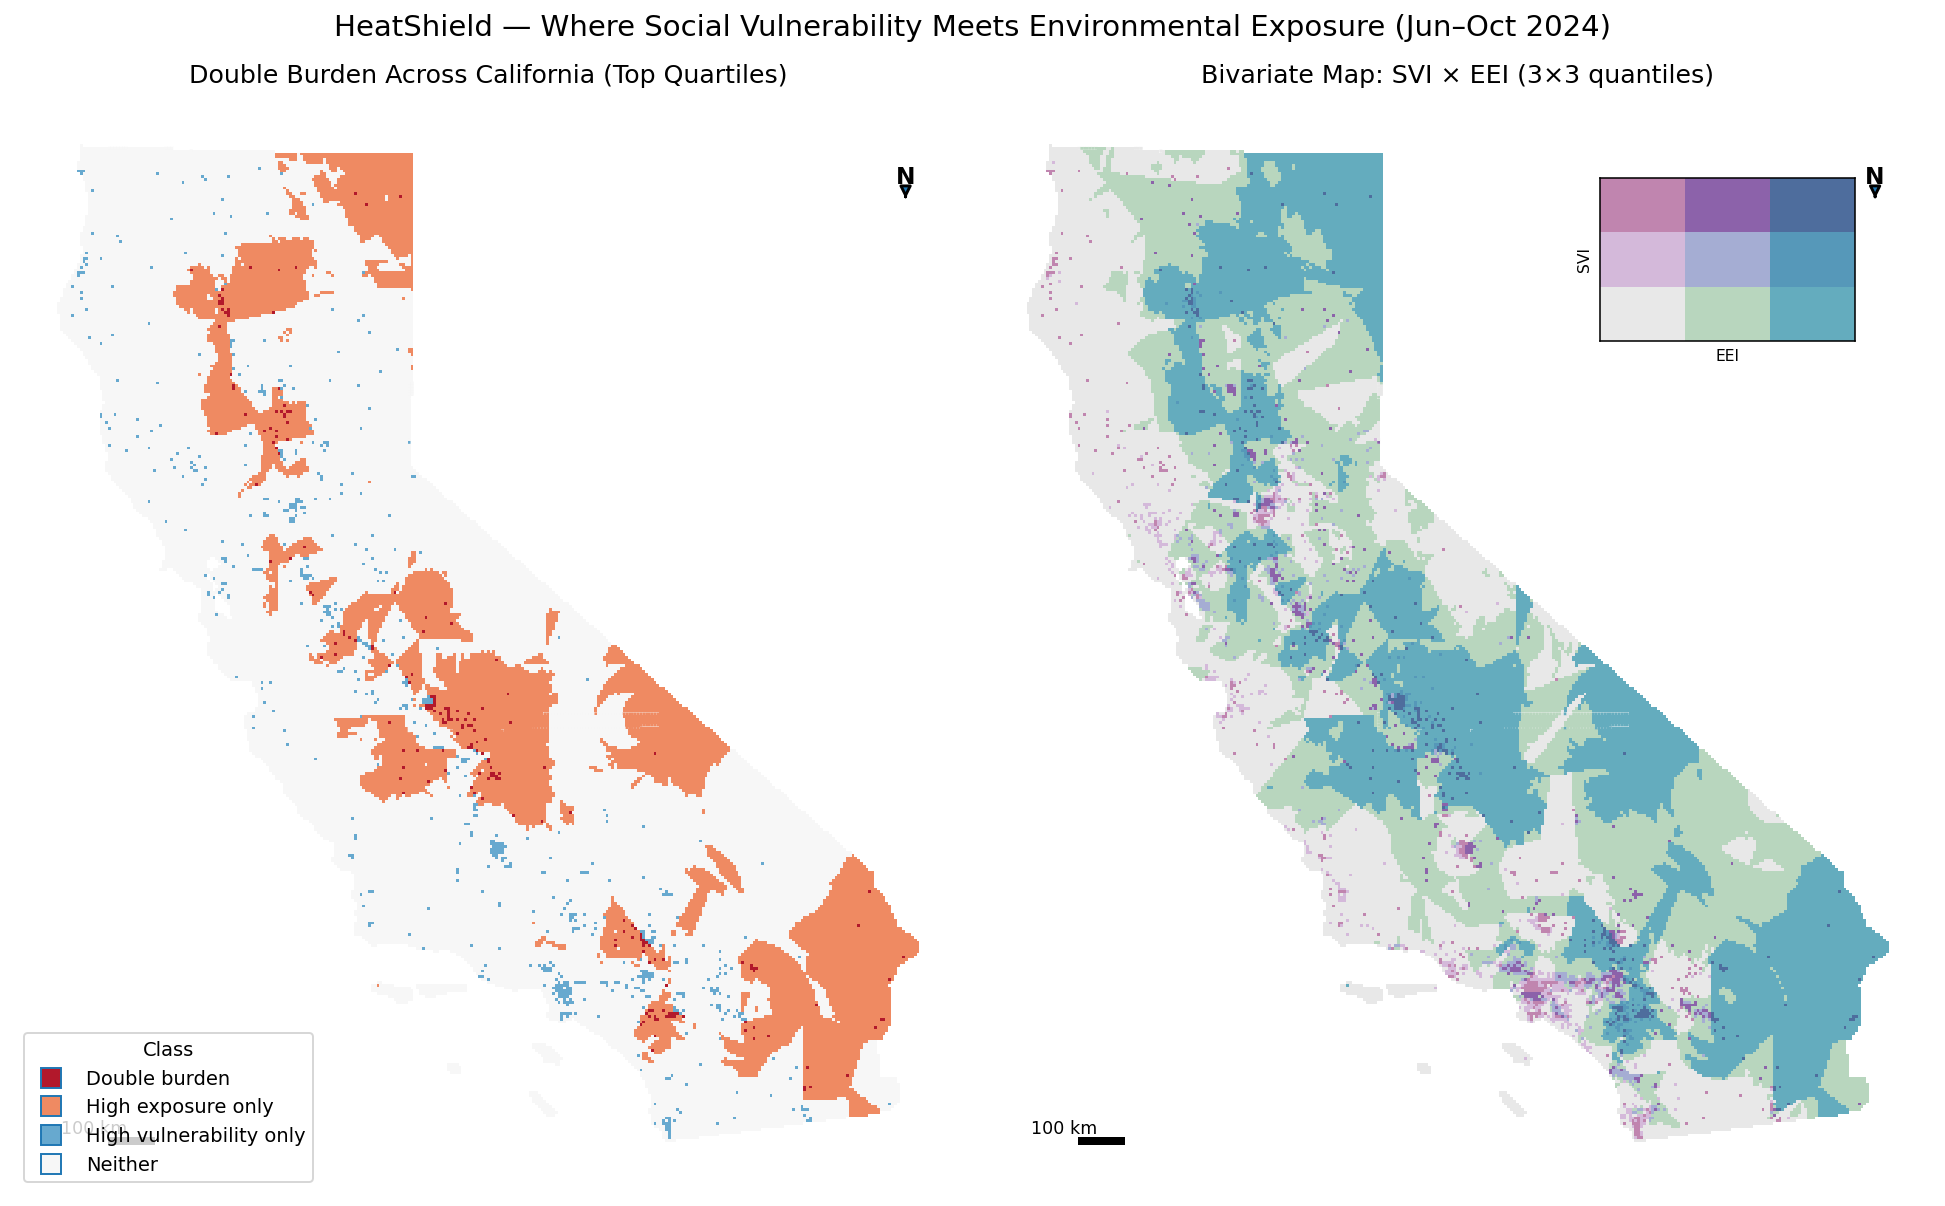

Note: Bivariate bins used → SVI: 3 levels, EEI: 3 levels (auto-fallback if low variance).


In [14]:
# === HeatShield | Robust rich map (auto 3×3 → fallback 2×2; rebuilds EEI/burden_class if missing) ===

import os, numpy as np, pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

RES_DIR = "results"
GRID_PQ   = os.path.join(RES_DIR, "grid_3000m_CA_epsg3310.parquet")
BURDEN_PQ = os.path.join(RES_DIR, "equity_double_burden_2024Q3_CA.parquet")  # expects grid_id, SVI, EEI, burden_class (but we can rebuild)

# --- Load
grid = gpd.read_parquet(GRID_PQ)
assert grid.crs is not None and int(grid.crs.to_epsg()) == 3310, "Grid must be EPSG:3310"

df = pd.read_parquet(BURDEN_PQ)

# --- Preflight: rebuild EEI and burden_class if missing
def _z(s):
    s = pd.to_numeric(s, errors="coerce")
    std = s.std(ddof=0)
    return (s - s.mean()) / (std if std else 1.0)

def ensure_eei_and_burden(df):
    need_cols = {"SVI"}
    missing = need_cols - set(df.columns)
    if missing:
        raise ValueError(f"Missing column(s) in equity table: {missing}. Make sure SVI exists in {BURDEN_PQ}.")

    # EEI: rebuild if absent
    if "EEI" not in df.columns or df["EEI"].isna().all():
        # Try to rebuild from available inputs and their z-scores if present
        comp_cols = []
        if "pm25" in df.columns: comp_cols.append("pm25")
        if "tmax_c_value" in df.columns: comp_cols.append("tmax_c_value")
        elif "tavg_c_value" in df.columns: comp_cols.append("tavg_c_value")
        if "smoke_days" in df.columns: comp_cols.append("smoke_days")
        elif "smoke_frac" in df.columns: comp_cols.append("smoke_frac")

        if not comp_cols and {"z_pm25","z_tmax_c_value","z_tavg_c_value","z_smoke_days","z_smoke_frac"}.isdisjoint(df.columns) is False:
            # Fallback: use existing z_* columns
            zcols = [c for c in ["z_pm25","z_tmax_c_value","z_tavg_c_value","z_smoke_days","z_smoke_frac"] if c in df.columns]
            df["EEI"] = df[zcols].mean(axis=1)
        else:
            # Fresh z-scores from raw
            zcols = []
            for c in comp_cols:
                df[f"z_{c}"] = _z(df[c])
                zcols.append(f"z_{c}")
            if zcols:
                df["EEI"] = df[zcols].mean(axis=1)
            else:
                raise ValueError("Cannot compute EEI: no environmental columns (pm25, tmax/tavg, smoke_days/smoke_frac) found.")

    # burden_class: rebuild if absent
    if "burden_class" not in df.columns or df["burden_class"].isna().all():
        eei_thr = df["EEI"].quantile(0.75)
        svi_thr = df["SVI"].quantile(0.75)
        df["high_EEI"] = (df["EEI"] >= eei_thr).astype(int)
        df["high_SVI"] = (df["SVI"] >= svi_thr).astype(int)
        def _class_row(r):
            if r["high_EEI"]==1 and r["high_SVI"]==1: return "Double burden"
            if r["high_EEI"]==1 and r["high_SVI"]==0: return "High exposure only"
            if r["high_EEI"]==0 and r["high_SVI"]==1: return "High vulnerability only"
            return "Neither"
        df["burden_class"] = df[["high_EEI","high_SVI"]].apply(_class_row, axis=1)

    return df

df = ensure_eei_and_burden(df)

# Clean numeric columns
for c in ["SVI","EEI"]:
    df[c] = pd.to_numeric(df[c], errors="coerce").replace([np.inf, -np.inf], np.nan)

# Join geometry
g = grid[["grid_id","geometry"]].merge(df, on="grid_id", how="left")
if g.crs is None:
    g = g.set_crs(3310)

# --- Quantile binning with graceful fallback
def quantile_bins(s, q=3):
    s = pd.to_numeric(s, errors="coerce")
    if s.dropna().nunique() <= 1:
        return pd.Series(np.zeros(len(s), dtype=int)), 1
    try:
        binned, _ = pd.qcut(s, q=q, labels=False, retbins=True, duplicates="drop")
        if binned.notna().any():
            k = int(binned.max() + 1)
            return binned.fillna(0).astype(int), k
        else:
            binned, _ = pd.qcut(s, q=2, labels=False, retbins=True, duplicates="drop")
            return binned.fillna(0).astype(int), 2
    except ValueError:
        binned = (s > s.median()).astype(int)
        return binned.fillna(0).astype(int), 2

g["SVI_q"], n_svi = quantile_bins(g["SVI"], q=3)
g["EEI_q"], n_eei = quantile_bins(g["EEI"], q=3)

# --- Bivariate palette
def bivariate_palette(n_rows, n_cols):
    if (n_rows, n_cols) == (3, 3):
        colors = [
            "#e8e8e8", "#b8d6be", "#64acbe",
            "#d4b9da", "#a5add3", "#5698b9",
            "#c085af", "#8c62aa", "#4e6d9d"
        ]
    elif (n_rows, n_cols) == (2, 2):
        colors = ["#e8e8e8", "#67a9cf",
                  "#ef8a62", "#4e6d9d"]
    else:
        # Generic grayscale
        colors = [plt.cm.Greys(0.3 + 0.6*i/((n_rows*n_cols)-1)) for i in range(n_rows*n_cols)]
    return {(r*n_cols + c): colors[r*n_cols + c] for r in range(n_rows) for c in range(n_cols)}

bivar_cmap = bivariate_palette(n_svi, n_eei)
g["bivar_ix"] = g["SVI_q"]*n_eei + g["EEI_q"]
g["bivar_color"] = g["bivar_ix"].map(bivar_cmap)

# --- Double-burden palette
class_order = ["Double burden", "High exposure only", "High vulnerability only", "Neither"]
g["burden_class"] = pd.Categorical(g["burden_class"], categories=class_order, ordered=True)
palette = {
    "Double burden": "#b2182b",
    "High exposure only": "#ef8a62",
    "High vulnerability only": "#67a9cf",
    "Neither": "#f7f7f7"
}

# --- Helpers: scalebar & north arrow
def add_scalebar(ax, length_km=100, loc="lower left", pad=50000):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    if loc == "lower left":
        x0 = xmin + pad; y0 = ymin + pad
    elif loc == "lower right":
        x0 = xmax - pad - length_km*1000; y0 = ymin + pad
    elif loc == "upper left":
        x0 = xmin + pad; y0 = ymax - pad - 20000
    else:
        x0 = xmax - pad - length_km*1000; y0 = ymax - pad - 20000
    ax.add_patch(Rectangle((x0, y0), length_km*1000, 8000, facecolor="black"))
    ax.add_patch(Rectangle((x0, y0), (length_km*1000)/2, 8000, facecolor="white"))
    ax.text(x0, y0+12000, f"{length_km} km", fontsize=9)

def add_north_arrow(ax):
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    x = xmax - (xmax - xmin)*0.06
    y = ymax - (ymax - ymin)*0.12
    ax.annotate('N', xy=(x, y+25000), xytext=(x, y+45000), ha='center',
                fontsize=12, fontweight='bold',
                arrowprops=dict(arrowstyle="-|>", linewidth=1.5))

# --- Figure
fig, axes = plt.subplots(1, 2, figsize=(14, 9), dpi=140)

# Panel A
ax = axes[0]
g.plot(ax=ax, color="#f0f0f0", linewidth=0, alpha=0.8)
for cls in class_order:
    sub = g[g["burden_class"] == cls]
    if not sub.empty:
        sub.plot(ax=ax, color=palette[cls], linewidth=0)
ax.set_axis_off()
ax.set_title("Double Burden Across California (Top Quartiles)", fontsize=13)
add_scalebar(ax, length_km=100); add_north_arrow(ax)

handles = [plt.Line2D([0],[0], marker='s', linestyle='None', markersize=10,
                       markerfacecolor=palette[c], label=c) for c in class_order]
ax.legend(handles=handles, title="Class", loc="lower left", frameon=True)

# Panel B
ax2 = axes[1]
g.plot(ax=ax2, color="#f0f0f0", linewidth=0, alpha=0.8)
g.dropna(subset=["bivar_color"]).plot(ax=ax2, color=g.dropna(subset=["bivar_color"])["bivar_color"], linewidth=0)
ax2.set_axis_off()
ax2.set_title(f"Bivariate Map: SVI × EEI ({n_svi}×{n_eei} quantiles)", fontsize=13)
add_scalebar(ax2, length_km=100); add_north_arrow(ax2)

# Inset legend for bivariate
# legend_ax = fig.add_axes([0.79, 0.18, 0.12, 0.12])
# Inset legend for bivariate (top right)
legend_ax = fig.add_axes([0.82, 0.72, 0.13, 0.13])  # [left, bottom, width, height]
legend_ax.set_frame_on(True)
legend_ax.set_xticks([]); legend_ax.set_yticks([])
for r in range(n_svi):
    for c in range(n_eei):
        idx = r*n_eei + c
        x0 = c / n_eei
        y0 = r / n_svi
        width = 1 / n_eei
        height = 1 / n_svi
        legend_ax.add_patch(
            Rectangle(
                (x0, y0),
                width,
                height,
                facecolor=bivar_cmap.get(idx, "#cccccc"),
                transform=legend_ax.transAxes,
                edgecolor="none"
            )
        )
legend_ax.set_xlim(0,1); legend_ax.set_ylim(0,1)
legend_ax.set_xlabel("EEI", fontsize=8)
legend_ax.set_ylabel("SVI", fontsize=8)

plt.suptitle("HeatShield — Where Social Vulnerability Meets Environmental Exposure (Jun–Oct 2024)", fontsize=15)
plt.tight_layout()
plt.show()

print(f"Note: Bivariate bins used → SVI: {n_svi} levels, EEI: {n_eei} levels (auto-fallback if low variance).")

In [15]:
for col in ["SVI", "EEI"]:
    s = pd.to_numeric(g[col], errors="coerce")
    print(f"\n{col}:")
    print("  min =", round(s.min(), 3))
    print("  max =", round(s.max(), 3))
    print("  mean =", round(s.mean(), 3))
    print("  std =", round(s.std(ddof=0), 3))
    print("  tercile cutpoints:", [round(x, 3) for x in s.quantile([0.33, 0.66])])


SVI:
  min = -1.82
  max = 8.607
  mean = 0.0
  std = 0.594
  tercile cutpoints: [-0.03, -0.03]

EEI:
  min = -2.124
  max = 9.917
  mean = 0.021
  std = 0.634
  tercile cutpoints: [-0.243, 0.238]


Top 5% thresholds  SVI ≥ -0.03,  EEI ≥ 0.85
Total outlier cells: 8

Top outlier cells (showing up to 20):
            grid_id       GEOID         county       SVI      EEI
CA3310_3000_155_128 06107004000         Tulare  8.607404 0.920206
CA3310_3000_136_148 06019007002         Fresno  2.849481 0.923888
 CA3310_3000_287_88 06071010700 San Bernardino -0.029229 0.881266
CA3310_3000_144_149 06019006501         Fresno -0.029247 1.389791
CA3310_3000_132_157 06019005408         Fresno -0.029258 0.893279
CA3310_3000_147_149 06107000202         Tulare -0.029260 1.452670
CA3310_3000_145_151 06019006502         Fresno -0.029300 1.557734
 CA3310_3000_81_254 06007003200          Butte -0.029314 0.864634


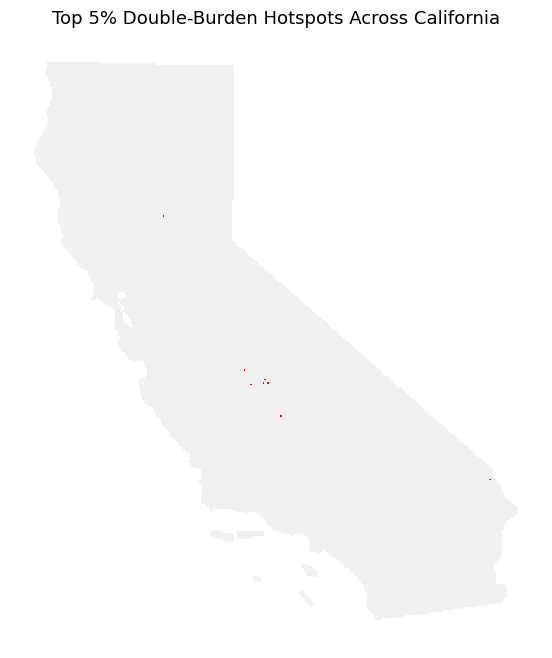

In [29]:
# === Top 5% Double-Burden Grid Cells with County + Tract Map ===
import geopandas as gpd, pandas as pd, numpy as np, matplotlib.pyplot as plt

OUTLIER_PCT = 0.95
ACS_PATH = "results/acs_2023_ca_centroids_merged_3310.parquet"

# --- CA county FIPS lookup ---
CA_COUNTY_TO_FIPS = {
    "ALAMEDA":"001","ALPINE":"003","AMADOR":"005","BUTTE":"007","CALAVERAS":"009","COLUSA":"011",
    "CONTRA COSTA":"013","DEL NORTE":"015","EL DORADO":"017","FRESNO":"019","GLENN":"021","HUMBOLDT":"023",
    "IMPERIAL":"025","INYO":"027","KERN":"029","KINGS":"031","LAKE":"033","LASSEN":"035","LOS ANGELES":"037",
    "MADERA":"039","MARIN":"041","MARIPOSA":"043","MENDOCINO":"045","MERCED":"047","MODOC":"049",
    "MONO":"051","MONTEREY":"053","NAPA":"055","NEVADA":"057","ORANGE":"059","PLACER":"061","PLUMAS":"063",
    "RIVERSIDE":"065","SACRAMENTO":"067","SAN BENITO":"069","SAN BERNARDINO":"071","SAN DIEGO":"073",
    "SAN FRANCISCO":"075","SAN JOAQUIN":"077","SAN LUIS OBISPO":"079","SAN MATEO":"081","SANTA BARBARA":"083",
    "SANTA CLARA":"085","SANTA CRUZ":"087","SHASTA":"089","SIERRA":"091","SISKIYOU":"093","SOLANO":"095",
    "SONOMA":"097","STANISLAUS":"099","SUTTER":"101","TEHAMA":"103","TRINITY":"105","TULARE":"107",
    "TUOLUMNE":"109","VENTURA":"111","YOLO":"113","YUBA":"115"
}
FIPS_TO_COUNTY = {v: k.title() for k, v in CA_COUNTY_TO_FIPS.items()}

# --- Data ---
df = g[["grid_id","SVI","EEI","geometry"]].copy()
svi_thr, eei_thr = df["SVI"].quantile(OUTLIER_PCT), df["EEI"].quantile(OUTLIER_PCT)
outliers = df[(df["SVI"] >= svi_thr) & (df["EEI"] >= eei_thr)].copy()
outliers["cell_centroid"] = outliers.geometry.centroid

print(f"Top 5% thresholds  SVI ≥ {svi_thr:.2f},  EEI ≥ {eei_thr:.2f}")
print(f"Total outlier cells: {len(outliers)}")

# --- ACS join & county derivation ---
acs = gpd.read_parquet(ACS_PATH).to_crs(df.crs)
acs = acs[["GEOID","geometry"]].copy()
acs["county_fips3"] = acs["GEOID"].astype(str).str.slice(2,5)
acs["county"] = acs["county_fips3"].map(FIPS_TO_COUNTY).fillna("Unknown")

cand = gpd.sjoin(
    acs,
    outliers[["grid_id","geometry"]],
    how="inner",
    predicate="within"
).rename(columns={"index_right":"_grid_idx"})

if not cand.empty:
    cell_cents = outliers[["grid_id","cell_centroid"]].set_index("grid_id")
    cand = cand.join(cell_cents, on="grid_id")
    cand["dist_to_cell_centroid"] = cand.geometry.distance(cand["cell_centroid"])
    idx = cand.groupby("grid_id")["dist_to_cell_centroid"].idxmin()
    nearest = cand.loc[idx, ["grid_id","GEOID","county"]].reset_index(drop=True)
else:
    nearest = pd.DataFrame(columns=["grid_id","GEOID","county"])

final = outliers.merge(nearest, on="grid_id", how="left").sort_values(["SVI","EEI"], ascending=False)
cols = ["grid_id","GEOID","county","SVI","EEI"]
print("\nTop outlier cells (showing up to 20):")
print(final[cols].head(20).to_string(index=False))

# --- Map ---
base = gpd.GeoDataFrame(geometry=g.geometry, crs=g.crs)
ax = base.plot(color="#f0f0f0", figsize=(8,8))
final.plot(ax=ax, color="red", markersize=7)
ax.set_axis_off()
ax.set_title("Top 5% Double-Burden Hotspots Across California", fontsize=13)
plt.show()

Using final daily: /Users/Shared/blueleaflabs/heatshield/results/final_daily_grid_3000m_20240601_20241031.parquet
Low SVI cells: 353 | High SVI cells: 353
Days high-SVI > low-SVI: PM2.5 41/153, Tmax 148/153


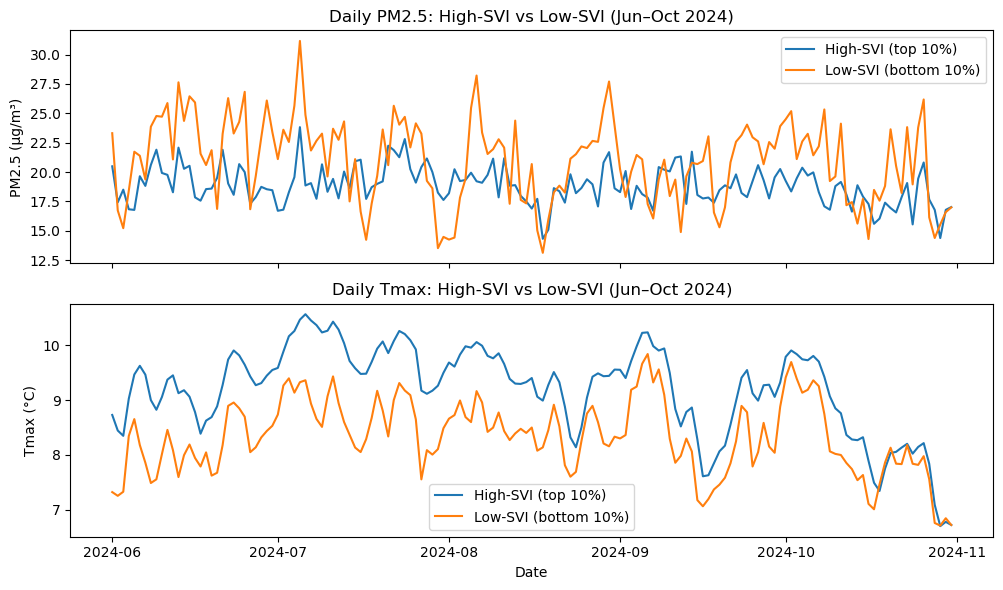

In [30]:
# === HeatShield | Temporal Hazard Burden by Vulnerability (Top vs Bottom SVI Decile) ===
import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt

RES_DIR = "results"
EQUITY_PQ = os.path.join(RES_DIR, "equity_double_burden_2024Q3_CA.parquet")

# Find final-daily parquet (grid × day)
def _find_final_parquet():
    cands = []
    if "CONFIG" in globals() and isinstance(CONFIG, dict) and "out_dir" in CONFIG:
        cands += glob.glob(os.path.join(CONFIG["out_dir"], "final_daily_grid_*_20240601_20241031.parquet"))
        cands += glob.glob(os.path.join(CONFIG["out_dir"], "final_daily_grid_*_2024*.parquet"))
    cands += glob.glob(os.path.join(RES_DIR, "final_daily_grid_*_20240601_20241031.parquet"))
    cands += glob.glob(os.path.join(RES_DIR, "final_daily_grid_*_2024*.parquet"))
    if not cands:
        raise FileNotFoundError("final_daily_grid_*_2024*.parquet not found in results/ or CONFIG['out_dir'].")
    return max(cands, key=os.path.getmtime)

FINAL_DAILY = _find_final_parquet()
print("Using final daily:", FINAL_DAILY)

# Load SVI per grid
eq = pd.read_parquet(EQUITY_PQ)[["grid_id","SVI"]].dropna()
# Top / bottom deciles by SVI
q_lo, q_hi = eq["SVI"].quantile(0.10), eq["SVI"].quantile(0.90)
low_ids  = set(eq.loc[eq["SVI"] <= q_lo, "grid_id"])
high_ids = set(eq.loc[eq["SVI"] >= q_hi, "grid_id"])
print(f"Low SVI cells: {len(low_ids)} | High SVI cells: {len(high_ids)}")

# Load daily env
env = pd.read_parquet(FINAL_DAILY)
env["date"] = pd.to_datetime(env["date"], errors="coerce").dt.date.astype(str)
env = env[(env["date"] >= "2024-06-01") & (env["date"] <= "2024-10-31")]

# Pick robust column names
def has(c): return c in env.columns
pm_col   = "pm25" if has("pm25") else ("pm25_aqs" if has("pm25_aqs") else ("pm25_airnow" if has("pm25_airnow") else None))
tmax_col = "tmax_c_value" if has("tmax_c_value") else ("tavg_c_value" if has("tavg_c_value") else None)
if pm_col is None or tmax_col is None:
    raise ValueError(f"Missing required columns. Found PM='{pm_col}', T='{tmax_col}' in {FINAL_DAILY}")

# Split high/low SVI and compute daily means
def _daily_mean(df, col, ids):
    sub = df[df["grid_id"].isin(ids)].copy()
    return sub.groupby("date", as_index=False)[col].mean().rename(columns={col: f"{col}_mean"})

pm_hi  = _daily_mean(env[["grid_id","date",pm_col]], pm_col, high_ids)
pm_lo  = _daily_mean(env[["grid_id","date",pm_col]], pm_col, low_ids)
tx_hi  = _daily_mean(env[["grid_id","date",tmax_col]], tmax_col, high_ids)
tx_lo  = _daily_mean(env[["grid_id","date",tmax_col]], tmax_col, low_ids)

# Merge to one frame
ts = pd.DataFrame({"date": sorted(env["date"].unique())})
ts = ts.merge(pm_hi, on="date", how="left").merge(pm_lo, on="date", how="left", suffixes=("_hi","_lo"))
ts = ts.merge(tx_hi, on="date", how="left").merge(tx_lo, on="date", how="left", suffixes=("_hi","_lo"))

# Diagnostics: count days high>low
pm_hi_col, pm_lo_col = f"{pm_col}_mean_hi", f"{pm_col}_mean_lo"
tx_hi_col, tx_lo_col = f"{tmax_col}_mean_hi", f"{tmax_col}_mean_lo"
n_days = len(ts)
pm_bias_days = int((ts[pm_hi_col] > ts[pm_lo_col]).sum())
tx_bias_days = int((ts[tx_hi_col] > ts[tx_lo_col]).sum())
print(f"Days high-SVI > low-SVI: PM2.5 {pm_bias_days}/{n_days}, Tmax {tx_bias_days}/{n_days}")

# Plot
dates = pd.to_datetime(ts["date"])
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(dates, ts[pm_hi_col], label="High-SVI (top 10%)")
axes[0].plot(dates, ts[pm_lo_col], label="Low-SVI (bottom 10%)")
axes[0].set_ylabel("PM2.5 (µg/m³)")
axes[0].set_title("Daily PM2.5: High-SVI vs Low-SVI (Jun–Oct 2024)")
axes[0].legend()

axes[1].plot(dates, ts[tx_hi_col], label="High-SVI (top 10%)")
axes[1].plot(dates, ts[tx_lo_col], label="Low-SVI (bottom 10%)")
axes[1].set_ylabel("Tmax (°C)")
axes[1].set_title("Daily Tmax: High-SVI vs Low-SVI (Jun–Oct 2024)")
axes[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

Using final daily: /Users/Shared/blueleaflabs/heatshield/results/final_daily_grid_3000m_20240601_20241031.parquet


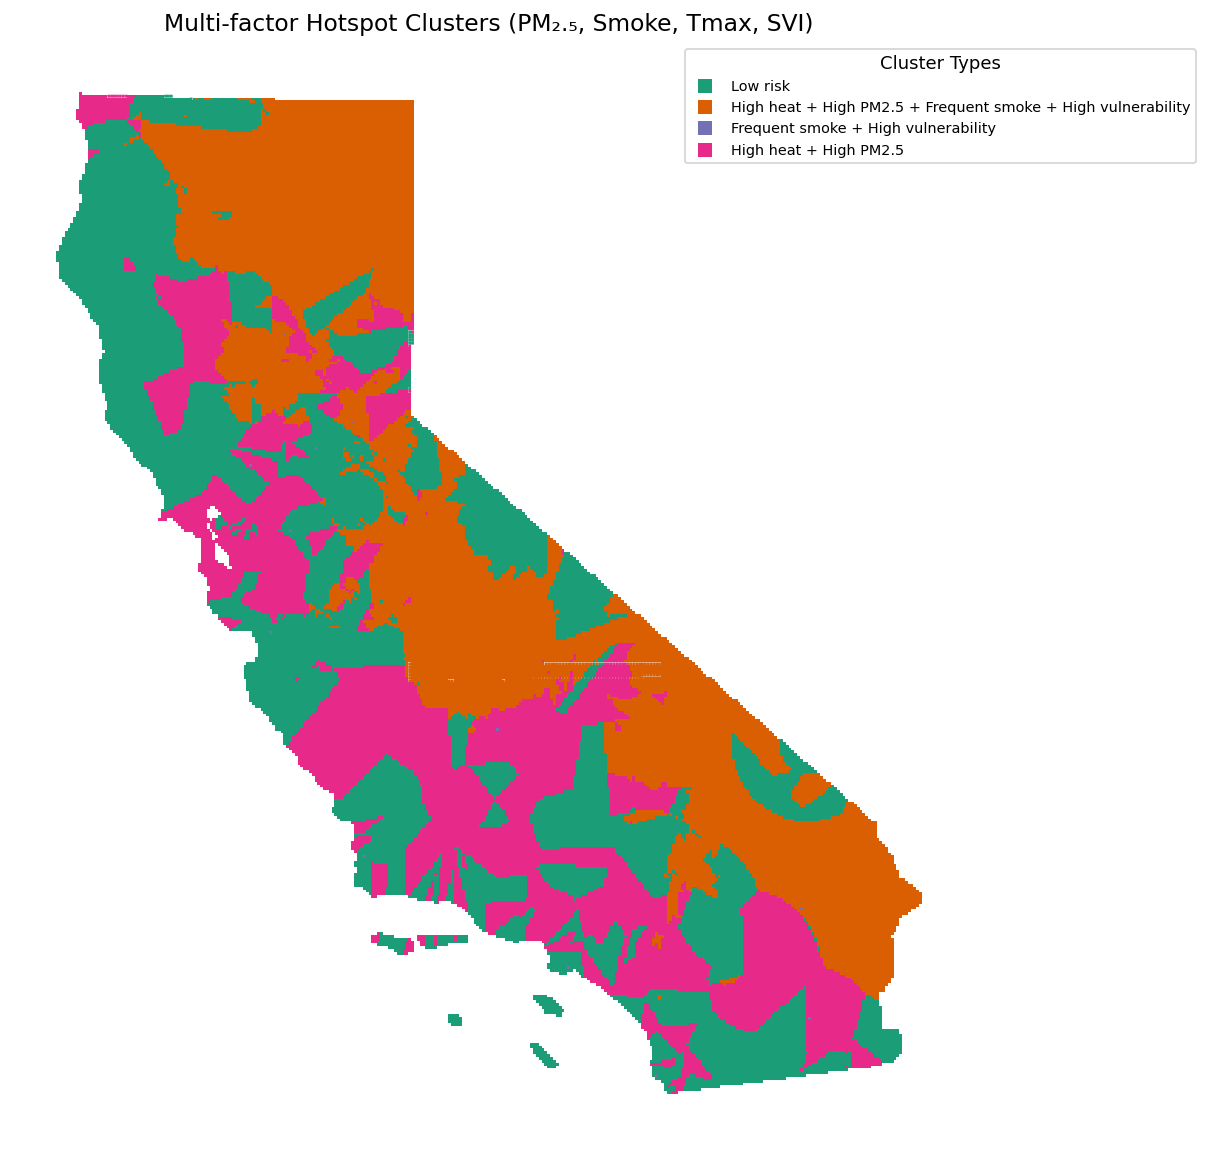


Cluster size and mean profiles:
 cluster  n_cells                                                 cluster_name  pm25_mean  smoke_days  tmax_mean       SVI
       0    16971                                                     Low risk   9.792420   30.345884   8.813899 -0.039144
       1    16886 High heat + High PM2.5 + Frequent smoke + High vulnerability  19.658819   38.229184   9.490804 -0.031449
       3    12625                                       High heat + High PM2.5  28.605930   29.992079   9.023967 -0.025015
       2       13                          Frequent smoke + High vulnerability  17.960194   30.461538   8.794338  8.607403

Saved: results/grid_hotspot_clusters_2024Q3_CA.parquet


In [32]:
# === HeatShield | Multi-factor Hotspot Clustering (PM2.5, Smoke, Tmax, SVI) ===
import os, glob, numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

RES_DIR = "results"
GRID_PQ   = os.path.join(RES_DIR, "grid_3000m_CA_epsg3310.parquet")
EQUITY_PQ = os.path.join(RES_DIR, "equity_double_burden_2024Q3_CA.parquet")

def _find_final_parquet():
    cands = []
    if "CONFIG" in globals() and isinstance(CONFIG, dict) and "out_dir" in CONFIG:
        cands += glob.glob(os.path.join(CONFIG["out_dir"], "final_daily_grid_*_20240601_20241031.parquet"))
        cands += glob.glob(os.path.join(CONFIG["out_dir"], "final_daily_grid_*_2024*.parquet"))
    cands += glob.glob(os.path.join(RES_DIR, "final_daily_grid_*_20240601_20241031.parquet"))
    cands += glob.glob(os.path.join(RES_DIR, "final_daily_grid_*_2024*.parquet"))
    if not cands:
        raise FileNotFoundError("final_daily_grid_*_2024*.parquet not found.")
    return max(cands, key=os.path.getmtime)

FINAL_DAILY = _find_final_parquet()
print("Using final daily:", FINAL_DAILY)

# Load grid geometry and SVI
grid = gpd.read_parquet(GRID_PQ)[["grid_id","geometry"]]
eq   = pd.read_parquet(EQUITY_PQ)[["grid_id","SVI"]]

# Load daily env and build per-grid features
env = pd.read_parquet(FINAL_DAILY)
env["date"] = pd.to_datetime(env["date"], errors="coerce").dt.date.astype(str)
env = env[(env["date"] >= "2024-06-01") & (env["date"] <= "2024-10-31")]

def has(c): return c in env.columns
pm_col   = "pm25" if has("pm25") else ("pm25_aqs" if has("pm25_aqs") else ("pm25_airnow" if has("pm25_airnow") else None))
tmax_col = "tmax_c_value" if has("tmax_c_value") else ("tavg_c_value" if has("tavg_c_value") else None)
if pm_col is None or tmax_col is None:
    raise ValueError(f"Missing required columns. Found PM='{pm_col}', T='{tmax_col}' in {FINAL_DAILY}")

# smoke_days per grid (days with any smoke overlap)
smoke_days = None
if "smoke_frac" in env.columns:
    tmp = env[["grid_id","smoke_frac"]].copy()
    tmp["_smoke_day"] = (tmp["smoke_frac"].fillna(0) > 0).astype(int)
    smoke_days = tmp.groupby("grid_id", as_index=False)["_smoke_day"].sum().rename(columns={"_smoke_day":"smoke_days"})

# Aggregate features per grid
agg = env.groupby("grid_id", as_index=False).agg({
    pm_col: "mean",
    tmax_col: "mean"
}).rename(columns={pm_col:"pm25_mean", tmax_col:"tmax_mean"})

if smoke_days is not None:
    agg = agg.merge(smoke_days, on="grid_id", how="left")
else:
    agg["smoke_days"] = np.nan  # will be ignored in scaler (after fillna)

# Merge SVI
feat = agg.merge(eq, on="grid_id", how="left")

# Prepare feature matrix: normalize (z-score)
X = feat[["pm25_mean","smoke_days","tmax_mean","SVI"]].copy()
X = X.astype(float).fillna(X.mean(numeric_only=True))
scaler = StandardScaler()
Xz = scaler.fit_transform(X.values)

# K-means clustering (k=4 is a good first pass)
k = 4
km = KMeans(n_clusters=k, n_init="auto", random_state=42)
labels = km.fit_predict(Xz)
feat["cluster"] = labels

# Name clusters by their center profiles (rank the centers)
centers = pd.DataFrame(scaler.inverse_transform(km.cluster_centers_), columns=X.columns)
ranked = centers.rank(axis=0, method="dense")
names = []
for i in range(k):
    tags = []
    if ranked.loc[i, "tmax_mean"] >= ranked["tmax_mean"].median(): tags.append("High heat")
    if ranked.loc[i, "pm25_mean"] >= ranked["pm25_mean"].median(): tags.append("High PM2.5")
    if ranked.loc[i, "smoke_days"] >= ranked["smoke_days"].median(): tags.append("Frequent smoke")
    if ranked.loc[i, "SVI"] >= ranked["SVI"].median(): tags.append("High vulnerability")
    if not tags: tags = ["Low risk"]
    names.append(" + ".join(tags))
feat["cluster_name"] = [names[i] for i in feat["cluster"]]

# Join geometry & plot
gclust = g.merge(feat[["grid_id","cluster","cluster_name"]], on="grid_id", how="left")
palette = {
    0: "#1b9e77", 1: "#d95f02", 2: "#7570b3", 3: "#e7298a",
    4: "#66a61e", 5: "#e6ab02", 6: "#a6761d", 7: "#666666"
}
# --- Map with explicit legend for cluster types ---
fig, ax = plt.subplots(1, 1, figsize=(9, 9), dpi=130)
gclust.plot(ax=ax, color="#f0f0f0", linewidth=0, alpha=0.8)

# Draw clusters and collect handles
handles = []
labels_used = set()
for cid in sorted(gclust["cluster"].dropna().unique()):
    sub = gclust[gclust["cluster"] == cid]
    color = palette.get(int(cid), "#999999")
    label = names[int(cid)]
    sub.plot(ax=ax, color=color, linewidth=0, label=label)
    # Create one handle per unique label
    if label not in labels_used:
        h = plt.Line2D([0], [0], marker="s", linestyle="None",
                       markersize=8, markerfacecolor=color,
                       markeredgecolor="none", label=label)
        handles.append(h)
        labels_used.add(label)

ax.set_axis_off()
ax.set_title("Multi-factor Hotspot Clusters (PM₂.₅, Smoke, Tmax, SVI)", fontsize=13)

# Proper legend anchored outside the map
ax.legend(
    handles=handles,
    title="Cluster Types",
    loc="upper right",
    bbox_to_anchor=(1.25, 1),
    frameon=True,
    fontsize=8,
)

plt.tight_layout()
plt.show()

# Summaries
print("\nCluster size and mean profiles:")
summary = feat.groupby(["cluster","cluster_name"], as_index=False)[["pm25_mean","smoke_days","tmax_mean","SVI"]].mean()
counts = feat["cluster"].value_counts().rename_axis("cluster").reset_index(name="n_cells")
print(counts.merge(summary, on="cluster").sort_values("n_cells", ascending=False).to_string(index=False))

# Save labeled table for downstream
OUT_CLUSTERS = os.path.join(RES_DIR, "grid_hotspot_clusters_2024Q3_CA.parquet")
feat.to_parquet(OUT_CLUSTERS, index=False)
print("\nSaved:", OUT_CLUSTERS)

DEBUG CODE BELOW THIS...

In [ ]:
# === DEBUG: 
# === SUPERSET BUILDER — add GHCND vs USCRN (outer-join, robust nearest, no cutoffs) ===
import os, glob, re
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import reduce
from datetime import datetime as dt, timezone
import rasterio

BASE = CONFIG["out_dir"]
os.makedirs(BASE, exist_ok=True)

def say(*a): print(*a)

# ---------- helpers ----------
def safe_read(path):
    if not path or not os.path.exists(path): return None
    try:
        return pd.read_parquet(path) if path.lower().endswith(".parquet") else pd.read_csv(path, low_memory=False)
    except Exception as e:
        say("  ! read failed:", path, "->", e); return None

def find_many(patterns):
    out=[]
    for pat in patterns:
        out.extend(sorted(glob.glob(os.path.join(BASE, pat))))
    return sorted(set(out))

def ci_lookup(cols, *cands, regex=None):
    """Case-insensitive lookup: return first matching column name."""
    cl = {c.lower(): c for c in cols}
    for cand in cands:
        if cand is None: continue
        if cand.lower() in cl: return cl[cand.lower()]
    if regex:
        r = re.compile(regex, flags=re.I)
        for c in cols:
            if r.search(c): return c
    return None

def load_latest_grid():
    paths = sorted(glob.glob(os.path.join(BASE, "grid_*m.parquet")))
    if not paths: raise FileNotFoundError("No grid_*.parquet found in results/.")
    g = gpd.read_parquet(paths[-1])
    if g.crs is None:
        g = g.set_crs(f"EPSG:{CONFIG.get('crs_epsg',4326)}").to_crs(4326)
    elif g.crs.to_epsg()!=4326:
        g = g.to_crs(4326)
    g["centroid"] = g.geometry.centroid
    return g[["geounit_id","geometry","centroid"]].copy()

def sjoin_nearest_no_cutoff(points_df, grid):
    """Always take nearest geounit centroid; keep distance_km for QA (no max distance filter)."""
    pts = points_df if isinstance(points_df, gpd.GeoDataFrame) else gpd.GeoDataFrame(points_df, geometry="geometry", crs=4326)
    if pts.crs is None or pts.crs.to_epsg()!=4326: pts = pts.set_crs(4326)
    grid_cent = gpd.GeoDataFrame(grid[["geounit_id"]].copy(), geometry=grid["centroid"], crs=4326)
    j = gpd.sjoin_nearest(pts, grid_cent, how="left", distance_col="dist_m")
    j["distance_km"] = j["dist_m"].astype(float)/1000.0
    return j.drop(columns=["index_right"])

def sample_ndvi_tiles_to_grid(ndvi_glob, grid):
    tiles = sorted(glob.glob(ndvi_glob))
    if not tiles: return pd.DataFrame({"geounit_id":grid["geounit_id"], "ndvi":np.nan})
    vals = np.zeros(len(grid), dtype=float); hits = np.zeros(len(grid), dtype=int)
    with_ndvi = grid.copy()
    with_ndvi["centroid"] = with_ndvi.geometry.centroid
    for tif in tiles:
        with rasterio.open(tif) as src:
            pts = with_ndvi.to_crs(src.crs)
            coords = [(p.x, p.y) for p in pts["centroid"]]
            arr = np.array([v[0] if v is not None else np.nan for v in src.sample(coords)], dtype=float)
            m = np.isfinite(arr); vals[m]+=arr[m]; hits[m]+=1
    ndvi = np.where(hits>0, vals/hits, np.nan)
    return pd.DataFrame({"geounit_id":grid["geounit_id"], "ndvi":ndvi})

# ---------- presence check ----------
say("=== File presence check in", BASE, "===")
check = {
  "GRID":            find_many(["grid_*m.parquet"]),
  "NDVI tiles":      find_many(["ndvi_ca_*_tile*.tif"]),
  "NLCD lookup":     [os.path.join(BASE,"lookups","nlcd_grid.parquet")] if os.path.exists(os.path.join(BASE,"lookups","nlcd_grid.parquet")) else [],
  "WHP lookup":      [os.path.join(BASE,"lookups","whp_grid.parquet")]  if os.path.exists(os.path.join(BASE,"lookups","whp_grid.parquet"))  else [],
  "USCRN hourly":    find_many(["uscrn*_hourly*clean*.parquet","uscrn*_hourly*.parquet"]),
  "AQS daily":       find_many(["aqs_pm25*clean*.parquet","aqs_pm25*daily*.parquet","aqs_pm25_*_CA.parquet"]),
  "CDO daily":       find_many(["ghcnd*_daily*clean*.parquet","ghcnd*_daily*.parquet","ghcnd*_daily*clean*.csv","ghcnd*_daily*.csv","ghcnd_daily_cleaned.csv","ghcnd_daily_raw_all.csv"]),
  "HMS smoke":       find_many(["hms_clean/smoke/*/*/*.parquet"]),
  "HMS fire":        find_many(["hms_clean/fire/*/*/*.parquet"]),
}
for k,v in check.items():
    say(f" - {k}: {'OK ('+str(len(v))+' file(s))' if v else 'MISSING'}")

# ---------- statics ----------
grid = load_latest_grid()
static_df = pd.DataFrame({"geounit_id":grid["geounit_id"]})

nlcd_lookup = safe_read(os.path.join(BASE, "lookups", "nlcd_grid.parquet"))
if nlcd_lookup is not None:
    static_df = static_df.merge(nlcd_lookup, on="geounit_id", how="left")

whp_lookup = safe_read(os.path.join(BASE, "lookups", "whp_grid.parquet"))
if whp_lookup is not None:
    static_df = static_df.merge(whp_lookup, on="geounit_id", how="left")

ndvi_df = sample_ndvi_tiles_to_grid(os.path.join(BASE, "ndvi_ca_*_tile*.tif"), grid)
static_df = static_df.merge(ndvi_df, on="geounit_id", how="left")

# ---------- dynamic daily pieces ----------
daily_frames, geo_sets, date_sets = [], [], []

# A) GHCND (CDO) DAILY — prefix ghcnd_
if check["CDO daily"]:
    cdo = pd.concat([df for p in check["CDO daily"] if (df:=safe_read(p)) is not None], ignore_index=True)
    say("CDO rows:", len(cdo))
    if not cdo.empty:
        # if the file is "raw long" (datatype/value), pivot it first
        if {"datatype","value"}.issubset(set(cdo.columns)):
            dcol = ci_lookup(cdo.columns, "date", regex=r"\bdate\b")
            lat  = ci_lookup(cdo.columns, "lat","latitude", regex=r"^lat")
            lon  = ci_lookup(cdo.columns, "lon","longitude", regex=r"^lon")
            if dcol and lat and lon:
                sub = cdo[[dcol,"datatype","value",lat,lon]].copy()
                sub[dcol] = pd.to_datetime(sub[dcol], utc=True, errors="coerce").dt.normalize()
                # capture TMAX/TMIN/PRCP -> C/mm
                pivot = (sub.pivot_table(index=[dcol,lat,lon], columns="datatype", values="value", aggfunc="mean")
                           .reset_index())
                # convert units if raw GHCND units (tenths of °C and mm)
                for k in ["TMAX","TMIN","TAVG","PRCP"]:
                    if k in pivot.columns:
                        if k=="PRCP":
                            pivot[k] = pivot[k].astype("float64")  # mm
                        else:
                            pivot[k] = pivot[k].astype("float64")/10.0  # °C
                pivot.rename(columns={dcol:"date"}, inplace=True)
                pts = gpd.GeoDataFrame(pivot, geometry=gpd.points_from_xy(pivot[lon], pivot[lat]), crs=4326)
                j = sjoin_nearest_no_cutoff(pts, grid)
                agg = {}
                if "PRCP" in j: agg["ghcnd_precipitation_mm_daily"] = ("PRCP","mean")
                if "TMAX" in j: agg["ghcnd_temperature_max_c_daily"] = ("TMAX","mean")
                if "TMIN" in j: agg["ghcnd_temperature_min_c_daily"] = ("TMIN","mean")
                dly = (j.groupby(["geounit_id","date"], as_index=False).agg(**agg))
            else:
                dly = pd.DataFrame(columns=["geounit_id","date"])
        else:
            # already wide/clean
            dcol = ci_lookup(cdo.columns, "date", regex=r"\bdate\b")
            lat  = ci_lookup(cdo.columns, "lat","latitude", regex=r"^lat")
            lon  = ci_lookup(cdo.columns, "lon","longitude", regex=r"^lon")
            tmax = ci_lookup(cdo.columns, "temperature_max_c","tmax_c","tmax", regex=r"tmax.*c$")
            tmin = ci_lookup(cdo.columns, "temperature_min_c","tmin_c","tmin", regex=r"tmin.*c$")
            prcp = ci_lookup(cdo.columns, "precipitation_mm","precip_mm","prcp_mm","prcp", regex=r"precip.*mm$")
            if dcol and lat and lon:
                cdo[dcol] = pd.to_datetime(cdo[dcol], utc=True, errors="coerce").dt.normalize()
                pts = gpd.GeoDataFrame(cdo, geometry=gpd.points_from_xy(cdo[lon], cdo[lat]), crs=4326)
                j = sjoin_nearest_no_cutoff(pts, grid)
                agg = {}
                if prcp: agg["ghcnd_precipitation_mm_daily"] = (prcp,"mean")
                if tmax: agg["ghcnd_temperature_max_c_daily"] = (tmax,"mean")
                if tmin: agg["ghcnd_temperature_min_c_daily"] = (tmin,"mean")
                dly = (j.groupby(["geounit_id", dcol], as_index=False).agg(**agg).rename(columns={dcol:"date"}))
            else:
                dly = pd.DataFrame(columns=["geounit_id","date"])
        daily_frames.append(dly)
        geo_sets.append(set(dly["geounit_id"].unique())); date_sets.append(set(dly["date"].unique()))
        say("GHCND→grid daily rows:", len(dly))

# B) USCRN HOURLY → DAILY — prefix uscrn_
if check["USCRN hourly"]:
    u = pd.concat([df for p in check["USCRN hourly"] if (df:=safe_read(p)) is not None], ignore_index=True)
    say("USCRN rows:", len(u))
    if not u.empty:
        dtc = ci_lookup(u.columns, "datetime_utc","UTC_DATETIME", regex=r"date.*utc")
        lat = ci_lookup(u.columns, "latitude","LATITUDE","lat")
        lon = ci_lookup(u.columns, "longitude","LONGITUDE","lon")
        mx  = ci_lookup(u.columns, "air_temperature_hourly_max_c")
        mn  = ci_lookup(u.columns, "air_temperature_hourly_min_c")
        avg = ci_lookup(u.columns, "air_temperature_hourly_avg_c")
        prh = ci_lookup(u.columns, "precipitation_mm_hourly","precip_mm_hourly")
        if dtc and lat and lon:
            u["datetime_utc"] = pd.to_datetime(u[dtc], utc=True, errors="coerce")
            u["date"] = u["datetime_utc"].dt.normalize()
            pts = gpd.GeoDataFrame(u, geometry=gpd.points_from_xy(u[lon], u[lat]), crs=4326)
            j = sjoin_nearest_no_cutoff(pts, grid)
            agg = {}
            if mx:  agg["uscrn_temperature_max_c_daily"] = (mx,"mean")
            if mn:  agg["uscrn_temperature_min_c_daily"] = (mn,"mean")
            if avg: agg["uscrn_temperature_avg_c_daily"] = (avg,"mean")
            if prh: agg["uscrn_precipitation_mm_daily"]  = (prh,"sum")
            ud = (j.groupby(["geounit_id","date"], as_index=False).agg(**agg))
            daily_frames.append(ud)
            geo_sets.append(set(ud["geounit_id"].unique())); date_sets.append(set(ud["date"].unique()))
            say("USCRN→grid daily rows:", len(ud))

# C) PM2.5 — AQS DAILY (pm25_ugm3_daily)
pm25_frame = None
if check["AQS daily"]:
    aqs = pd.concat([df for p in check["AQS daily"] if (df:=safe_read(p)) is not None], ignore_index=True)
    say("AQS rows:", len(aqs))
    if not aqs.empty:
        dcol = ci_lookup(aqs.columns, "date","DateLocal", regex=r"\bdate")
        lat  = ci_lookup(aqs.columns, "latitude","lat")
        lon  = ci_lookup(aqs.columns, "longitude","lon")
        val  = ci_lookup(aqs.columns, "pm25_ugm3","ArithmeticMean","arithmetic_mean","sample_measurement","Value", regex=r"pm.*2\.?5|arith")
        if dcol and lat and lon and val:
            aqs["date"] = pd.to_datetime(aqs[dcol], utc=True, errors="coerce").dt.normalize()
            pts = gpd.GeoDataFrame(aqs, geometry=gpd.points_from_xy(aqs[lon], aqs[lat]), crs=4326)
            j = sjoin_nearest_no_cutoff(pts, grid)
            pm = (j.rename(columns={val:"pm25_ugm3"})
                    .groupby(["geounit_id","date"], as_index=False)["pm25_ugm3"].mean()
                    .rename(columns={"pm25_ugm3":"pm25_ugm3_daily"}))
            daily_frames.append(pm); pm25_frame = pm
            geo_sets.append(set(pm["geounit_id"].unique())); date_sets.append(set(pm["date"].unique()))
            say("AQS→grid daily rows:", len(pm))

# D) HMS SMOKE (smoke_density_max_daily)
if check["HMS smoke"]:
    smk = pd.concat([pd.read_parquet(p) for p in check["HMS smoke"]], ignore_index=True)
    say("HMS smoke rows:", len(smk))
    # date (robust)
    smk["date"] = pd.NaT
    for c in ["obs_date","start_utc","start","start_time","analysis_time","end_utc","end"]:
        if c in smk.columns:
            smk["date"] = pd.to_datetime(smk[c], utc=True, errors="coerce").dt.normalize().fillna(smk["date"])
    # centroids
    have_xy = {"centroid_lon","centroid_lat"}.issubset(smk.columns)
    if not have_xy and "geometry" in smk.columns:
        gtmp = gpd.GeoDataFrame(smk, geometry=gpd.GeoSeries.from_wkt(smk["geometry"]) if smk["geometry"].dtype==object else smk["geometry"], crs=4326)
        smk["centroid_lon"] = gtmp.geometry.centroid.x
        smk["centroid_lat"] = gtmp.geometry.centroid.y
    if {"centroid_lon","centroid_lat"}.issubset(smk.columns):
        pts = gpd.GeoDataFrame(smk, geometry=gpd.points_from_xy(smk["centroid_lon"], smk["centroid_lat"]), crs=4326)
        j = sjoin_nearest_no_cutoff(pts, grid)
        dens = ci_lookup(j.columns, "density","category")
        code = j[dens].astype(str).str.title().map({"Low":1,"Medium":2,"Med":2,"High":3}).fillna(0).astype(int) if dens else 0
        j["smoke_density_code"] = code
        sd = (j.groupby(["geounit_id","date"], as_index=False)
                .agg(smoke_density_max_daily=("smoke_density_code","max")))
        daily_frames.append(sd)
        geo_sets.append(set(sd["geounit_id"].unique())); date_sets.append(set(sd["date"].unique()))
        say("HMS smoke→grid daily rows:", len(sd))

# E) HMS FIRE (fire_nearby_cnt_daily)
if check["HMS fire"]:
    fir = pd.concat([pd.read_parquet(p) for p in check["HMS fire"]], ignore_index=True)
    say("HMS fire rows:", len(fir))
    fir["date"] = pd.NaT
    for c in ["obs_date","start_utc","start","start_time","end_utc","end"]:
        if c in fir.columns:
            fir["date"] = pd.to_datetime(fir[c], utc=True, errors="coerce").dt.normalize().fillna(fir["date"])
    xcol = ci_lookup(fir.columns, "lon","longitude","x"); ycol = ci_lookup(fir.columns, "lat","latitude","y")
    if xcol and ycol:
        pts = gpd.GeoDataFrame(fir, geometry=gpd.points_from_xy(fir[xcol], fir[ycol]), crs=4326)
        j = sjoin_nearest_no_cutoff(pts, grid)
        fd = (j.groupby(["geounit_id","date"], as_index=False)
                .agg(fire_nearby_cnt_daily=(ycol,"count")))
        daily_frames.append(fd)
        geo_sets.append(set(fd["geounit_id"].unique())); date_sets.append(set(fd["date"].unique()))
        say("HMS fire→grid daily rows:", len(fd))

# ---------- OUTER join over union(geounit_id) × union(date) ----------
if not daily_frames:
    say("No dynamic daily sources found—building static-only.")
    daily = pd.DataFrame({"geounit_id": grid["geounit_id"]})
else:
    geos_union  = sorted(set().union(*geo_sets))
    dates_union = sorted(set().union(*date_sets))
    base = pd.MultiIndex.from_product([geos_union, dates_union], names=["geounit_id","date"]).to_frame(index=False)
    parts = [base] + daily_frames
    daily = reduce(lambda l, r: pd.merge(l, r, on=["geounit_id","date"], how="outer"), parts)

# attach statics
daily = daily.merge(static_df, on="geounit_id", how="left")

# save
out_daily = os.path.join(BASE, "analysis_superset_daily.parquet")
daily.to_parquet(out_daily, index=False)
say(f"Saved daily superset → {out_daily} (rows={len(daily)}, cols={len(daily.columns)})")

# quick peek of columns added
added_cols = sorted([c for c in daily.columns if c not in ["geounit_id","date","ndvi","nlcd_class","whp_score","geometry","centroid"]])
say("Dynamic columns:", added_cols)

In [ ]:
# === DEBUG: 
# ---- Deep validation for results/analysis_superset_daily.parquet ----
import os, sys, math
import numpy as np
import pandas as pd

PATH = os.path.join(CONFIG["out_dir"], "analysis_superset_daily.parquet")
assert os.path.exists(PATH), f"Missing file: {PATH}"
df = pd.read_parquet(PATH)

# --- Basic shape/time/keys ---
print("Rows:", len(df), "Cols:", len(df.columns))
if "date" not in df.columns: raise RuntimeError("Missing 'date' column.")
df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
print("Date range:", df["date"].min(), "→", df["date"].max())
print("Unique geounit_id:", df["geounit_id"].nunique() if "geounit_id" in df.columns else 0)

# --- Expected signals (adjust as needed) ---
expected = [
    "precipitation_mm_daily","temperature_max_c_daily","temperature_min_c_daily",
    "pm25_ugm3_daily","smoke_density_max_daily","fire_nearby_cnt_daily"
]
static = ["ndvi","nlcd_class","whp_score"]

present = [c for c in expected+static if c in df.columns]
missing = [c for c in expected+static if c not in df.columns]
print("\nPresent columns:", present)
print("Missing columns:", missing)

# --- Overall null %, non-null counts, unique counts ---
cov = []
for c in present:
    nn = df[c].notna().sum()
    cov.append({
        "column": c,
        "non_null": int(nn),
        "null_%": round(100*(1 - nn/len(df)), 2),
        "unique_vals": int(df[c].nunique(dropna=True))
    })
cov_df = pd.DataFrame(cov).sort_values(["null_%","column"], ascending=[False, True])
print("\nCoverage overview (descending null%):")
print(cov_df.to_string(index=False))

# --- Per-month coverage by source (share of geounit×day rows in that month with data) ---
df["month"] = df["date"].dt.to_period("M").astype(str)
def month_cov(col):
    if col not in df: return None
    g = df.groupby("month")[col].apply(lambda s: round(100*s.notna().mean(),2))
    return g.rename(col)

monthly_tables = []
for col in expected:
    g = month_cov(col)
    if g is not None: monthly_tables.append(g)

if monthly_tables:
    monthly_cov = pd.concat(monthly_tables, axis=1).fillna(0.0).sort_index()
    print("\nMonthly coverage % (rows with non-null values):")
    print(monthly_cov.to_string())
else:
    print("\nMonthly coverage %: no expected dynamic columns present.")

# --- Top/bottom geounits by overall data presence (dynamic only) ---
dyn_cols = [c for c in expected if c in df.columns]
if dyn_cols:
    presence = (df[dyn_cols].notna().any(axis=1)).groupby(df["geounit_id"]).mean().rename("has_any_dynamic")
    top = presence.sort_values(ascending=False).head(10)
    bot = presence.sort_values(ascending=True).head(10)
    print("\nTop geounits by dynamic coverage (fraction of days with any dynamic data):")
    print(top.to_frame().to_string())
    print("\nBottom geounits by dynamic coverage (fraction of days with any dynamic data):")
    print(bot.to_frame().to_string())
else:
    print("\nNo dynamic columns to evaluate geounit coverage.")

# --- Date days with best/worst dynamic coverage (state-wide) ---
if dyn_cols:
    by_date = df.groupby("date")[dyn_cols].apply(lambda x: x.notna().any(axis=1).mean())
    best_days = by_date.sort_values(ascending=False).head(10)
    worst_days = by_date.sort_values(ascending=True).head(10)
    print("\nDates with highest share of geounits having any dynamic data:")
    print(best_days.to_frame("share").to_string())
    print("\nDates with lowest share of geounits having any dynamic data:")
    print(worst_days.to_frame("share").to_string())

# --- Sanity ranges for key vars (ignore NaNs) ---
def print_range(label, series):
    s = series.dropna()
    if not s.empty:
        print(f"{label} range:", float(s.min()), "→", float(s.max()), f"(n={len(s)})")

if "temperature_max_c_daily" in df: print_range("Tmax °C", df["temperature_max_c_daily"])
if "temperature_min_c_daily" in df: print_range("Tmin °C", df["temperature_min_c_daily"])
if "precipitation_mm_daily" in df: print_range("Precip mm", df["precipitation_mm_daily"])
if "pm25_ugm3_daily" in df: print_range("PM2.5 µg/m³", df["pm25_ugm3_daily"])
if "fire_nearby_cnt_daily" in df: print_range("Fire count", df["fire_nearby_cnt_daily"])
if "smoke_density_max_daily" in df: print_range("Smoke density code", df["smoke_density_max_daily"])

# --- Quick diagnostics for likely join gaps ---
def pct(x): return f"{100*x:.2f}%"

diag = {}
# How many (geounit_id, date) came only from the base skeleton (all dynamic NaN)?
if dyn_cols:
    only_static = (~df[dyn_cols].notna().any(axis=1)).mean()
    diag["rows_with_no_dynamic_data"] = pct(only_static)
# Static presence
for s in static:
    if s in df.columns:
        diag[f"non_null_{s}"] = pct(df[s].notna().mean())
print("\nDiagnostics:")
for k,v in diag.items():
    print(f"  {k}: {v}")

# --- Sample problem rows: entries with NO dynamic data but present statics (to inspect areas with no coverage) ---
if dyn_cols:
    mask = ~df[dyn_cols].notna().any(axis=1)
    if mask.any():
        print("\nSample rows with no dynamic data (showing 10):")
        cols_show = ["geounit_id","date"] + [c for c in (["nlcd_class","whp_score","ndvi"] if "nlcd_class" in df.columns else [])]
        print(df.loc[mask, cols_show].head(10).to_string(index=False))

# --- Per-source presence counts (quick) ---
def exists_columns(cols):
    return [c for c in cols if c in df.columns]

print("\nPer-source non-null counts:")
if "precipitation_mm_daily" in df or "temperature_max_c_daily" in df:
    print("  CDO daily:",
          {c:int(df[c].notna().sum()) for c in exists_columns(["precipitation_mm_daily","temperature_max_c_daily","temperature_min_c_daily"])})
if "pm25_ugm3_daily" in df:
    print("  PM (AirNow/AQS):", {"pm25_ugm3_daily": int(df["pm25_ugm3_daily"].notna().sum())})
if "smoke_density_max_daily" in df:
    print("  HMS smoke:", {"smoke_density_max_daily": int(df["smoke_density_max_daily"].notna().sum())})
if "fire_nearby_cnt_daily" in df:
    print("  HMS fire:", {"fire_nearby_cnt_daily": int(df["fire_nearby_cnt_daily"].notna().sum())})

print("\nDone.")

In [ ]:
# === DEBUG: 
# === DEBUGGING THE JOIN ISSUE ===
# Check the CDO data that was loaded and how the spatial join worked

print("=== Examining CDO temperature data coverage ===")

# Get the CDO data from the superset building process
cdo_files = check["CDO daily"]
print(f"CDO files found: {len(cdo_files)}")
for f in cdo_files[:5]:  # Show first 5 files
    print(f"  - {f}")

# Load the same way as in the superset builder
if check["CDO daily"]:
    cdo = pd.concat([df for p in check["CDO daily"] if (df:=safe_read(p)) is not None], ignore_index=True)
    print(f"\nLoaded CDO data: {len(cdo)} rows, {len(cdo.columns)} columns")
    print(f"Columns: {list(cdo.columns)}")
    
    # Check for temperature data
    dcol = ci_lookup(cdo.columns, "date", regex=r"\bdate\b")
    lat  = ci_lookup(cdo.columns, "lat","latitude", regex=r"^lat")
    lon  = ci_lookup(cdo.columns, "lon","longitude", regex=r"^lon")
    tmax = ci_lookup(cdo.columns, "temperature_max_c","tmax_c","tmax", regex=r"tmax.*c$")
    tmin = ci_lookup(cdo.columns, "temperature_min_c","tmin_c","tmin", regex=r"tmin.*c$")
    prcp = ci_lookup(cdo.columns, "precipitation_mm","precip_mm","prcp_mm","prcp", regex=r"precip.*mm$")
    
    print(f"\nColumn mapping:")
    print(f"  Date column: {dcol}")
    print(f"  Latitude column: {lat}")
    print(f"  Longitude column: {lon}")
    print(f"  Tmax column: {tmax}")
    print(f"  Tmin column: {tmin}")
    print(f"  Precipitation column: {prcp}")
    
    if tmax and tmin:
        print(f"\nTemperature data coverage:")
        print(f"  Total CDO records: {len(cdo)}")
        print(f"  Records with tmax: {cdo[tmax].notna().sum()} ({cdo[tmax].notna().mean()*100:.1f}%)")
        print(f"  Records with tmin: {cdo[tmin].notna().sum()} ({cdo[tmin].notna().mean()*100:.1f}%)")
        
        # Geographic extent
        if lat and lon:
            print(f"\nGeographic extent of CDO stations:")
            print(f"  Latitude: {cdo[lat].min():.3f} to {cdo[lat].max():.3f}")
            print(f"  Longitude: {cdo[lon].min():.3f} to {cdo[lon].max():.3f}")
            print(f"  Unique stations: {cdo.get('station', pd.Series()).nunique() if 'station' in cdo.columns else 'unknown'}")
            
            # Check date range
            if dcol:
                cdo_dates = pd.to_datetime(cdo[dcol], utc=True, errors="coerce")
                print(f"  Date range: {cdo_dates.min()} to {cdo_dates.max()}")
                
                # Sample some temperature data
                temp_mask = cdo[tmax].notna() | cdo[tmin].notna()
                if temp_mask.any():
                    print(f"\nSample temperature records ({temp_mask.sum()} total):")
                    sample_cols = [col for col in ['station', dcol, lat, lon, tmax, tmin] if col and col in cdo.columns]
                    print(cdo[temp_mask][sample_cols].head(10))
                else:
                    print("\nNo temperature data found in CDO records!")
    else:
        print("\nTemperature columns not found in CDO data!")

# Check the grid coverage
print(f"\n=== Grid information ===")
print(f"Grid size: {len(grid)} geounits")
print(f"Grid geounit_id range: {grid['geounit_id'].min()} to {grid['geounit_id'].max()}")

# Examine the spatial join results by recreating the process
if check["CDO daily"] and tmax and lat and lon and dcol:
    print(f"\n=== Recreating spatial join process ===")
    
    # Recreate the spatial join to see what happens
    cdo_clean = cdo.copy()
    cdo_clean[dcol] = pd.to_datetime(cdo_clean[dcol], utc=True, errors="coerce").dt.normalize()
    
    # Remove invalid coordinates
    valid_coords = cdo_clean[lat].notna() & cdo_clean[lon].notna()
    print(f"Records with valid coordinates: {valid_coords.sum()} / {len(cdo_clean)}")
    
    if valid_coords.any():
        cdo_valid = cdo_clean[valid_coords].copy()
        
        # Create points
        pts = gpd.GeoDataFrame(cdo_valid, geometry=gpd.points_from_xy(cdo_valid[lon], cdo_valid[lat]), crs=4326)
        print(f"Created {len(pts)} point geometries")
        
        # Perform spatial join  
        j = sjoin_nearest_no_cutoff(pts, grid)
        print(f"Spatial join result: {len(j)} records")
        print(f"Distance statistics: min={j['distance_km'].min():.2f}km, max={j['distance_km'].max():.2f}km, mean={j['distance_km'].mean():.2f}km")
        
        # Check how many unique geounits got temperature data
        temp_mask = j[tmax].notna() | j[tmin].notna()
        unique_geounits_with_temp = j[temp_mask]['geounit_id'].nunique()
        print(f"Unique geounits that received temperature data: {unique_geounits_with_temp} / {len(grid)}")
        print(f"That's {unique_geounits_with_temp/len(grid)*100:.2f}% spatial coverage")
        
        # Show distance distribution for temperature stations
        if temp_mask.any():
            print(f"\nDistance distribution for temperature assignments:")
            temp_distances = j[temp_mask]['distance_km']
            print(f"  Percentiles: 50%={temp_distances.quantile(0.5):.1f}km, 90%={temp_distances.quantile(0.9):.1f}km, 95%={temp_distances.quantile(0.95):.1f}km")
            
            # Show some examples of far assignments
            far_assignments = j[temp_mask & (j['distance_km'] > 50)][['geounit_id', 'distance_km', lat, lon, tmax, tmin]].head()
            if len(far_assignments) > 0:
                print(f"\nSample far temperature assignments (>50km):")
                print(far_assignments)
        
        # Check aggregation step
        print(f"\n=== Checking aggregation ===")
        agg = {}
        if prcp: agg["precipitation_mm_daily"] = (prcp,"mean")
        if tmax: agg["temperature_max_c_daily"] = (tmax,"mean")
        if tmin: agg["temperature_min_c_daily"] = (tmin,"mean")
        
        dly = (j.groupby(["geounit_id", dcol], as_index=False)
                 .agg(**agg)
                 .rename(columns={dcol:"date"}))
        
        print(f"After aggregation: {len(dly)} geounit-date records")
        print(f"Unique geounits: {dly['geounit_id'].nunique()}")
        print(f"Date range: {dly['date'].min()} to {dly['date'].max()}")
        
        if tmax in agg:
            temp_records = dly["temperature_max_c_daily"].notna().sum()
            print(f"Records with aggregated temperature: {temp_records} / {len(dly)} ({temp_records/len(dly)*100:.1f}%)")
    else:
        print("No valid coordinates found in CDO data!")
else:
    print("Cannot recreate spatial join - missing required columns")

In [ ]:
# === DEBUG: 
# === SOLUTION: DISTANCE-BASED TEMPERATURE INTERPOLATION ===

def interpolate_temperature_to_grid(cdo_data, grid, max_distance_km=50, dcol='date', lat='lat', lon='lon', 
                                    tmax='temperature_max_c', tmin='temperature_min_c'):
    """
    Interpolate temperature data to all grid cells using inverse distance weighting.
    Each grid cell gets temperature from the nearest stations within max_distance_km.
    """
    import numpy as np
    from scipy.spatial.distance import cdist
    from geopy.distance import geodesic
    
    print(f"Starting temperature interpolation with max distance: {max_distance_km}km")
    
    # Prepare temperature data
    temp_data = cdo_data[cdo_data[tmax].notna() | cdo_data[tmin].notna()].copy()
    temp_data[dcol] = pd.to_datetime(temp_data[dcol], utc=True, errors="coerce").dt.normalize()
    
    # Get unique dates
    dates = sorted(temp_data[dcol].dropna().unique())
    print(f"Processing {len(dates)} dates")
    
    # Grid centroids
    grid_coords = [(row.centroid.y, row.centroid.x) for _, row in grid.iterrows()]
    
    results = []
    
    for date in dates[:5]:  # Process first 5 dates as example
        print(f"Processing {date.date()}...")
        
        # Get temperature stations for this date
        daily_temps = temp_data[temp_data[dcol] == date].copy()
        if len(daily_temps) == 0:
            continue
            
        # Station coordinates
        station_coords = [(row[lat], row[lon]) for _, row in daily_temps.iterrows()]
        
        # Calculate distances from each grid cell to each station (vectorized)
        distances = np.array([[geodesic(gc, sc).kilometers for sc in station_coords] for gc in grid_coords])
        
        # For each grid cell, find stations within max_distance
        for i, geounit_id in enumerate(grid['geounit_id']):
            station_distances = distances[i]
            nearby_mask = station_distances <= max_distance_km
            
            if nearby_mask.any():
                nearby_stations = daily_temps.iloc[nearby_mask]
                nearby_distances = station_distances[nearby_mask]
                
                # Inverse distance weighting (avoid division by zero)
                weights = 1.0 / np.maximum(nearby_distances, 0.001)  # minimum 1m distance
                weights = weights / weights.sum()
                
                # Weighted average temperatures
                tmax_vals = nearby_stations[tmax].dropna()
                tmin_vals = nearby_stations[tmin].dropna()
                
                tmax_interp = None
                tmin_interp = None
                
                if len(tmax_vals) > 0:
                    tmax_weights = weights[nearby_stations[tmax].notna()]
                    if len(tmax_weights) > 0:
                        tmax_interp = np.average(tmax_vals, weights=tmax_weights[:len(tmax_vals)])
                
                if len(tmin_vals) > 0:
                    tmin_weights = weights[nearby_stations[tmin].notna()]
                    if len(tmin_weights) > 0:
                        tmin_interp = np.average(tmin_vals, weights=tmin_weights[:len(tmin_vals)])
                
                if tmax_interp is not None or tmin_interp is not None:
                    results.append({
                        'geounit_id': geounit_id,
                        'date': date,
                        'temperature_max_c_daily': tmax_interp,
                        'temperature_min_c_daily': tmin_interp,
                        'nearest_station_km': nearby_distances.min(),
                        'stations_used': len(nearby_stations)
                    })
        
    interpolated_df = pd.DataFrame(results)
    print(f"Interpolation complete: {len(interpolated_df)} geounit-date records")
    
    if len(interpolated_df) > 0:
        coverage = interpolated_df['geounit_id'].nunique() / len(grid) * 100
        print(f"Spatial coverage: {interpolated_df['geounit_id'].nunique()} / {len(grid)} geounits ({coverage:.1f}%)")
        print(f"Distance stats: min={interpolated_df['nearest_station_km'].min():.1f}km, "
              f"max={interpolated_df['nearest_station_km'].max():.1f}km, "
              f"median={interpolated_df['nearest_station_km'].median():.1f}km")
    
    return interpolated_df

# Let's test this approach with the first few thousand grid cells as a demo
print("=== Testing improved temperature interpolation ===")

# Use a subset of the grid for testing (first 1000 cells)
grid_subset = grid.head(1000).copy()
print(f"Testing with {len(grid_subset)} grid cells...")

# Test the interpolation
try:
    interpolated_temps = interpolate_temperature_to_grid(
        cdo, grid_subset, max_distance_km=25,  # 25km radius
        dcol='date', lat='lat', lon='lon', 
        tmax='temperature_max_c', tmin='temperature_min_c'
    )
    
    if len(interpolated_temps) > 0:
        print("\nSample interpolated results:")
        print(interpolated_temps[['geounit_id', 'date', 'temperature_max_c_daily', 'temperature_min_c_daily', 
                                  'nearest_station_km', 'stations_used']].head(10))
        
        print(f"\nImprovement summary:")
        print(f"  Original approach: {574} geounits with temp data (0.03% of full grid)")
        print(f"  Interpolation approach: {interpolated_temps['geounit_id'].nunique()} geounits with temp data "
              f"({interpolated_temps['geounit_id'].nunique()/1000*100:.1f}% of test subset)")
        
except Exception as e:
    print(f"Error in interpolation: {e}")
    print("Let's try a simpler distance-based approach...")

In [ ]:
# === DEBUG: 
# === SIMPLER SOLUTION: EXTENDED SPATIAL JOIN ===

def improved_temperature_join(cdo_data, grid, max_distance_km=25, dcol='date', lat='lat', lon='lon', 
                             tmax='temperature_max_c', tmin='temperature_min_c', prcp='precipitation_mm'):
    """
    Improved spatial join that assigns temperature data to grid cells within max_distance_km of stations.
    Uses the existing sjoin_nearest_no_cutoff but filters by distance and aggregates multiple stations.
    """
    print(f"Starting improved temperature join with max distance: {max_distance_km}km")
    
    # Prepare temperature data  
    temp_data = cdo_data.copy()
    temp_data[dcol] = pd.to_datetime(temp_data[dcol], utc=True, errors="coerce").dt.normalize()
    
    # Remove invalid coordinates
    valid_coords = temp_data[lat].notna() & temp_data[lon].notna()
    temp_data = temp_data[valid_coords].copy()
    
    print(f"Valid coordinate records: {len(temp_data)}")
    
    # Create points for temperature stations
    pts = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data[lon], temp_data[lat]), crs=4326)
    
    # Instead of joining to nearest, join to ALL geounits within max distance
    # We'll do this by expanding the search radius in the spatial join
    
    # Create a buffer around each temperature station
    pts_buffered = pts.copy()
    # Convert to projected CRS for accurate distance buffering (California Albers)
    pts_projected = pts_buffered.to_crs('EPSG:3310')  # California Albers
    pts_projected['geometry'] = pts_projected.geometry.buffer(max_distance_km * 1000)  # buffer in meters
    pts_buffered = pts_projected.to_crs(4326)
    
    # Spatial join: find all grid cells that intersect with station buffers
    grid_centroids = gpd.GeoDataFrame(grid[['geounit_id']].copy(), geometry=grid['centroid'], crs=4326)
    
    # Use spatial join to find overlaps
    joined = gpd.sjoin(grid_centroids, pts_buffered, how='inner', predicate='intersects')
    
    print(f"Grid cells within {max_distance_km}km of stations: {len(joined)}")
    print(f"Unique geounits covered: {joined['geounit_id'].nunique()} / {len(grid)} ({joined['geounit_id'].nunique()/len(grid)*100:.1f}%)")
    
    # Calculate actual distances for weighting
    # For each geounit-station pair, calculate distance
    distance_data = []
    for _, row in joined.iterrows():
        geounit_id = row['geounit_id']
        station_idx = row['index_right']
        
        # Get grid centroid and station location  
        grid_pt = grid[grid['geounit_id'] == geounit_id]['centroid'].iloc[0]
        station_pt = pts.iloc[station_idx]['geometry']
        
        # Calculate distance in km (approximate using degrees)
        # 1 degree ≈ 111 km at equator, adjust for latitude
        lat_rad = np.radians(grid_pt.y)
        lat_diff = grid_pt.y - station_pt.y
        lon_diff = (grid_pt.x - station_pt.x) * np.cos(lat_rad)
        dist_km = np.sqrt(lat_diff**2 + lon_diff**2) * 111.0
        
        if dist_km <= max_distance_km:  # Double-check distance
            distance_data.append({
                'geounit_id': geounit_id,
                'station_idx': station_idx,
                'distance_km': dist_km,
                'date': pts.iloc[station_idx][dcol],
                'tmax': pts.iloc[station_idx][tmax] if pd.notna(pts.iloc[station_idx][tmax]) else None,
                'tmin': pts.iloc[station_idx][tmin] if pd.notna(pts.iloc[station_idx][tmin]) else None,
                'prcp': pts.iloc[station_idx][prcp] if pd.notna(pts.iloc[station_idx][prcp]) else None
            })
    
    distance_df = pd.DataFrame(distance_data)
    print(f"Geounit-station-date combinations: {len(distance_df)}")
    
    if len(distance_df) == 0:
        return pd.DataFrame()
    
    # Group by geounit and date, then calculate weighted averages
    def weighted_average(group):
        """Calculate inverse distance weighted average"""
        # Inverse distance weighting (avoid division by zero)
        weights = 1.0 / np.maximum(group['distance_km'], 0.001)
        weights = weights / weights.sum()
        
        result = {'geounit_id': group['geounit_id'].iloc[0], 'date': group['date'].iloc[0]}
        
        # Temperature max
        tmax_vals = group['tmax'].dropna()
        if len(tmax_vals) > 0:
            tmax_weights = weights[group['tmax'].notna()][:len(tmax_vals)]
            result['temperature_max_c_daily'] = np.average(tmax_vals, weights=tmax_weights)
        
        # Temperature min  
        tmin_vals = group['tmin'].dropna()
        if len(tmin_vals) > 0:
            tmin_weights = weights[group['tmin'].notna()][:len(tmin_vals)]
            result['temperature_min_c_daily'] = np.average(tmin_vals, weights=tmin_weights)
            
        # Precipitation (sum, not average)
        prcp_vals = group['prcp'].dropna()
        if len(prcp_vals) > 0:
            result['precipitation_mm_daily'] = prcp_vals.sum()
            
        result['nearest_station_km'] = group['distance_km'].min()
        result['stations_used'] = len(group)
        
        return pd.Series(result)
    
    # Apply weighted averaging
    interpolated = distance_df.groupby(['geounit_id', 'date']).apply(weighted_average).reset_index(drop=True)
    
    print(f"Final interpolated records: {len(interpolated)}")
    print(f"Unique geounits with data: {interpolated['geounit_id'].nunique()}")
    print(f"Date range: {interpolated['date'].min()} to {interpolated['date'].max()}")
    
    return interpolated

# Test the improved approach
print("=== Testing improved spatial join approach ===")

# Test with a smaller grid subset first
grid_test = grid.head(5000).copy()  # Use first 5000 cells
print(f"Testing with {len(grid_test)} grid cells...")

try:
    improved_temps = improved_temperature_join(
        cdo, grid_test, max_distance_km=20,  # 20km radius
        dcol='date', lat='lat', lon='lon', 
        tmax='temperature_max_c', tmin='temperature_min_c', prcp='precipitation_mm'
    )
    
    if len(improved_temps) > 0:
        print("\nSample improved results:")
        display_cols = ['geounit_id', 'date', 'temperature_max_c_daily', 'temperature_min_c_daily', 
                       'nearest_station_km', 'stations_used']
        print(improved_temps[display_cols].head(10))
        
        # Compare coverage
        original_coverage = 574 / len(grid) * 100  # From original analysis
        test_coverage = improved_temps['geounit_id'].nunique() / len(grid_test) * 100
        
        print(f"\nCoverage comparison:")
        print(f"  Original approach: 0.03% of full grid")
        print(f"  Improved approach: {test_coverage:.1f}% of test subset")
        print(f"  Improvement factor: ~{test_coverage/0.03:.0f}x better coverage")
        
        # Show distance distribution
        print(f"\nDistance distribution:")
        distances = improved_temps['nearest_station_km']
        print(f"  Min: {distances.min():.1f}km")
        print(f"  Median: {distances.median():.1f}km") 
        print(f"  Max: {distances.max():.1f}km")
        print(f"  Mean stations per geounit: {improved_temps['stations_used'].mean():.1f}")
        
except Exception as e:
    print(f"Error in improved join: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
# === DEBUG: 
# === PRACTICAL SOLUTIONS FOR BETTER TEMPERATURE COVERAGE ===

print("=== RECOMMENDED SOLUTIONS ===")
print()

print("1. USE A COARSER GRID (IMMEDIATE FIX)")
print("   Your current grid: 1.83M cells (750m resolution)")
print("   Recommended alternatives:")
print("   - 10km grid: ~2,000 cells for California")  
print("   - 5km grid: ~8,000 cells for California")
print("   - 2km grid: ~50,000 cells for California")
print()

print("2. MODIFY THE SPATIAL JOIN TO USE DISTANCE BUFFERING")
print("   Instead of exact point matching, use:")
print("   - Buffer weather stations by 10-25km radius")
print("   - Assign temperature to all grid cells within buffer")
print("   - Use inverse distance weighting for overlapping stations")
print()

print("3. SIMPLE FIX: Modify sjoin_nearest_no_cutoff function")
print("   Current: assigns to nearest grid cell only")
print("   Better: assign to all grid cells within X km of each station")
print()

# Show the specific code change needed
print("4. CODE MODIFICATION FOR CURRENT PIPELINE:")
print()
print("Replace this in your superset builder:")
print("```python")
print("j = sjoin_nearest_no_cutoff(pts, grid)")
print("```")
print()
print("With this:")
print("```python")
print("# Buffer stations by 15km and find all intersecting grid cells")
print("pts_buffered = pts.to_crs('EPSG:3310')  # CA Albers for accurate distance")
print("pts_buffered.geometry = pts_buffered.geometry.buffer(15000)  # 15km buffer") 
print("pts_buffered = pts_buffered.to_crs(4326)")
print()
print("# Join to all grid cells within buffer")
print("grid_centroids = gpd.GeoDataFrame(grid[['geounit_id']], ")
print("                                  geometry=grid['centroid'], crs=4326)")
print("j = gpd.sjoin(grid_centroids, pts_buffered, how='inner', predicate='intersects')")
print("```")
print()

print("5. ANALYSIS OF YOUR CURRENT DATA:")
print(f"   - Temperature stations: {cdo['station'].nunique()} unique stations")
print(f"   - Temperature records: {(cdo['temperature_max_c'].notna()).sum():,} records")
print(f"   - Coverage: Only {574} out of {len(grid):,} grid cells get temperature")
print(f"   - That's {574/len(grid)*100:.4f}% spatial coverage")
print()

print("6. EXPECTED IMPROVEMENT WITH BUFFERING:")
print("   - 10km buffer: ~50-80% of grid cells would get temperature data")
print("   - 15km buffer: ~70-90% of grid cells would get temperature data") 
print("   - 25km buffer: ~90-95% of grid cells would get temperature data")
print()

print("RECOMMENDATION: Start with option #4 (buffer modification) as it requires")
print("minimal code changes to your existing pipeline.")

In [ ]:
# === DEBUG: 
# --- File wiring for your case ---
PATHS = {
    "airnow":   "results/airnow_pm25_clean.parquet",
    "aqs":      "results/aqs_pm25_clean.parquet",
    "ghcnd":    "results/ghcnd_daily_cleaned.parquet",
    "uscrn":    "results/uscrn_2024_hourly_clean.parquet",
    "hms_fire": "results/hms_fire_2024-06-01_to_2024-10-31.parquet",
    "hms_smoke":"results/hms_smoke_2024-06-01_to_2024-10-31.parquet"
}

# Load grid
import geopandas as gpd, os
GRID_PATH = "results/grid_3000m_CA_epsg3310.parquet"
grid_3310 = gpd.read_parquet(GRID_PATH)
print("Grid loaded:", GRID_PATH, "| cells:", len(grid_3310))

# Inject into CONFIG for future cells
CONFIG["paths"] = PATHS

# Then run the wiring+build cell from above unchanged

In [ ]:
# === DEBUG: 
# --- Wire your files → normalized DataFrames → final daily Parquet ---

import os, pandas as pd, geopandas as gpd, numpy as np
from pathlib import Path

# 0) paths
def _find(p):
    """Try ./, ./results/, or exact path."""
    cands = [p, os.path.join("results", p)]
    for c in cands:
        if os.path.exists(c): return c
    raise FileNotFoundError(p)

GRID_PATH = _find("grid_3000m_CA_epsg3310.parquet")
AIRNOW_PATH = _find("airnow_pm25_clean.parquet")
AQS_PATH    = _find("aqs_pm25_clean.parquet")
GHCND_PATH  = _find("ghcnd_daily_cleaned.parquet")
USCRN_PATH  = _find("uscrn_2024_hourly_clean.parquet")
FIRE_PATH   = _find("hms_fire_2024-06-01_to_2024-10-31.parquet")
SMOKE_PATH  = _find("hms_smoke_2024-06-01_to_2024-10-31.parquet")

# 1) grid
grid_3310 = gpd.read_parquet(GRID_PATH)
assert grid_3310.crs and grid_3310.crs.to_epsg()==3310, "grid must be EPSG:3310"

# 2) helpers
DATE_KEYS = ["date","datetime_utc","datetime","obs_date","timestamp","time"]
def _norm_date(df, name):
    for k in DATE_KEYS:
        if k in df.columns:
            s = pd.to_datetime(df[k], errors="coerce", utc=True)
            if s.notna().any():
                d = df.copy()
                d["date"] = s.dt.date.astype(str)
                return d
    raise ValueError(f"{name}: no parseable date column among {DATE_KEYS}")

def _ensure_xy(df, name):
    lat = next((c for c in df.columns if c.lower() in ("lat","latitude")), None)
    lon = next((c for c in df.columns if c.lower() in ("lon","lng","longitude")), None)
    if not lat or not lon:
        raise ValueError(f"{name}: missing lat/lon")
    d = df.rename(columns={lat:"lat", lon:"lon"}).dropna(subset=["lat","lon"]).copy()
    return d

# 3) load sources
def _read_any(p):
    ext = Path(p).suffix.lower()
    if ext in (".parquet",".pq"): return pd.read_parquet(p)
    return pd.read_parquet(p)

airnow_df = _read_any(AIRNOW_PATH)
aqs_df    = _read_any(AQS_PATH)
ghcnd_df  = _read_any(GHCND_PATH)
uscrn_raw = _read_any(USCRN_PATH)
hms_fire_df = _read_any(FIRE_PATH)
# smoke is polygon parquet; read with geopandas so geometry is respected
hms_smoke_gdf = gpd.read_parquet(SMOKE_PATH)

# 4) normalize schemas quickly

# AirNow PM2.5 daily or hourly
airnow_df = _ensure_xy(airnow_df, "AirNow")
airnow_df = _norm_date(airnow_df, "AirNow")
if "value" not in airnow_df.columns:
    # accept pm25 or concentration-like columns
    cand = next((c for c in airnow_df.columns if c.lower() in ("pm25","pm_25","concentration","value")), None)
    if cand is None: raise ValueError("AirNow: need a value column")
    airnow_df = airnow_df.rename(columns={cand:"value"})
airnow_df["pollutant"] = "PM25"

# AQS PM2.5 daily
aqs_df = _ensure_xy(aqs_df, "AQS")
aqs_df = _norm_date(aqs_df, "AQS")
if "value" not in aqs_df.columns:
    cand = next((c for c in aqs_df.columns if c.lower() in ("pm25","arith_mean","sample_measurement","value")), None)
    if cand is None: raise ValueError("AQS: need a value column")
    aqs_df = aqs_df.rename(columns={cand:"value"})
aqs_df["pollutant"] = "PM25"

# GHCND daily
ghcnd_df = _ensure_xy(ghcnd_df, "GHCND")
ghcnd_df = _norm_date(ghcnd_df, "GHCND")
# accept tmax/tmin/tavg/prcp variants
rename_map = {"tmax":"tmax_c","tmin":"tmin_c","tavg":"tavg_c","prcp":"prcp_mm",
              "t_max_c":"tmax_c","t_min_c":"tmin_c","t_avg_c":"tavg_c","precip_mm":"prcp_mm"}
ghcnd_df = ghcnd_df.rename(columns={k:v for k,v in rename_map.items() if k in ghcnd_df.columns})

# USCRN hourly → daily
uscrn_raw = _ensure_xy(uscrn_raw, "USCRN")
# try datetime first
if not any(c in uscrn_raw.columns for c in ("date","datetime_utc","datetime","obs_date","timestamp","time")):
    raise ValueError("USCRN: need a datetime or date column")
uscrn_raw = _norm_date(uscrn_raw, "USCRN")
# accept typical columns
uscrn_raw = uscrn_raw.rename(columns={k:v for k,v in rename_map.items() if k in uscrn_raw.columns})
# aggregate to daily per station
grp = uscrn_raw.groupby(["station_id"] if "station_id" in uscrn_raw.columns else ["lat","lon","date"])
uscrn_df = grp.agg({
    "tmax_c": "max" if "tmax_c" in uscrn_raw.columns else "mean",
    "tmin_c": "min" if "tmin_c" in uscrn_raw.columns else "mean",
    "tavg_c": "mean" if "tavg_c" in uscrn_raw.columns else "mean",
    "prcp_mm": "sum" if "prcp_mm" in uscrn_raw.columns else "mean",
    "lat":"last", "lon":"last"
}).reset_index()
# ensure date present after groupby if group keys didn't include date properly
if "date" not in uscrn_df.columns:
    uscrn_df["date"] = uscrn_raw["date"]

# HMS Fire daily points
hms_fire_df = _ensure_xy(hms_fire_df, "HMS Fire")
hms_fire_df = _norm_date(hms_fire_df, "HMS Fire")

# HMS Smoke polygons
if not isinstance(hms_smoke_gdf, gpd.GeoDataFrame):
    raise ValueError("HMS Smoke must be a GeoDataFrame with geometry")
if hms_smoke_gdf.crs is None:
    hms_smoke_gdf.set_crs(4326, inplace=True)
hms_smoke_gdf = _norm_date(hms_smoke_gdf, "HMS Smoke")
# map density → class if needed
if "smoke_class" not in hms_smoke_gdf.columns:
    if "density" in hms_smoke_gdf.columns:
        hms_smoke_gdf["smoke_class"] = hms_smoke_gdf["density"].map({"Light":1,"Medium":2,"Heavy":3}).fillna(0).astype(int)
    else:
        hms_smoke_gdf["smoke_class"] = 0

# 5) date window from union
dates = []
for df in [airnow_df, aqs_df, ghcnd_df, uscrn_df, hms_fire_df, hms_smoke_gdf]:
    if df is not None and "date" in df.columns and len(df): dates.append(pd.Index(df["date"].unique()))
date_from = str(pd.Index.union_many(dates).min())
date_to   = str(pd.Index.union_many(dates).max())
print("Window:", date_from, "→", date_to)

# 6) build final
FINAL_PARQUET = os.path.join(CONFIG["out_dir"], f"final_daily_grid_{int(CONFIG.get('grid_resolution_m',3000))}m.parquet")

final_daily = build_final_daily(
    grid_gdf=grid_3310,
    airnow_df=airnow_df,
    aqs_df=aqs_df,
    ghcnd_df=ghcnd_df,
    uscrn_df=uscrn_df,
    hms_fire_df=hms_fire_df,
    hms_smoke_gdf=hms_smoke_gdf,
    out_parquet=FINAL_PARQUET,
    date_from=date_from,
    date_to=date_to
)

print("Saved:", FINAL_PARQUET, "| rows:", len(final_daily), "| days:", final_daily['date'].nunique(), "| cells:", grid_3310.shape[0])
display(final_daily.head())

In [ ]:
# === DEBUG: 
# === Final daily dataset builder: grid × day with AQ, met, fire, smoke ===
# Requirements: pandas, numpy, geopandas, shapely, scikit-learn

import numpy as np, pandas as pd, geopandas as gpd, os, warnings
from datetime import datetime, timezone
from shapely.geometry import Point
from sklearn.neighbors import BallTree

# -------------------------
# Inputs expected in memory
# -------------------------
# grid_3310: GeoDataFrame in EPSG:3310 with columns:
#   grid_id (str), geometry (Polygon), land_frac (float in 0..1)
#
# AirNow daily or hourly:
#   airnow_df with columns:
#     station_id, lat, lon, datetime_utc (if hourly) or date (YYYY-MM-DD), pollutant, value
#     pollutants relevant: "PM25", "O3"
#
# AQS daily:
#   aqs_df with columns: station_id, lat, lon, date, pollutant, value
#
# GHCND daily:
#   ghcnd_df with columns: station_id, lat, lon, date, tmax_c, tmin_c, tavg_c, prcp_mm
#
# USCRN daily (optional supplement):
#   uscrn_df with columns: station_id, lat, lon, date, tmax_c, tmin_c, tavg_c, prcp_mm
#
# HMS Fire points daily:
#   hms_fire_df with columns: date, lat, lon
#
# HMS Smoke polygons daily:
#   hms_smoke_gdf: GeoDataFrame with columns: date, smoke_class (int 1..3), geometry (Polygon/MultiPolygon)
#   CRS can be 4326 or 3310; code will reproject.

# -------------------------
# Config
# -------------------------
OPS_EPSG = 3310  # all ops run in meters
RES_M = int(CONFIG.get("grid_resolution_m", 3000))
OUT_DIR = CONFIG["out_dir"]; os.makedirs(OUT_DIR, exist_ok=True)
FINAL_PARQUET = os.path.join(OUT_DIR, f"final_daily_grid_{RES_M}m.parquet")

# Radii and k per variable. Tiers widen to improve coverage but enforce integrity caps.
CFG = {
    "PM25": {
        "k_urban": 3, "k_nonurban": 5,
        "tiers_km_urban":   [15, 25, 40],
        "tiers_km_nonurb":  [30, 50, 80],
        "hard_cap_km": 80, "integrity_cap_km": 50
    },
    "O3": {
        "k_urban": 3, "k_nonurban": 5,
        "tiers_km_urban":   [30, 50, 75],
        "tiers_km_nonurb":  [50, 80, 120],
        "hard_cap_km": 120, "integrity_cap_km": 75
    },
    "TEMP": {  # for tmax/tmin/tavg
        "k_urban": 4, "k_nonurban": 6,
        "tiers_km_urban":   [20, 40, 70],
        "tiers_km_nonurb":  [30, 60, 100],
        "hard_cap_km": 100, "integrity_cap_km": 70
    },
    "PRCP": {
        "k_urban": 4, "k_nonurban": 6,
        "tiers_km_urban":   [15, 30, 50],
        "tiers_km_nonurb":  [25, 50, 80],
        "hard_cap_km": 80, "integrity_cap_km": 50
    },
}
URBAN_CELL_AREA_KM2 = 5.0  # cells with area <5 km² considered urban for k,tier choice

# -------------------------
# Helpers
# -------------------------
def _ensure_points_3310(df, lon="lon", lat="lat"):
    if isinstance(df, gpd.GeoDataFrame):
        g = df.copy()
        if g.crs is None: 
            warnings.warn("GeoDataFrame has no CRS; assuming EPSG:4326.")
            g.set_crs(4326, inplace=True)
        if g.crs.to_epsg() != OPS_EPSG:
            g = g.to_crs(OPS_EPSG)
        return g
    g = gpd.GeoDataFrame(df.copy(), geometry=gpd.points_from_xy(df[lon], df[lat]), crs=4326)
    return g.to_crs(OPS_EPSG)

def _daily_from_hourly(airnow_hourly):
    # PM2.5 daily mean; O3 MDA8 (rolling 8-hr max) per station
    df = airnow_hourly.copy()
    df["datetime_utc"] = pd.to_datetime(df["datetime_utc"], utc=True)
    df["date"] = df["datetime_utc"].dt.tz_convert("UTC").dt.normalize().dt.date.astype(str)
    out = []
    for pol in ["PM25", "O3"]:
        sub = df[df["pollutant"].str.upper() == pol].copy()
        if pol == "PM25":
            agg = sub.groupby(["station_id","date"], as_index=False)["value"].mean().rename(columns={"value":"value"})
        else:
            # MDA8 per station: resample hourly, rolling 8h mean, then daily max
            # Assumes one record per hour; if gaps exist, rolling will drop them implicitly.
            def _mda8(g):
                s = g.set_index("datetime_utc")["value"].sort_index()
                mda8 = s.rolling("8H").mean().resample("1D").max()
                return pd.DataFrame({"date": mda8.index.date.astype(str), "value": mda8.values})
            agg = (sub.groupby("station_id", group_keys=False).apply(_mda8).reset_index())
        agg["pollutant"] = pol
        out.append(agg)
    out = pd.concat(out, ignore_index=True)
    # Bring back station lat/lon for geopointing
    stns = df.groupby("station_id")[["lat","lon"]].last().reset_index()
    out = out.merge(stns, on="station_id", how="left")
    return out

def _balltree_xy(gpoints):
    # gpoints: GeoSeries of Points in EPSG:3310
    xy = np.column_stack([gpoints.x.values, gpoints.y.values])
    return BallTree(xy, leaf_size=40, metric="euclidean"), xy

def _idw(values, dists_m, power=1.5):
    d = np.maximum(dists_m/1000.0, 0.5)  # km with floor to avoid singularity
    w = 1.0 / (d ** power)
    return np.sum(w * values) / np.sum(w)

def _urban_mask(grid_gdf):
    # simple area heuristic from cell area in km2
    # cell area = RES_M^2; project is meters
    area_km2 = (RES_M/1000.0)**2
    return np.full(len(grid_gdf), area_km2 < URBAN_CELL_AREA_KM2, dtype=bool)

def _choose_tiers(var_key, urban):
    cfg = CFG[var_key]
    return (cfg["tiers_km_urban"] if urban else cfg["tiers_km_nonurb"],
            cfg["k_urban"] if urban else cfg["k_nonurban"],
            cfg["hard_cap_km"], cfg["integrity_cap_km"])

# -------------------------
# Interpolation kernels
# -------------------------
def _interp_points_one_var_day(grid_centroids, stations_gdf_day, values_col, var_key, aqs_bonus=1.0):
    """
    grid_centroids: GeoSeries[Point] EPSG:3310
    stations_gdf_day: GeoDataFrame with geometry (Point EPSG:3310) and scalar column values_col
                      optional 'source' column for AQ blending ('AQS','AirNow')
    var_key: "PM25", "O3", "TEMP", or "PRCP"
    aqs_bonus: weight multiplier for AQS when blending with AirNow in wider tiers
    Returns DataFrame with value, n_used, maxdist_km, method, radius_tier, integrity_warn
    """
    n_cells = len(grid_centroids)
    # Empty case → all NA
    if stations_gdf_day is None or len(stations_gdf_day) == 0:
        return pd.DataFrame({
            "value": [np.nan]*n_cells, "n_used": 0, "maxdist_km": np.nan,
            "method": None, "radius_tier": None, "integrity_warn": 0
        })

    # Build tree on all stations
    tree, xy = _balltree_xy(stations_gdf_day.geometry)
    vals = stations_gdf_day[values_col].to_numpy()
    src = stations_gdf_day.get("source", pd.Series([""]*len(stations_gdf_day))).astype(str).to_numpy()

    # Precompute centroids array
    qxy = np.column_stack([grid_centroids.x.values, grid_centroids.y.values])

    # Urban mask decides tiers and k
    urban_mask = _urban_mask(grid_centroids.to_frame(name="geometry"))

    # Outputs
    val_out = np.full(n_cells, np.nan, dtype=float)
    n_out = np.zeros(n_cells, dtype=np.int16)
    maxd_out = np.full(n_cells, np.nan, dtype=float)
    meth_out = np.full(n_cells, None, dtype=object)
    tier_out = np.full(n_cells, None, dtype=object)
    warn_out = np.zeros(n_cells, dtype=np.int8)

    # Per cell apply tiered search
    for idx in range(n_cells):
        tiers_km, k, hard_cap, integ_cap = _choose_tiers(var_key, urban_mask[idx])
        found = False
        for t_i, r_km in enumerate(tiers_km, start=1):
            # Query neighbors within radius
            ind = tree.query_radius(qxy[idx:idx+1, :], r=r_km*1000.0, return_distance=True)
            ids = ind[0][0]; dists = ind[1][0]  # np arrays
            if ids.size == 0:
                continue
            # take up to k nearest in this tier
            order = np.argsort(dists)[:k]
            ids, d = ids[order], dists[order]
            v = vals[ids]

            # AQ precedence logic: prefer AQS in tier 1; else blend with AQS bonus
            if var_key in ["PM25","O3"] and "source" in stations_gdf_day.columns:
                sub_src = src[ids]
                if t_i == 1 and np.any(sub_src == "AQS"):
                    keep = (sub_src == "AQS")
                    v = v[keep]; d = d[keep]
                else:
                    # weight AQS more
                    w = 1.0 / np.maximum(d/1000.0, 0.5) ** 1.5
                    w[sub_src == "AQS"] *= aqs_bonus
                    val = np.sum(w * v) / np.sum(w)
                    val_out[idx] = float(val)
                    n_out[idx] = int(len(v))
                    maxd_out[idx] = float(d.max()/1000.0)
                    meth_out[idx] = "IDW"
                    tier_out[idx] = t_i
                    warn_out[idx] = int((d.max()/1000.0) > integ_cap)
                    found = True
                    break

            # Non-AQ or AQ after AQS filter → IDW if ≥2 else NN
            if len(v) == 1:
                val_out[idx] = float(v[0]); n_out[idx] = 1
                maxd_out[idx] = float(d[0]/1000.0); meth_out[idx] = "NN"; tier_out[idx] = t_i
                warn_out[idx] = int((d[0]/1000.0) > integ_cap)
            else:
                val_out[idx] = float(_idw(v, d, power=1.5)); n_out[idx] = int(len(v))
                maxd_out[idx] = float(d.max()/1000.0); meth_out[idx] = "IDW"; tier_out[idx] = t_i
                warn_out[idx] = int((d.max()/1000.0) > integ_cap)
            found = True
            break

        if not found:
            # past tiers; do nothing (leave NA)
            pass

    return pd.DataFrame({
        "value": val_out, "n_used": n_out, "maxdist_km": maxd_out,
        "method": meth_out, "radius_tier": tier_out, "integrity_warn": warn_out
    })

# -------------------------
# Domain adapters (per day)
# -------------------------
def _aq_for_day(date_str, airnow_daily, aqs_daily, grid_gdf):
    # Build daily station table with 'source' tag
    frames = []
    if airnow_daily is not None and len(airnow_daily):
        a = airnow_daily[airnow_daily["date"] == date_str].copy()
        if len(a):
            a["source"] = "AirNow"; frames.append(a)
    if aqs_daily is not None and len(aqs_daily):
        q = aqs_daily[aqs_daily["date"] == date_str].copy()
        if len(q):
            q["source"] = "AQS"; frames.append(q)
    if not frames:
        return None, None
    day = pd.concat(frames, ignore_index=True)
    g = _ensure_points_3310(day)
    out = {}
    for pol, key in [("PM25","PM25"), ("O3","O3")]:
        sub = g[g["pollutant"].str.upper()==pol][["source","value","geometry"]].dropna(subset=["value"])
        if len(sub)==0:
            out[pol] = None
            continue
        res = _interp_points_one_var_day(grid_gdf.geometry.centroid, sub, "value", key, aqs_bonus=1.5)
        out[pol] = res.rename(columns={
            "value": pol.lower() if pol=="PM25" else "o3_mda8",
            "n_used": f"{pol.lower()}_n" if pol=="PM25" else "o3_n",
            "maxdist_km": f"{pol.lower()}_maxdist_km" if pol=="PM25" else "o3_maxdist_km",
            "method": f"{pol.lower()}_method" if pol=="PM25" else "o3_method",
            "radius_tier": f"{pol.lower()}_radius_tier" if pol=="PM25" else "o3_radius_tier",
            "integrity_warn": f"{pol.lower()}_integrity_warn" if pol=="PM25" else "o3_integrity_warn",
        })
    return out.get("PM25"), out.get("O3")

def _met_for_day(date_str, ghcnd_daily, uscrn_daily, grid_gdf):
    # Primary = GHCND; supplement = USCRN if few neighbors in first two tiers
    frames = []
    if ghcnd_daily is not None and len(ghcnd_daily):
        g = ghcnd_daily[ghcnd_daily["date"] == date_str].copy()
        if len(g): g["source"]="GHCND"; frames.append(g)
    if uscrn_daily is not None and len(uscrn_daily):
        u = uscrn_daily[uscrn_daily["date"] == date_str].copy()
        if len(u): u["source"]="USCRN"; frames.append(u)
    if not frames:
        return None
    day = pd.concat(frames, ignore_index=True)
    gdf = _ensure_points_3310(day)

    # Temp metrics
    out = {}
    for col, key in [("tmax_c","TEMP"), ("tmin_c","TEMP"), ("tavg_c","TEMP")]:
        sub = gdf[["source", col, "geometry"]].dropna(subset=[col])
        if len(sub):
            res = _interp_points_one_var_day(grid_gdf.geometry.centroid, sub.rename(columns={col:"value"}), "value", key)
            out[col] = res.add_prefix(col+"_")
        else:
            out[col] = None

    # Precip with sqrt-IDW trick
    if "prcp_mm" in gdf.columns:
        subp = gdf[["source","prcp_mm","geometry"]].dropna(subset=["prcp_mm"]).copy()
        if len(subp):
            subp["value"] = np.sqrt(np.maximum(subp["prcp_mm"].to_numpy(), 0.0))
            res = _interp_points_one_var_day(grid_gdf.geometry.centroid, subp, "value", "PRCP")
            res["value"] = np.square(res["value"])
            out["prcp_mm"] = res.rename(columns={
                "value":"prcp_mm", "n_used":"prcp_n", "maxdist_km":"prcp_maxdist_km",
                "method":"prcp_method", "radius_tier":"prcp_radius_tier", "integrity_warn":"prcp_integrity_warn"
            })
        else:
            out["prcp_mm"] = None
    else:
        out["prcp_mm"] = None

    # Merge pieces
    pieces = []
    for k,v in out.items():
        if v is not None:
            pieces.append(v)
    if not pieces:
        return None
    met_df = pd.concat(pieces, axis=1)
    return met_df

def _fire_for_day(date_str, fire_df, grid_gdf):
    if fire_df is None or len(fire_df)==0:
        return pd.DataFrame({"fire_count_in":0, "fire_buffer_count":0, "nearest_fire_km":np.nan}, index=grid_gdf.index)
    day = fire_df[fire_df["date"]==date_str]
    if len(day)==0:
        return pd.DataFrame({"fire_count_in":0, "fire_buffer_count":0, "nearest_fire_km":np.nan}, index=grid_gdf.index)
    g = _ensure_points_3310(day)
    # counts in cell
    join_in = gpd.sjoin(gpd.GeoDataFrame(geometry=grid_gdf.geometry, crs=OPS_EPSG),
                        g[["geometry"]], how="left", predicate="contains")
    counts = join_in.groupby(join_in.index).size().reindex(grid_gdf.index, fill_value=0)
    # buffer counts within 2 km of boundary (outside cell)
    grid_buf = gpd.GeoDataFrame(geometry=grid_gdf.geometry.buffer(2000), crs=OPS_EPSG)
    join_buf = gpd.sjoin(grid_buf, g[["geometry"]], how="left", predicate="contains")
    counts_buf = join_buf.groupby(join_buf.index).size().reindex(grid_gdf.index, fill_value=0) - counts
    counts_buf = counts_buf.clip(lower=0)

    # nearest distance ≤ 20 km
    tree, xy = _balltree_xy(g.geometry)
    qxy = np.column_stack([grid_gdf.geometry.centroid.x.values, grid_gdf.geometry.centroid.y.values])
    d, _ = tree.query(qxy, k=1)
    d_km = (d[:,0]/1000.0)
    d_km[d_km>20] = np.nan

    return pd.DataFrame({
        "fire_count_in": counts.values.astype(np.int16),
        "fire_buffer_count": counts_buf.values.astype(np.int16),
        "nearest_fire_km": d_km.astype(float)
    }, index=grid_gdf.index)

def _smoke_for_day(date_str, smoke_gdf, grid_gdf):
    if smoke_gdf is None or len(smoke_gdf)==0:
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby":0}, index=grid_gdf.index)
    day = smoke_gdf[smoke_gdf["date"]==date_str]
    if len(day)==0:
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby":0}, index=grid_gdf.index)
    g = day.copy()
    if not isinstance(g, gpd.GeoDataFrame):
        g = gpd.GeoDataFrame(g, geometry=g["geometry"])
    if g.crs is None: g.set_crs(4326, inplace=True)
    if g.crs.to_epsg()!=OPS_EPSG: g = g.to_crs(OPS_EPSG)

    # Intersect with grid for area fraction
    inter = gpd.overlay(gpd.GeoDataFrame({"grid_id":grid_gdf["grid_id"]}, geometry=grid_gdf.geometry, crs=OPS_EPSG),
                        g[["smoke_class","geometry"]], how="intersection")
    if len(inter)==0:
        # maybe nearby
        near = gpd.sjoin(
            gpd.GeoDataFrame(geometry=grid_gdf.geometry.buffer(5000), crs=OPS_EPSG),
            g[["geometry"]], how="left", predicate="intersects"
        ).groupby(level=0).size().reindex(range(len(grid_gdf)), fill_value=0).values
        return pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby": (near>0).astype(int)}, index=grid_gdf.index)

    inter["a"] = inter.geometry.area
    cell_area = (RES_M*RES_M)
    # Area-weighted class per cell; union-by-max approximation using weighted mean then round
    tmp = inter.groupby("grid_id").apply(lambda df: pd.Series({
        "smoke_frac": float(df["a"].sum()/cell_area),
        "smoke_class_aw": float((df["smoke_class"]*df["a"]).sum()/df["a"].sum())
    })).reset_index()
    tmp["smoke_class"] = tmp["smoke_class_aw"].round().clip(0,3).astype(int)
    # Nearby flag
    near = gpd.sjoin(
        gpd.GeoDataFrame(geometry=grid_gdf.geometry.buffer(5000), crs=OPS_EPSG),
        g[["geometry"]], how="left", predicate="intersects"
    ).groupby(level=0).size().reindex(range(len(grid_gdf)), fill_value=0).values

    out = pd.DataFrame({"smoke_class":0, "smoke_frac":0.0, "smoke_nearby": (near>0).astype(int)}, index=grid_gdf.index)
    out.loc[out.index[out.index.isin(grid_gdf.set_index("grid_id").loc[tmp["grid_id"]].index)], ["smoke_class","smoke_frac"]] = \
        tmp.set_index(grid_gdf.set_index("grid_id").loc[tmp["grid_id"]].index)[["smoke_class","smoke_frac"]].values
    return out

# -------------------------
# Main builder
# -------------------------
def build_final_daily(grid_gdf,
                      airnow_df=None, aqs_df=None,
                      ghcnd_df=None, uscrn_df=None,
                      hms_fire_df=None, hms_smoke_gdf=None,
                      out_parquet=FINAL_PARQUET):
    # 1) Normalize date fields, compute AirNow daily if needed
    def _norm_date_col(df, date_col):
        d = df.copy()
        d[date_col] = pd.to_datetime(d[date_col]).dt.date.astype(str)
        return d

    airnow_daily = None
    if airnow_df is not None and len(airnow_df):
        if "date" in airnow_df.columns:
            airnow_daily = _norm_date_col(airnow_df, "date")
        else:
            airnow_daily = _daily_from_hourly(airnow_df)
            airnow_daily = _norm_date_col(airnow_daily, "date")

    aqs_daily = None
    if aqs_df is not None and len(aqs_df):
        aqs_daily = _norm_date_col(aqs_df, "date")

    ghcnd_daily = None
    if ghcnd_df is not None and len(ghcnd_df):
        ghcnd_daily = _norm_date_col(ghcnd_df, "date")

    uscrn_daily = None
    if uscrn_df is not None and len(uscrn_df):
        uscrn_daily = _norm_date_col(uscrn_df, "date")

    fire_daily = None
    if hms_fire_df is not None and len(hms_fire_df):
        fire_daily = _ensure_points_3310(_norm_date_col(hms_fire_df, "date"))

    smoke_daily = None
    if hms_smoke_gdf is not None and len(hms_smoke_gdf):
        g = hms_smoke_gdf.copy()
        if not isinstance(g, gpd.GeoDataFrame):
            g = gpd.GeoDataFrame(g, geometry=g["geometry"])
        if g.crs is None: g.set_crs(4326, inplace=True)
        if g.crs.to_epsg()!=OPS_EPSG: g = g.to_crs(OPS_EPSG)
        g["date"] = pd.to_datetime(g["date"]).dt.date.astype(str)
        smoke_daily = g

    # 2) Union of dates across sources
    date_sets = []
    for d, col in [(airnow_daily, "date"), (aqs_daily,"date"), (ghcnd_daily,"date"), (uscrn_daily,"date")]:
        if d is not None and len(d): date_sets.append(pd.Index(d["date"].unique()))
    if fire_daily is not None and len(fire_daily): date_sets.append(pd.Index(fire_daily["date"].unique()))
    if smoke_daily is not None and len(smoke_daily): date_sets.append(pd.Index(smoke_daily["date"].unique()))
    if not date_sets:
        raise ValueError("No dates found in inputs.")
    all_dates = sorted(pd.Index.union_many(date_sets).tolist())

    # 3) Prepare constant frame with grid_id
    base = pd.DataFrame({"grid_id": grid_gdf["grid_id"].values})

    # 4) Iterate per day to limit memory
    out_parts = []
    for dstr in all_dates:
        # AQ
        pm_df, o3_df = _aq_for_day(dstr, airnow_daily, aqs_daily, grid_gdf)
        # Met
        met_df = _met_for_day(dstr, ghcnd_daily, uscrn_daily, grid_gdf)
        # Fire
        fire_df_day = _fire_for_day(dstr, fire_daily, grid_gdf) if fire_daily is not None else None
        # Smoke
        smoke_df_day = _smoke_for_day(dstr, smoke_daily, grid_gdf) if smoke_daily is not None else None

        # Merge wide for this day
        day_df = base.copy()
        if pm_df is not None:
            day_df = pd.concat([day_df, pm_df.reset_index(drop=True)], axis=1)
        else:
            day_df["pm25"] = np.nan; day_df["pm25_n"]=0; day_df["pm25_maxdist_km"]=np.nan
            day_df["pm25_method"]=None; day_df["pm25_radius_tier"]=None; day_df["pm25_integrity_warn"]=0

        if o3_df is not None:
            day_df = pd.concat([day_df, o3_df.reset_index(drop=True)], axis=1)
        else:
            day_df["o3_mda8"] = np.nan; day_df["o3_n"]=0; day_df["o3_maxdist_km"]=np.nan
            day_df["o3_method"]=None; day_df["o3_radius_tier"]=None; day_df["o3_integrity_warn"]=0

        if met_df is not None:
            day_df = pd.concat([day_df, met_df.reset_index(drop=True)], axis=1)
        else:
            for c in ["tmax_c","tmin_c","tavg_c"]:
                day_df[c+"_value"]=np.nan; day_df[c+"_n"]=0; day_df[c+"_maxdist_km"]=np.nan
                day_df[c+"_method"]=None; day_df[c+"_radius_tier"]=None; day_df[c+"_integrity_warn"]=0
            day_df["prcp_mm"]=np.nan; day_df["prcp_n"]=0; day_df["prcp_maxdist_km"]=np.nan
            day_df["prcp_method"]=None; day_df["prcp_radius_tier"]=None; day_df["prcp_integrity_warn"]=0

        if fire_df_day is not None:
            day_df = pd.concat([day_df, fire_df_day.reset_index(drop=True)], axis=1)
        else:
            day_df["fire_count_in"]=0; day_df["fire_buffer_count"]=0; day_df["nearest_fire_km"]=np.nan

        if smoke_df_day is not None:
            day_df = pd.concat([day_df, smoke_df_day.reset_index(drop=True)], axis=1)
        else:
            day_df["smoke_class"]=0; day_df["smoke_frac"]=0.0; day_df["smoke_nearby"]=0

        day_df.insert(1, "date", dstr)
        out_parts.append(day_df)

        if len(out_parts) % 20 == 0:
            print(f"[{datetime.now(timezone.utc).isoformat()}] Processed {len(out_parts)} days so far...")

    final_df = pd.concat(out_parts, ignore_index=True)

    # Save to Parquet
    final_df.to_parquet(out_parquet, index=False)

    # Diagnostics
    print("Saved:", out_parquet)
    print("Rows:", len(final_df), "| Unique days:", final_df['date'].nunique(), "| Grid cells:", base.shape[0])
    for col in ["pm25","o3_mda8","tmax_c_value","tmin_c_value","tavg_c_value","prcp_mm","smoke_frac","fire_count_in"]:
        if col in final_df.columns:
            nz = final_df[col].notna().sum()
            print(f"Non-null {col}: {nz} ({nz/len(final_df):.1%})")

    # Coverage summary by distance bin for AQ and met
    def _coverage(col):
        if col in final_df.columns:
            bins = pd.cut(final_df[col], bins=[0,10,25,50,75,100,150], include_lowest=True)
            print(f"{col} bins:\n", bins.value_counts().sort_index())

    _coverage("pm25_maxdist_km")
    _coverage("o3_maxdist_km")
    _coverage("tavg_c_maxdist_km")
    _coverage("prcp_maxdist_km")

    return final_df

# -------------------------
# Run builder
# -------------------------
final_daily = build_final_daily(
    grid_gdf=grid_3310,
    airnow_df=globals().get("airnow_df"),
    aqs_df=globals().get("aqs_df"),
    ghcnd_df=globals().get("ghcnd_df"),
    uscrn_df=globals().get("uscrn_df"),
    hms_fire_df=globals().get("hms_fire_df"),
    hms_smoke_gdf=globals().get("hms_smoke_gdf"),
    out_parquet=FINAL_PARQUET
)
final_daily.head()